In [1]:
# Imports
import os, warnings
import librosa
import numpy as np
import tensorflow as tf
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal, fftpack
from collections import defaultdict
from testing_functions import test_hss
from process_functions import preprocessing_audio
from utils import find_and_open_audio, signal_segmentation, get_resp_segments
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, \
    upsampling_signal
from source_separation.descriptor_functions import get_spectrogram
from IPython.display import Audio
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing, linear_model, svm
from sklearn.metrics import confusion_matrix, accuracy_score
from pybalu.feature_selection import sfs
from pybalu.feature_transformation import normalize

# Funciones previas

In [2]:
# Funciones de características
def get_filterbanks(N, samplerate, freq_lim, n_filters, norm_exp=1,
                    scale_type='mel', filter_type='triangular',
                    norm_filters=True, plot_filterbank=False):
    '''Función que permite obtener un banco de filtros linealmente
    espaciados o espaciados en frecuencia de mel para calcular
    coeficientes cepstrales.
    
    Parameters
    ----------
    N : ndarray
        Largo de la señal.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_filters : int
        Cantidad de filtros a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_filters, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_filters):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** norm_exp)
            
        return filter_bank_out
    
    
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_filters" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_filters + 1) + 1) * freq_lim / (n_filters + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_filters" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_filters + 1) + 1) * mel_freq_lim / (n_filters + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_filters):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return filter_bank


def get_cepstral_coefficients(signal_in, samplerate, spectrogram_params,
                              freq_lim, n_filters, n_coefs, scale_type='mel', 
                              filter_type='triangular', inverse_func='dct', 
                              norm_filters=True, plot_filterbank=False, 
                              power=2):
    '''Función que permite obtener los coeficientes cepstrales a partir de 
    un banco de filtros.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, n_filters=n_filters, 
                                  scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    # Aplicando el logaritmo
    energy_coefs = np.log(energy_coefs + 1e-10)
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho', axis=0)
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs, axis=-1).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
    
    
    return cepstral_coefs[:n_coefs]


def get_bands_coefficients(signal_in, samplerate, spectrogram_params,
                           freq_lim, n_coefs, scale_type='mel', 
                           filter_type='triangular', norm_filters=True, 
                           plot_filterbank=False, 
                           power=2):
    '''Función que permite obtener la energía por bandas de frecuencia
    a partir de un banco de filtros.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, 
                                  n_coefs=n_coefs, scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    return energy_coefs


def get_energy_bands(signal_in, samplerate, spectrogram_params, 
                     fmin=0, fmax=1000, fband=20, power=2):
    '''Función que permite definir un espectrograma en bandas de 
    energía.
    
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    spectrogram_params : dict
        Parámetros del espectrograma.
    fmin : float, optional
        Frecuencia mínima a considerar en el intervalo de interés.
        Por defecto es 0.
    fmax : float, optional
        Frecuencia máxima a considerar en el intervalo de interés.
        Este valor no puede mayor a samplerate / 2. Por defecto 
        es 1000.
    fband : float, optional
        Ancho de cada banda de frecuencia entre fmin y fmax. Por 
        defecto es 20.
    power : float, optional
        Exponente con el que se calcula la energía.
    
    Returns
    -------
    energy_S : ndarray
        Bandas de energía a través del tiempo (formato 
        espectrograma) con dimensión (#bandas x #bins de tiempo 
        del espectrograma).     
    '''
    # Obtener el espectrograma
    t, f, S = get_spectrogram(signal_in, samplerate, 
                              N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=False)
    
    # Definición de los intervalos
    f_intervals = np.arange(fmin, fmax, fband)

    # Definición de la lista que almacenará los datos
    energy_band = np.zeros(len(f_intervals) - 1)
    energy_S = np.zeros((len(energy_band), len(t)))

    for i in range(len(f_intervals) - 1):
        lower_lim = f_intervals[i]
        upper_lim = f_intervals[i + 1]

        # Definición de los índices de interés
        indexes = np.where((lower_lim <= f) & (f <= upper_lim))[0]

        # Definiendo el valor
        energy_S[i] = np.sum(abs(S[indexes,:]) ** power, axis=0)
    
    return energy_S


In [3]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [4]:
def pybalu_clean(features, tol=1e-8, show=False):
    n_features = features.shape[1]
    ip = np.ones(n_features, dtype=int)

    # cleaning correlated features
    warnings.filterwarnings('ignore')
    C = np.abs(np.corrcoef(features, rowvar=False))
    idxs = np.vstack(np.where(C > .99))
    
    # remove pairs of same feature ( feature i will have a correlation of 1 whit itself )
    idxs = idxs[:, idxs[0,:] != idxs[1,:]]
    
    # remove correlated features
    if idxs.size > 0:
        ip[np.max(idxs, 0)] = 0
    
    # remove constant features
    s = features.std(axis=0, ddof=1)
    ip[s < tol] = 0
    p = np.where(ip.astype(bool))[0]

    if show:
        print(f'Clean: number of features reduced from {n_features} to {p.size}.')

    return p

# Parámetros de los descriptores

In [5]:
# Parámetro base de datos
preprocess = True

# Parámetros de los espectrogramas generales
N = 1024
noverlap = int(0.9 * N)
spec_params = {'N': N, 'noverlap': noverlap, 'window': 'hann', 
               'padding': 0, 'repeat': 0}

# Parámetros MFCC
mfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
lfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
energy_params = {'spec_params': spec_params, 'fmin': 0, 'fmax': 1000, 
                 'fband': 20}

# Parámetros de extracción de características
collapse_mfcc = 'mean'
func_type = 'cepstral_coefficients'

In [6]:
# Dirección de la base de datos
db_original = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'
db_folder = 'preprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

# Extracción de características

In [7]:
%matplotlib notebook

# Definición de los arrays donde se acumulará las características
X_data_mean = list()
X_data_max = list()
X_segments = list()

# Definición de los arrays donde se acumularán las etiquetas
Y_wheeze = list()
Y_crackl = list()

# Diccionario que indica los segmentos que corresponden a cada paciente
patient_register = defaultdict(list)

# Contador de los segmentos
seg_i = 0

# Definición de una lista auxiliar de sanidad
segments_register = list()


# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}: {name}')
    print(f'--------------------------')
    
    # Definición del paciente de interés
    patient = name.split('_')[0]
    
    if preprocess:
        filename = f'{db_folder}/{name}'
    else:
        filename = f'{db_original}/{name}'

    # Cargando el archivo
    try:
        samplerate, resp_signal = wavfile.read(f'{filename}.wav')
    except:
        resp_signal, samplerate = sf.read(f'{filename}.wav')
    
    print(f'Samplerate = {samplerate}, largo = {resp_signal.shape}')
    
    # Normalizando
    resp_signal = resp_signal / max(abs(resp_signal))
    
    
    # Obteniendo la información de los segmentos de este archivo de audio
    name_txt = '_'.join(name.split('_')[:-1])
    resp_list_info = get_resp_segments(resp_signal, samplerate, 
                                       filepath=f'{db_original}/{name_txt}.txt')
    
    segments_register.append((name, len(resp_list_info)))
    
    # Para cada segmento, se obtiene la información de interés
    for resp_info in resp_list_info:
        # Registrando
        patient_register[patient].append(seg_i)
        seg_i += 1
        
        # Agregando a la lista el segmento
        X_segments.append(resp_info[0])
        
        ### Calculando las características a partir del segmento ###
        
        # Cálculo del MFCC
        mfcc_features = \
            get_cepstral_coefficients(resp_info[0], samplerate, 
                                      spectrogram_params=mfcc_params['spec_params'],
                                      freq_lim=mfcc_params['freq_lim'], 
                                      n_filters=mfcc_params['n_filters'], 
                                      n_coefs=mfcc_params['n_mfcc'], 
                                      scale_type='mel', 
                                      filter_type='triangular', inverse_func='dct', 
                                      norm_filters=mfcc_params['norm_filters'], 
                                      plot_filterbank=False, 
                                      power=mfcc_params['power'])
                
        # Cálculo del LFCC
        lfcc_features = \
            get_cepstral_coefficients(resp_info[0], samplerate, 
                                      spectrogram_params=lfcc_params['spec_params'],
                                      freq_lim=lfcc_params['freq_lim'], 
                                      n_filters=lfcc_params['n_filters'], 
                                      n_coefs=lfcc_params['n_mfcc'], 
                                      scale_type='linear', 
                                      filter_type='triangular', inverse_func='dct', 
                                      norm_filters=lfcc_params['norm_filters'], 
                                      plot_filterbank=False, 
                                      power=lfcc_params['power'])
        
        # Cálculo de la energía por bandas
        energy_S = \
            get_energy_bands(resp_info[0], samplerate,
                             spectrogram_params=energy_params['spec_params'],
                             fmin=energy_params['fmin'], 
                             fmax=energy_params['fmax'], 
                             fband=energy_params['fband'])
        
        # Colapsando la información
        to_append_mean = np.concatenate((mfcc_features.mean(axis=1),
                                         lfcc_features.mean(axis=1),
                                         20 * np.log10(energy_S.mean(axis=1))), axis=0)
        to_append_max = np.concatenate((mfcc_features.max(axis=1),
                                        lfcc_features.max(axis=1),
                                        20 * np.log10(energy_S.max(axis=1))), axis=0)
        
        # Agregando la información a cada arreglo
        X_data_mean.append(to_append_mean)
        X_data_max.append(to_append_max)
        
        Y_crackl.append(resp_info[1])
        Y_wheeze.append(resp_info[2])


# Transformando listas a arrays
X_data_mean = np.array(X_data_mean)
X_data_max = np.array(X_data_max)

Y_wheeze = np.array(Y_wheeze)
Y_crackl = np.array(Y_crackl)

Iteración 1: 101_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 2: 101_1b1_Pr_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 3: 102_1b1_Ar_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 4: 103_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 5: 104_1b1_Al_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (63424,)
Iteración 6: 104_1b1_Ar_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (102336,)
Iteración 7: 104_1b1_Ll_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (73920,)
Iteración 8: 104_1b1_Lr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (60096,)
Iteración 9: 104_1b1_Pl_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (91840,)
Iteración 10: 104_1b1_Pr_sc_Litt3200_4000
-----------------

--------------------------
Samplerate = 4000, largo = (269600,)
Iteración 79: 122_2b1_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 80: 122_2b1_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 81: 122_2b2_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 82: 122_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 83: 122_2b3_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 84: 122_2b3_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 85: 123_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 86: 124_1b1_Al_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (50112,)
Iteración 87: 124_1b1_Ar_sc_Litt3200_4000
--------------------------
Samplerate = 4000, l

Iteración 155: 133_2p2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 156: 133_2p2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 157: 133_2p2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 158: 133_2p3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 159: 133_2p3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 160: 133_2p3_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 161: 133_2p3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 162: 133_2p4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 163: 133_2p4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 164: 133_2p4_Pl_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 232: 145_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 233: 145_3b2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 234: 145_3b2_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 235: 145_3b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 236: 146_2b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 237: 146_2b4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 238: 146_2b4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 239: 146_2b4_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 240: 146_2b4_Lr_mc_AKGC417L_44100
--------------------------
Samplerate

Samplerate = 4410, largo = (88200,)
Iteración 308: 154_4b4_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 309: 154_4b4_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 310: 154_4b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 311: 154_4b4_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 312: 155_2b1_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 313: 156_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 314: 156_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 315: 156_2b3_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 316: 156_2b3_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
I

Iteración 384: 162_1b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 385: 162_1b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 386: 162_2b2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 387: 162_2b2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 388: 162_2b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 389: 162_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 390: 162_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 391: 162_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 392: 162_2b3_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 393: 162_2b3_Pl_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 461: 172_1b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 462: 172_1b5_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 463: 172_1b5_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 464: 172_1b5_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 465: 172_1b5_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 466: 172_2b5_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 467: 172_2b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 468: 172_2b5_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 469: 172_2b5_Pl_mc_AKGC417L_44100
--------------------------
Samplerate

Iteración 537: 178_1b3_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 538: 178_1b3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 539: 178_1b6_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 540: 178_1b6_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 541: 178_1b6_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 542: 178_1b6_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 543: 178_1b6_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 544: 178_1b6_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 545: 178_2b2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 546: 178_2b2_Ar_mc_AKGC417L

--------------------------
Samplerate = 4000, largo = (120000,)
Iteración 614: 195_1b1_Ll_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (98496,)
Iteración 615: 195_1b1_Lr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (81344,)
Iteración 616: 195_1b1_Pl_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (87488,)
Iteración 617: 195_1b1_Pr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (120000,)
Iteración 618: 196_1b1_Pr_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 619: 197_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 620: 198_1b5_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 621: 198_1b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 622: 198_1b5_Ll_mc_AKGC417L_44100
--------------------------
Samplerate =

Iteración 690: 205_1b3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 691: 205_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 692: 205_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 693: 205_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 694: 205_2b3_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 695: 205_2b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 696: 205_3b4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 697: 205_3b4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 698: 205_3b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 699: 205_3b4_Pr_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 767: 221_2b1_Lr_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 768: 221_2b1_Pl_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 769: 221_2b2_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 770: 221_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 771: 221_2b2_Lr_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 772: 221_2b2_Pl_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 773: 221_2b3_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 774: 221_2b3_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 775: 221_2b3_Lr_mc_LittC2SE_44100
--------------------------
Samplerate

# Stratify

In [8]:
# Definición de los grupos de pacientes
patient_groups = {1: ['101', '102', '103', '104', '106', '107', '108', '112', '114', 
                      '120', '123', '134', '165'],
                  2: ['109', '119', '126', '129', '130', '131', '132', '137', '144', 
                      '148','197'],
                  3: ['110', '115', '133', '135', '140', '141', '167', '181', '207', 
                      '226', '162'],
                  4: ['143', '145', '146', '147', '149', '150', '151', '152', '153', 
                      '159', '166', '179', '214'],
                  5: ['113', '136', '142', '154', '156', '160', '161', '175', '185', 
                      '225', '169'],
                  6: ['155', '158', '163', '164', '168', '170', '171', '183', '216', 
                      '221', '218'],
                  7: ['122', '172', '173', '174', '176', '177', '180', '189', '191', 
                      '195', '196'],
                  8: ['178', '184', '186', '187', '188', '192', '194', '202', '208', 
                      '204', '222', '223'],
                  9: ['116', '124', '139', '193', '198', '199', '200', '201', '203', 
                      '224'],
                  10: ['118', '127', '138', '157', '205', '206', '210', '211', '213', 
                       '215', '219', '220']}

# Definición de variables de control
segment_count = 0
patients_reviewed = list()

for i in patient_groups.keys():
    segments_by_group = 0
    
    for j in patient_groups[i]:
        # Sumando al contador de grupo
        segments_by_group += len(patient_register[j])
        
    # Agregando a la lista de pacientes totales
    patients_reviewed.extend(patient_groups[i])
    
    # Sumando al contador total 
    segment_count += segments_by_group
    
    # Print de sanidad
    print(f'Grupo {i}: {segments_by_group}')

print(f'Definidos {segment_count} de {Y_wheeze.shape[0]}')

Grupo 1: 597
Grupo 2: 597
Grupo 3: 597
Grupo 4: 600
Grupo 5: 595
Grupo 6: 599
Grupo 7: 600
Grupo 8: 598
Grupo 9: 596
Grupo 10: 600
Definidos 5979 de 5979


In [11]:
# Definición de los grupos de pacientes
patient_groups = {1: ['101', '102', '103', '104', '106', '107', '108', '112', '114', 
                      '120', '123', '134', '165', '113', '136', '142', '154', '156', 
                      '160', '161', '175', '185', '225', '169', '116', '124', '139'],
                  2: ['109', '119', '126', '129', '130', '131', '132', '137', '144', 
                      '148', '197', '155', '158', '163', '164', '168', '170', '171', 
                      '183', '216', '221', '218', '193', '198', '199', '200', '201', 
                      '203'],
                  3: ['110', '115', '133', '135', '140', '141', '167', '181', '207', 
                      '226', '162', '122', '172', '173', '174', '176', '177', '180', 
                      '189', '191', '195', '196', '118', '127', '138', '157', '224'],
                  4: ['143', '145', '146', '147', '149', '150', '151', '152', '153', 
                      '159', '166', '179', '214', '178', '184', '186', '187', '188', 
                      '192', '194', '202', '208', '204', '222', '223', '205', '206', 
                      '210', '211', '213', '215', '219', '220']}

# Definición de variables de control
segment_count = 0
patients_reviewed = list()

for i in patient_groups.keys():
    segments_by_group = 0
    
    for j in patient_groups[i]:
        # Sumando al contador de grupo
        segments_by_group += len(patient_register[j])
        
    # Agregando a la lista de pacientes totales
    patients_reviewed.extend(patient_groups[i])
    
    # Sumando al contador total 
    segment_count += segments_by_group
    
    # Print de sanidad
    print(f'Grupo {i}: {segments_by_group}')

print(f'Definidos {segment_count} de {Y_wheeze.shape[0]}')

Grupo 1: 1290
Grupo 2: 1687
Grupo 3: 1445
Grupo 4: 1557
Grupo 9: 0
Grupo 10: 0
Definidos 5979 de 5979


In [9]:
Y_complete = np.zeros(len(Y_wheeze))

for i in range(len(Y_wheeze)):
    if Y_crackl[i] == 0 and Y_wheeze[i] == 0:
        Y_complete[i] = 0
    elif Y_crackl[i] == 0 and Y_wheeze[i] == 1:
        Y_complete[i] = 1
    elif Y_crackl[i] == 1 and Y_wheeze[i] == 0:
        Y_complete[i] = 2
    elif Y_crackl[i] == 1 and Y_wheeze[i] == 1:
        Y_complete[i] = 3

In [10]:
Y_complete = Y_complete.astype(int)
print(Y_complete.dtype)

int32


# Diseño del sistema de clasificación

In [9]:
def ML_classification_system(X_train, Y_train, X_test, Y_test, 
                             clean_params=None, sel_params=None, 
                             class_params=None):
    '''Diseño del sistema de clasificación basado en Machine 
    Learning.
    
    Parameters
    ----------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        'tol': 13-5, 'show': True. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        'n_features': 10, 'show': True. Por defecto es None.
    class_params: dict or None, optional
        Parámetros del proceso de clasificación. Si es None se 
        utilizan características por defecto: 
        'classifier': 'knn', 'k_neigh': 10. Por defecto es None. 
        En caso de usar 'svm', es posible modificar el 'kernel'.
        
    Returns
    -------
    classifier : class
        Clasificador entrenado.
    X_test : ndarray
        Matriz de testeo modificada (en caso de que X_test no 
        sea None).
    params_out : dict
        Parámetros obtenidos a partir del entrenamiento del
        sistema sobre los datos. Se entrega información de las
        características del clean ('s_clean'), normalización
        ('a_norm' y 'b_norm'), y de la selección de 
        características ('s_sfs').
    Y_pred : ndarray or None
        Predicción realizada por el sistema (en caso de que
        Y_test no sea None). Si no se entrega Y_test, la salida
        será None.
    '''
    # Parámetros por defecto
    if clean_params is None:
        clean_params = {'tol': 1e-5, 'show': True}
    
    if sel_params is None:
        sel_params = {'n_features': 10, 'show': True}
    
    if class_params is None:
        class_params = {'classifier': 'knn', 'k_neigh': 10}
        
    Y_pred = None
    
    
    #### Pipeline de la etapa de clasificación ####
    
    ## 1) Limpieza de las características
    s_clean = pybalu_clean(X_train, tol=clean_params['tol'], 
                           show=clean_params['show'])
    
    # Aplicando la limpieza
    X_train = X_train[:, s_clean]
    
    
    ## 2) Normalización de los datos
    X_train, a_norm, b_norm = normalize(X_train)
    
    
    ## 3) Selección de características
    s_sfs = sfs(X_train, Y_train, show=sel_params['show'],
                n_features=sel_params['n_features'])
    
    # Aplicando la selección
    X_train = X_train[:, s_sfs]
    
    
    ## 4) Proceso de clasificación   
    if class_params['classifier'] == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=\
                                          class_params['k_neigh'])
        
    elif class_params['classifier'] == 'svm':
        classifier = svm.SVC(kernel=class_params['kernel'])
    
    else:
        raise Exception('Opción de clasificador no definida '
                        'correctamente.')
    
    # Ajustando el clasificador
    classifier.fit(X_train, Y_train)
    
    
    # Aplicando todo el proceso a los datos de testeo
    if X_test is not None:
        X_test = X_test[:, s_clean]         # 1) Clean
        X_test = a_norm * X_test + b_norm   # 2) Normalización
        X_test = X_test[:, s_sfs]           # 3) Selección
        
        # Aplicando el clasificador
        if Y_test is not None:
            Y_pred = classifier.predict(X_test)

    
    # Definición del diccionario de parámetros
    params_out = {'a_norm': a_norm, 'b_norm': b_norm, 's_clean': s_clean,
                  's_sfs': s_sfs}
        
    return classifier, X_test, params_out, Y_pred


def NN_MLP_classification_system(X_train, Y_train, X_test, Y_test, 
                                 clean_params=None, sel_params=None, 
                                 mlp_params=None):
    '''Diseño del sistema de clasificación basado en Redes Neuronales
    Multicapas.
    
    Parameters
    ----------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        {'tol': 13-5, 'show': True}. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        {'n_features': 10, 'show': True}. Por defecto es None.
    mlp_params : dict or None, optional
        Parámetros del preoceso de clasificación con MLP. Si es
        None se utilizan las características por defecto:
        {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
         'batch_size': None, 'epochs': 100, 'verbose': 1, 
         'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                      tf.keras.metrics.Precision()],
         'out_layer': 'sigmoid', 'preprocessing': True}
        
    Returns
    -------
    classifier : class
        Clasificador entrenado.
    X_test : ndarray
        Matriz de testeo modificada (en caso de que X_test no 
        sea None).
    params_out : dict
        Parámetros obtenidos a partir del entrenamiento del
        sistema sobre los datos. Se entrega información de las
        características del clean ('s_clean'), normalización
        ('a_norm' y 'b_norm'), y de la selección de 
        características ('s_sfs').
    Y_pred : ndarray or None
        Predicción realizada por el sistema (en caso de que
        Y_test no sea None). Si no se entrega Y_test, la salida
        será None.
    '''
    # Parámetros por defecto
    if clean_params is None:
        clean_params = {'tol': 1e-5, 'show': True}
    
    if sel_params is None:
        sel_params = {'n_features': 10, 'show': True}
        
    if mlp_params is None:
        mlp_params = {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
                      'batch_size': None, 'epochs': 100, 'verbose': 1, 
                      'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                                  tf.keras.metrics.Precision()],
                      'out_layer': 'sigmoid', 'preprocessing': True}
    
    Y_pred = None
    
    
    #### Pipeline de la etapa de clasificación ####
    
    # Rutina de preprocesamiento
    if mlp_params['preprocessing']:
        ## 1) Limpieza de las características
        s_clean = pybalu_clean(X_train, tol=clean_params['tol'], 
                               show=clean_params['show'])

        # Aplicando la limpieza
        X_train = X_train[:, s_clean]


        ## 2) Normalización de los datos
        X_train, a_norm, b_norm = normalize(X_train)


        ## 3) Selección de características
        s_sfs = sfs(X_train, Y_train, show=sel_params['show'],
                    n_features=sel_params['n_features'])

        # Aplicando la selección
        X_train = X_train[:, s_sfs]

    
    
    ## 4) Proceso de clasificación
    
    # Definición del modelo
    model = MLP_network(input_shape=(X_train.shape[1],),
                        out_layer=mlp_params['out_layer'])
    
    # Compilando modelos
    model.compile(optimizer=mlp_params['optimizer'], 
                  loss=mlp_params['loss'],
                  metrics=mlp_params['metrics'])
    
    
    # Definición de los vectores
    if mlp_params['out_layer'] == 'softmax':
        # One-Hot
        Y_train_to = \
            np.array([Y_train, np.ones(len(Y_train)) - Y_train]).T
    
    elif mlp_params['out_layer'] == 'sigmoid':
        # Normal
        Y_train_to = Y_train
    
    
    # Ajustando el Modelo
    history = model.fit(x=X_train, y=Y_train_to, 
                        batch_size=mlp_params['batch_size'],
                        epochs=mlp_params['epochs'],
                        verbose=mlp_params['verbose'])
    
    
    # Aplicando todo el proceso a los datos de testeo
    if X_test is not None:
        # Si se realizó el preprocesamiento, se actualiza
        if preprocessing:
            X_test = X_test[:, s_clean]         # 1) Clean
            X_test = X_test * a_norm + b_norm   # 2) Normalización
            X_test = X_test[:, s_sfs]           # 3) Selección
        
        # Aplicando el clasificador
        if Y_test is not None:
            Y_pred = model.predict(X_test)

    
    # Definición del diccionario de parámetros
    params_out = {'a_norm': a_norm, 'b_norm': b_norm, 's_clean': s_clean,
                  's_sfs': s_sfs, 'history': history}
        
    return model, X_test, params_out, Y_pred


def MLP_network_OLD(input_shape, out_layer='sigmoid'):
    '''Función que define una red de perceptrones multicapas para 
    clasificar.
    
    Parameters
    ----------
    input_shape : list or ndarray
        Dimensión de la información de entrada.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    
    def _layer(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    
    # Definición de la red misma
    x_layer = _layer(x_in, units=500, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_1')
    x_layer = _layer(x_layer, units=200, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_2')
    x_layer = _layer(x_layer, units=100, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_3')
    x_layer = _layer(x_layer, units=80, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_4')
    x_layer = _layer(x_layer, units=30, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_5')
    x_layer = _layer(x_layer, units=10, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_6')
    x_layer = _layer(x_layer, units=5, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_7')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_MLP')
    
    return model


def MLP_network(input_shape, out_layer='sigmoid'):
    '''Función que define una red de perceptrones multicapas para 
    clasificar.
    
    Parameters
    ----------
    input_shape : list or ndarray
        Dimensión de la información de entrada.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    
    def _layer(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    
    # Definición de la red misma
    x_layer = _layer(x_in, units=40, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_1')
    x_layer = _layer(x_layer, units=30, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_2')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_MLP')
    
    return model


def CNN_network_OLD(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la capa de máscara
    x_masked = tf.keras.layers.Masking(mask_value=padding_value)(x_in)
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 50, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_masked, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 30, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 10, 'kernel_size': 25, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=3, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 7, 'kernel_size': 13, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=3, layer_params=layer_params_4)
                      
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=500, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    x_layer = _mlp_layers(x_layer, units=200, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_2')
    x_layer = _mlp_layers(x_layer, units=100, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_3')
    x_layer = _mlp_layers(x_layer, units=80, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_4')
    x_layer = _mlp_layers(x_layer, units=30, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_5')
    x_layer = _mlp_layers(x_layer, units=10, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_6')
    x_layer = _mlp_layers(x_layer, units=5, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_7')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_in, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_4)
                      
    layer_params_5 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_5'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_5)
                                             
    layer_params_6 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_6'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_6)
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network_2(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la CNN
    layer_params_1 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_in, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_4)
                      
    layer_params_5 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_5'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_5)
                                             
    layer_params_6 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_6'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_6)
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.GlobalMaxPool1D()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network_2D(input_shape, padding_value, out_layer='softmax'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'softmax'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la capa de máscara
    x_masked = tf.keras.layers.Masking(mask_value=padding_value)(x_in)
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 15, 'kernel_size': (5,5), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_masked, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 15, 'kernel_size': (4,4), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 15, 'kernel_size': (3,3), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
    
                                             
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def train_test_definition(X_data, Y_data, index_test, patient_groups,
                          patient_register, kfold=10):
    '''Función que permite retornar los conjuntos de entrenamiento
    y testeo en base a la división de la base de datos realizada 
    previamente para hacer una validación cruzada.
    
    Parameters
    ----------
    X_data : ndarray
        Matriz de características.
    Y_data : ndarray
        Etiquetas de la matriz de características.
    index_test : int
        Índice del grupo de testeo en la validación cruzada.
    patient_gropus : dict
        Diccionario que contiene los pacientes que corresponden
        a cada grupo de la validación cruzada.
    patient_register : dict
        Diccionario que contiene las entradas de cada paciente
        en la matriz de características.
    kfold : int, optional
        k de la validación cruzada que se realiza. Por defecto 
        es 10.
    
    Returns
    -------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    '''
    # Definición de los pacientes de testeo 
    test_patients = patient_groups[index_test]
    
    # Y entrenamiento
    train_patients = list()
    for i in range(1, kfold + 1):
        if i != index_test:
            train_patients.extend(patient_groups[i])
            
    # Definición de las entradas de entrenamiento y testeo
    train_indexes = list()
    test_indexes = list()
    
    for i in train_patients:
        train_indexes.extend(patient_register[str(i)])
    
    for i in test_patients:
        test_indexes.extend(patient_register[str(i)])

    # Aplicando los indices sobre los datos
    X_train = X_data[train_indexes]
    Y_train = Y_data[train_indexes]
    X_test  = X_data[test_indexes]
    Y_test  = Y_data[test_indexes]
    
    return X_train, Y_train, X_test, Y_test
    
    
def crossval_results(X_data, Y_data, experiment_type='ML', clean_params=None, 
                     sel_params=None, class_params=None, mlp_params=None,
                     kfold=10):
    '''Función que permite calcular el desempeño del clasificador
    mediante una validación cruzada de los datos.
    
    Parameters
    ----------
    X_data : ndarray
        Matriz de características.
    Y_data : ndarray
        Etiquetas de la matriz de características.
    experiment_type : {'ML', 'NN-MLP' 'CNN'}, optional
        Tipo de sistema a estudiar. 'ML' corresponde a un diseño
        estilo Machine-Learning (Rec. de Patrones). 'NN-MLP'
        corresponde a un diseño que utiliza como salida un 
        clasificador de perceptrones multicapas. 'CNN' es un
        diseño que utiliza una CNN con arquitectura clásica
        (AlexNet o VGG-16) para clasificar cada segmento.
        Por defecto es 'ML'.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        'tol': 13-5, 'show': True. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        'n_features': 10, 'show': True. Por defecto es None.
    class_params: dict or None, optional
        Parámetros del proceso de clasificación. Si es None se 
        utilizan características por defecto: 
        'classifier': 'knn', 'k_neigh': 10. Por defecto es None. 
        En caso de usar 'svm', es posible modificar el 'kernel'.
    mlp_params : dict or None, optional
        Parámetros del preoceso de clasificación con MLP. Si es
        None se utilizan las características por defecto:
        {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
         'batch_size': None, 'epochs': 100, 'verbose': 1, 
         'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                      tf.keras.metrics.Precision()],
         'out_layer': 'sigmoid', 'preprocessing': True}
    kfold : int, optional
        k de las repeticiones de la validación cruzada k-fold.
        Por defecto es 10.
    
    Returns
    -------
    confmat_list: list
        Lista de las matrices de confusión para cada iteración.
    accuracy_list : list
        Lista de las accuracys para cada iteración.
    '''
    # Definición de la lista de matrices de confusión
    confmat_list = list()
    
    # Iteraciónes del k-fold cross validation
    for index in range(1, kfold + 1):
        # Definición de la base de datos
        X_train, Y_train, X_test, Y_test = \
            train_test_definition(X_data, Y_data, index_test=index, 
                                  patient_groups=patient_groups,
                                  patient_register=patient_register)

        # Aplicando el clasificador
        if experiment_type == 'ML':
            classifier, X_test, params_out, Y_pred = \
                    ML_classification_system(X_train, Y_train, X_test, Y_test, 
                                             clean_params=clean_params, 
                                             sel_params=sel_params, 
                                             class_params=class_params)
            
        elif experiment_type == 'NN-MLP':
            model, X_test, params_out, Y_pred = \
                NN_MLP_classification_system(X_train, Y_train, X_test, Y_test, 
                                             clean_params=clean_params, 
                                             sel_params=sel_params, 
                                             mlp_params=mlp_params)
            
            # Modificar el Y_pred
            Y_pred = np.where(Y_pred < 0.5, 0, 1)[:, 0]

        elif experiment_type == 'CNN':
            pass
    
        else:
            raise Exception('Opción no válida para "experiment_type".')
    
        # Obteniendo la matriz de confusión
        conf_mat = confusion_matrix(Y_pred, Y_test)
        
        # Agregando a la lista
        confmat_list.append(conf_mat)
    
    # Cálculo de los resultados finales
    accuracy_list = list()
    
    for cmat in confmat_list:
        accuracy_i = np.sum(np.diag(cmat)) / np.sum(cmat)
        accuracy_list.append(accuracy_i)
        
    print(f'Accuracy {kfold}-fold CV: {np.mean(accuracy_list)} +- '
          f'{np.std(accuracy_list)}')
    
    return confmat_list, accuracy_list

In [10]:
# Parámetros generales
clean_params = {'tol': 1e-5, 'show': True}
sel_params = {'n_features': 60, 'show': True}

# kNN

In [11]:
class_params = {'classifier': 'knn', 'k_neigh': 3}

# Diseño de los clasificadores y resultados
confmat_wheeze_mean, accuracy_wheeze_mean = \
        crossval_results(X_data_mean, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_mean, accuracy_crackl_mean = \
        crossval_results(X_data_mean, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_data_max, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_max, accuracy_crackl_max = \
        crossval_results(X_data_max, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.28 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.29 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.26 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.26 features/s]


Accuracy 10-fold CV: 0.7387033842769613 +- 0.06189357848326816
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.40 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:23<00:00, 2.52 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:23<00:00, 2.51 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:23<00:00, 2.53 features/s]


Accuracy 10-fold CV: 0.572222518197343 +- 0.054716716032860026
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.34 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.25 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:29<00:00, 2.06 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:27<00:00, 2.22 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:28<00:00, 2.08 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.27 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.34 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.27 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Accuracy 10-fold CV: 0.7830178803175932 +- 0.06632339713684625
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.35 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.44 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.33 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.42 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.33 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.35 features/s]


Accuracy 10-fold CV: 0.5805272107422775 +- 0.050036441302683574


In [147]:
class_params = {'classifier': 'knn', 'k_neigh': 3}

# Diseño de los clasificadores y resultados
confmat_wheeze_mean, accuracy_wheeze_mean = \
        crossval_results(X_data_mean, Y_complete, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_data_max, Y_complete, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 122.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.6 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.79 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.04 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.51 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 7.11 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:08, 6.61 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.6 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.0 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.07 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.25 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.81 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.36 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.8 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.1 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.28 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.46 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.98 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.46 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.4 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.90 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 8.94 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.17 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.79 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.35 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 12.2 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.3 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:05, 9.45 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.42 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.85 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.18 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.6 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.87 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.04 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.36 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.90 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.45 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.3 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.82 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.14 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.41 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.96 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.54 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 10.9 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 9.43 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 8.77 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.15 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.78 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.46 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 12.0 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.3 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.33 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.36 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.86 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.41 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.6 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.99 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.18 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.27 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.80 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.20 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Accuracy 10-fold CV: 0.4420469218503412 +- 0.06989650520254641
Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.76 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.26 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.36 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.76 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.30 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.02 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.64 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.20 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.61 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.80 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.45 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.06 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.60 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.24 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.45 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.86 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.52 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.19 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.83 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.44 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.75 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.09 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.65 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.22 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.20 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:07, 7.90 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.27 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.29 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.09 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:09, 5.86 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.42 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:07, 8.13 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.22 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.58 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.34 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.01 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.27 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:07, 8.10 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.47 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.72 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.34 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.02 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.55 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.25 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.55 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.83 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.47 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.03 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.44 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.24 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.50 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 6.94 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.57 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.07 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.66 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.26 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.61 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 6.97 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.60 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.23 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Accuracy 10-fold CV: 0.45221528710973324 +- 0.06520120754441792


# SVM

In [12]:
class_params = {'classifier': 'svm', 'kernel': 'poly'}

# Diseño de los clasificadores y resultados
confmat_wheeze_mean, accuracy_wheeze_mean = \
        crossval_results(X_data_mean, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_mean, accuracy_crackl_mean = \
        crossval_results(X_data_mean, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_data_max, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_max, accuracy_crackl_max = \
        crossval_results(X_data_max, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.39 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.31 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.40 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.33 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.27 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.30 features/s]


Accuracy 10-fold CV: 0.7977224996719388 +- 0.07023547049904728
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.40 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:23<00:00, 2.50 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.50 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.49 features/s]


Accuracy 10-fold CV: 0.6014071003621553 +- 0.09932738706666563
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.34 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.24 features/s]


Accuracy 10-fold CV: 0.7918458690096981 +- 0.07126635630905181
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.39 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.27 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.40 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.36 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:30<00:00, 2.00 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:28<00:00, 2.13 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:23<00:00, 2.58 features/s]


Accuracy 10-fold CV: 0.5843134468538864 +- 0.10499891488583726


In [148]:
class_params = {'classifier': 'svm', 'kernel': 'poly'}

# Diseño de los clasificadores y resultados
confmat_wheeze_mean, accuracy_wheeze_mean = \
        crossval_results(X_data_mean, Y_complete, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_data_max, Y_complete, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 122.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.3 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.82 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.04 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.22 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 7.68 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.20 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.5 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.87 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.11 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.27 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 7.70 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.27 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 11.5 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.0 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.24 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.34 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.78 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.49 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.7 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.0 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.25 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 7.99 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 7.56 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.24 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.7 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.0 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.33 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.21 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.87 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.55 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.6 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 9.78 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.07 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.48 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 6.82 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:08, 6.23 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 124.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 11.8 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.1 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 9.32 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.34 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.88 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.51 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 12.0 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.3 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:05, 9.42 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 8.39 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.96 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.57 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:04, 12.0 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:05, 10.4 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:05, 9.47 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:06, 7.97 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:06, 7.72 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.33 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 123.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.67 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.55 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:06, 8.09 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.74 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:07, 7.48 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:00<00:07, 7.18 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Accuracy 10-fold CV: 0.48281180254251854 +- 0.10487184762552013
Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.01 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:07, 7.78 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.21 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.72 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.40 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.05 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.92 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.49 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.71 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 6.88 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.32 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 5.98 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.54 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.19 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.53 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.40 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.19 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 5.94 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:06, 9.48 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:07, 7.54 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.17 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.61 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.33 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.09 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.71 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.39 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.73 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 6.95 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.51 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.09 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 10.0 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.55 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.86 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.09 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.60 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.20 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.75 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.28 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.58 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:08, 6.81 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.43 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.12 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 10.1 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.62 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.80 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 7.01 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.58 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.10 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:08, 7.15 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:09, 5.96 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:10, 5.32 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:11, 4.93 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:01<00:11, 4.51 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:12, 4.17 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Clean: number of features reduced from 149 to 149.











Selecting Features:   0%|                                                           | 0.00/60.0 [00:00<?, ? features/s]








Selecting Features:   3%|█▋                                                  | 2.00/60.0 [00:00<00:05, 9.87 features/s]








Selecting Features:   5%|██▌                                                 | 3.00/60.0 [00:00<00:06, 8.44 features/s]








Selecting Features:   7%|███▍                                                | 4.00/60.0 [00:00<00:07, 7.70 features/s]








Selecting Features:   8%|████▎                                               | 5.00/60.0 [00:00<00:07, 6.97 features/s]








Selecting Features:  10%|█████▏                                              | 6.00/60.0 [00:00<00:08, 6.53 features/s]








Selecting Features:  12%|██████                                              | 7.00/60.0 [00:01<00:08, 6.12 features/s]








Selecting Features:  13%|██████▉                                             | 8.00/60.0 [00:01

Accuracy 10-fold CV: 0.47906065756004274 +- 0.13159659440963523


# Redes Neuronales MLP

In [13]:
preprocessing = True
mlp_params = {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
              'batch_size': None, 'epochs': 30, 'verbose': 0, 
              'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                          tf.keras.metrics.Precision()],
              'out_layer': 'sigmoid', 'preprocessing': True}

# Diseño de los clasificadores y resultados
confmat_wheeze_mean, accuracy_wheeze_mean = \
        crossval_results(X_data_mean, Y_wheeze, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

confmat_crackl_mean, accuracy_crackl_mean = \
        crossval_results(X_data_mean, Y_crackl, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_data_max, Y_wheeze, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

confmat_crackl_max, accuracy_crackl_max = \
        crossval_results(X_data_max, Y_crackl, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

Clean: number of features reduced from 149 to 122.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.05 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.05 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.14 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:21<00:00, 2.78 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.09 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.01 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:28<00:00, 2.09 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:22<00:00, 2.62 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:22<00:00, 2.69 features/s]


Accuracy 10-fold CV: 0.7614519708020536 +- 0.05586195315613456
Clean: number of features reduced from 149 to 122.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:18<00:00, 3.26 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:20<00:00, 2.95 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.15 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.07 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:18<00:00, 3.17 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.10 features/s]


Clean: number of features reduced from 149 to 124.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:19<00:00, 3.12 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:18<00:00, 3.23 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:20<00:00, 2.99 features/s]


Clean: number of features reduced from 149 to 123.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:18<00:00, 3.18 features/s]


Accuracy 10-fold CV: 0.5878765666011667 +- 0.060046022376537465
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.29 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:27<00:00, 2.22 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.24 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.25 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:27<00:00, 2.21 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:28<00:00, 2.12 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:27<00:00, 2.20 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.32 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:29<00:00, 2.06 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:27<00:00, 2.21 features/s]


Accuracy 10-fold CV: 0.7791725087409809 +- 0.054885882735558486
Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.30 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.23 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.33 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.44 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.42 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:26<00:00, 2.30 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.31 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.31 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:24<00:00, 2.42 features/s]


Clean: number of features reduced from 149 to 149.


Selecting Features: 100%|████████████████████████████████████████████████████| 60.0/60.0 [00:25<00:00, 2.33 features/s]


Accuracy 10-fold CV: 0.5803796909170138 +- 0.061762798859557225


# Redes neuronales CNN

In [55]:
X_segments_mat = tf.keras.preprocessing.sequence.pad_sequences(X_segments, padding="post", value=0)
X_segments_mat = np.expand_dims(X_segments_mat, axis=-1)
print(X_segments_mat.shape)

(5979, 64652, 1)


In [56]:
cnn_params = {'optimizer': 'Adam', 'loss': 'categorical_crossentropy',
              'batch_size': 5, 'epochs': 10, 'verbose': 0, 
              'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                          tf.keras.metrics.Precision()],
              'out_layer': 'softmax'}

X_train, Y_train, X_test, Y_test = \
        train_test_definition(X_segments_mat, Y_crackl, index_test=10, 
                              patient_groups=patient_groups,
                              patient_register=patient_register, kfold=10)

In [36]:
model = CNN_network(input_shape=X_segments_mat.shape[1:], padding_value=0, 
                    out_layer=cnn_params['out_layer'])
model.compile(optimizer=cnn_params['optimizer'], loss=cnn_params['loss'],
              metrics=cnn_params['metrics'])

In [37]:
# Pasando a One-Hot
Y_train1H = np.array([Y_train, np.ones(Y_train.shape[0]) - Y_train]).T
print(Y_train.shape)
print(Y_train1H.shape)

(5379,)
(5379, 2)


In [38]:
history = model.fit(x=X_train, y=Y_train1H, epochs=cnn_params['epochs'],
                    verbose=1, batch_size=cnn_params['batch_size'])

Epoch 1/10


  95/1076 [=>............................] - ETA: 4s - loss: 1.5450 - accuracy: 0.0000e+00 - recall_1: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 2:51 - loss: 1.1533 - accuracy: 0.3000 - recall_1: 0.3000 - precision_1: 0.3000          - ETA: 3:44 - loss: 1.1775 - accuracy: 0.2667 - recall_1: 0.2667 - precision_1: 0.266 - ETA: 4:10 - loss: 1.2677 - accuracy: 0.2000 - recall_1: 0.2000 - precision_1: 0.200 - ETA: 4:26 - loss: 1.1755 - accuracy: 0.2400 - recall_1: 0.2400 - precision_1: 0.240 - ETA: 4:36 - loss: 1.2322 - accuracy: 0.2333 - recall_1: 0.2333 - precision_1: 0.233 - ETA: 4:43 - loss: 1.2376 - accuracy: 0.2286 - recall_1: 0.2286 - precision_1: 0.228 - ETA: 4:48 - loss: 1.2093 - accuracy: 0.2500 - recall_1: 0.2500 - precision_1: 0.250 - ETA: 4:52 - loss: 1.2153 - accuracy: 0.2444 - recall_1: 0.2444 - precision_1: 0.244 - ETA: 4:55 - loss: 1.2152 - accuracy: 0.2600 - recall_1: 0.2600 - precision_1: 0.260 - ETA: 4:58 - loss: 1.1493 - accuracy: 0.3091 - recall_1: 0.3091 - precision_

 380/1076 [=========>....................] - ETA: 4:02 - loss: 0.8151 - accuracy: 0.4420 - recall_1: 0.4420 - precision_1: 0.442 - ETA: 4:02 - loss: 0.8161 - accuracy: 0.4411 - recall_1: 0.4411 - precision_1: 0.441 - ETA: 4:02 - loss: 0.8158 - accuracy: 0.4410 - recall_1: 0.4410 - precision_1: 0.441 - ETA: 4:01 - loss: 0.8158 - accuracy: 0.4408 - recall_1: 0.4408 - precision_1: 0.440 - ETA: 4:01 - loss: 0.8155 - accuracy: 0.4400 - recall_1: 0.4400 - precision_1: 0.440 - ETA: 4:01 - loss: 0.8145 - accuracy: 0.4412 - recall_1: 0.4412 - precision_1: 0.441 - ETA: 4:00 - loss: 0.8141 - accuracy: 0.4411 - recall_1: 0.4411 - precision_1: 0.441 - ETA: 4:00 - loss: 0.8133 - accuracy: 0.4423 - recall_1: 0.4423 - precision_1: 0.442 - ETA: 4:00 - loss: 0.8134 - accuracy: 0.4415 - recall_1: 0.4415 - precision_1: 0.441 - ETA: 3:59 - loss: 0.8135 - accuracy: 0.4407 - recall_1: 0.4407 - precision_1: 0.440 - ETA: 3:59 - loss: 0.8133 - accuracy: 0.4412 - recall_1: 0.4412 - precision_1: 0.441 - ETA: 3:59

 475/1076 [============>.................] - ETA: 3:33 - loss: 0.8001 - accuracy: 0.4457 - recall_1: 0.4457 - precision_1: 0.445 - ETA: 3:33 - loss: 0.7998 - accuracy: 0.4455 - recall_1: 0.4455 - precision_1: 0.445 - ETA: 3:33 - loss: 0.7995 - accuracy: 0.4460 - recall_1: 0.4460 - precision_1: 0.446 - ETA: 3:33 - loss: 0.7992 - accuracy: 0.4469 - recall_1: 0.4469 - precision_1: 0.446 - ETA: 3:32 - loss: 0.7988 - accuracy: 0.4483 - recall_1: 0.4483 - precision_1: 0.448 - ETA: 3:32 - loss: 0.7984 - accuracy: 0.4487 - recall_1: 0.4487 - precision_1: 0.448 - ETA: 3:32 - loss: 0.7981 - accuracy: 0.4496 - recall_1: 0.4496 - precision_1: 0.449 - ETA: 3:31 - loss: 0.7977 - accuracy: 0.4510 - recall_1: 0.4510 - precision_1: 0.451 - ETA: 3:31 - loss: 0.7971 - accuracy: 0.4519 - recall_1: 0.4519 - precision_1: 0.451 - ETA: 3:31 - loss: 0.7967 - accuracy: 0.4533 - recall_1: 0.4533 - precision_1: 0.453 - ETA: 3:30 - loss: 0.7964 - accuracy: 0.4537 - recall_1: 0.4537 - precision_1: 0.453 - ETA: 3:30

 570/1076 [==============>...............] - ETA: 3:05 - loss: 0.7769 - accuracy: 0.4794 - recall_1: 0.4794 - precision_1: 0.479 - ETA: 3:04 - loss: 0.7776 - accuracy: 0.4788 - recall_1: 0.4788 - precision_1: 0.478 - ETA: 3:04 - loss: 0.7773 - accuracy: 0.4799 - recall_1: 0.4799 - precision_1: 0.479 - ETA: 3:04 - loss: 0.7769 - accuracy: 0.4810 - recall_1: 0.4810 - precision_1: 0.481 - ETA: 3:03 - loss: 0.7774 - accuracy: 0.4800 - recall_1: 0.4800 - precision_1: 0.480 - ETA: 3:03 - loss: 0.7767 - accuracy: 0.4807 - recall_1: 0.4807 - precision_1: 0.480 - ETA: 3:03 - loss: 0.7771 - accuracy: 0.4801 - recall_1: 0.4801 - precision_1: 0.480 - ETA: 3:02 - loss: 0.7768 - accuracy: 0.4812 - recall_1: 0.4812 - precision_1: 0.481 - ETA: 3:02 - loss: 0.7763 - accuracy: 0.4818 - recall_1: 0.4818 - precision_1: 0.481 - ETA: 3:02 - loss: 0.7759 - accuracy: 0.4816 - recall_1: 0.4816 - precision_1: 0.481 - ETA: 3:01 - loss: 0.7757 - accuracy: 0.4819 - recall_1: 0.4819 - precision_1: 0.481 - ETA: 3:01

 665/1076 [=================>............] - ETA: 2:35 - loss: 0.7694 - accuracy: 0.4991 - recall_1: 0.4991 - precision_1: 0.499 - ETA: 2:35 - loss: 0.7693 - accuracy: 0.4990 - recall_1: 0.4990 - precision_1: 0.499 - ETA: 2:35 - loss: 0.7690 - accuracy: 0.4998 - recall_1: 0.4998 - precision_1: 0.499 - ETA: 2:34 - loss: 0.7687 - accuracy: 0.5003 - recall_1: 0.5003 - precision_1: 0.500 - ETA: 2:34 - loss: 0.7685 - accuracy: 0.5005 - recall_1: 0.5005 - precision_1: 0.500 - ETA: 2:34 - loss: 0.7683 - accuracy: 0.5010 - recall_1: 0.5010 - precision_1: 0.501 - ETA: 2:34 - loss: 0.7680 - accuracy: 0.5016 - recall_1: 0.5016 - precision_1: 0.501 - ETA: 2:33 - loss: 0.7682 - accuracy: 0.5014 - recall_1: 0.5014 - precision_1: 0.501 - ETA: 2:33 - loss: 0.7681 - accuracy: 0.5012 - recall_1: 0.5012 - precision_1: 0.501 - ETA: 2:33 - loss: 0.7678 - accuracy: 0.5017 - recall_1: 0.5017 - precision_1: 0.501 - ETA: 2:32 - loss: 0.7676 - accuracy: 0.5019 - recall_1: 0.5019 - precision_1: 0.501 - ETA: 2:32

 760/1076 [====================>.........] - ETA: 2:06 - loss: 0.7573 - accuracy: 0.5135 - recall_1: 0.5135 - precision_1: 0.513 - ETA: 2:06 - loss: 0.7573 - accuracy: 0.5130 - recall_1: 0.5130 - precision_1: 0.513 - ETA: 2:06 - loss: 0.7571 - accuracy: 0.5135 - recall_1: 0.5135 - precision_1: 0.513 - ETA: 2:05 - loss: 0.7568 - accuracy: 0.5136 - recall_1: 0.5136 - precision_1: 0.513 - ETA: 2:05 - loss: 0.7567 - accuracy: 0.5137 - recall_1: 0.5137 - precision_1: 0.513 - ETA: 2:05 - loss: 0.7565 - accuracy: 0.5142 - recall_1: 0.5142 - precision_1: 0.514 - ETA: 2:04 - loss: 0.7565 - accuracy: 0.5140 - recall_1: 0.5140 - precision_1: 0.514 - ETA: 2:04 - loss: 0.7559 - accuracy: 0.5147 - recall_1: 0.5147 - precision_1: 0.514 - ETA: 2:04 - loss: 0.7559 - accuracy: 0.5148 - recall_1: 0.5148 - precision_1: 0.514 - ETA: 2:03 - loss: 0.7557 - accuracy: 0.5153 - recall_1: 0.5153 - precision_1: 0.515 - ETA: 2:03 - loss: 0.7555 - accuracy: 0.5151 - recall_1: 0.5151 - precision_1: 0.515 - ETA: 2:03

 855/1076 [======================>.......] - ETA: 1:37 - loss: 0.7485 - accuracy: 0.5283 - recall_1: 0.5283 - precision_1: 0.528 - ETA: 1:37 - loss: 0.7485 - accuracy: 0.5281 - recall_1: 0.5281 - precision_1: 0.528 - ETA: 1:36 - loss: 0.7484 - accuracy: 0.5282 - recall_1: 0.5282 - precision_1: 0.528 - ETA: 1:36 - loss: 0.7484 - accuracy: 0.5280 - recall_1: 0.5280 - precision_1: 0.528 - ETA: 1:36 - loss: 0.7482 - accuracy: 0.5281 - recall_1: 0.5281 - precision_1: 0.528 - ETA: 1:35 - loss: 0.7484 - accuracy: 0.5279 - recall_1: 0.5279 - precision_1: 0.527 - ETA: 1:35 - loss: 0.7486 - accuracy: 0.5278 - recall_1: 0.5278 - precision_1: 0.527 - ETA: 1:35 - loss: 0.7486 - accuracy: 0.5276 - recall_1: 0.5276 - precision_1: 0.527 - ETA: 1:34 - loss: 0.7486 - accuracy: 0.5274 - recall_1: 0.5274 - precision_1: 0.527 - ETA: 1:34 - loss: 0.7485 - accuracy: 0.5278 - recall_1: 0.5278 - precision_1: 0.527 - ETA: 1:34 - loss: 0.7482 - accuracy: 0.5279 - recall_1: 0.5279 - precision_1: 0.527 - ETA: 1:33

 952/1076 [=========================>....] - ETA: 1:08 - loss: 0.7414 - accuracy: 0.5362 - recall_1: 0.5362 - precision_1: 0.536 - ETA: 1:07 - loss: 0.7413 - accuracy: 0.5363 - recall_1: 0.5363 - precision_1: 0.536 - ETA: 1:07 - loss: 0.7413 - accuracy: 0.5361 - recall_1: 0.5361 - precision_1: 0.536 - ETA: 1:07 - loss: 0.7412 - accuracy: 0.5362 - recall_1: 0.5362 - precision_1: 0.536 - ETA: 1:06 - loss: 0.7415 - accuracy: 0.5360 - recall_1: 0.5360 - precision_1: 0.536 - ETA: 1:06 - loss: 0.7414 - accuracy: 0.5361 - recall_1: 0.5361 - precision_1: 0.536 - ETA: 1:06 - loss: 0.7414 - accuracy: 0.5362 - recall_1: 0.5362 - precision_1: 0.536 - ETA: 1:05 - loss: 0.7415 - accuracy: 0.5358 - recall_1: 0.5358 - precision_1: 0.535 - ETA: 1:05 - loss: 0.7414 - accuracy: 0.5361 - recall_1: 0.5361 - precision_1: 0.536 - ETA: 1:05 - loss: 0.7412 - accuracy: 0.5364 - recall_1: 0.5364 - precision_1: 0.536 - ETA: 1:04 - loss: 0.7410 - accuracy: 0.5367 - recall_1: 0.5367 - precision_1: 0.536 - ETA: 1:04

1050/1076 [============================>.] - ETA: 38s - loss: 0.7354 - accuracy: 0.5435 - recall_1: 0.5435 - precision_1: 0.54 - ETA: 37s - loss: 0.7352 - accuracy: 0.5438 - recall_1: 0.5438 - precision_1: 0.54 - ETA: 37s - loss: 0.7352 - accuracy: 0.5439 - recall_1: 0.5439 - precision_1: 0.54 - ETA: 37s - loss: 0.7352 - accuracy: 0.5437 - recall_1: 0.5437 - precision_1: 0.54 - ETA: 36s - loss: 0.7356 - accuracy: 0.5436 - recall_1: 0.5436 - precision_1: 0.54 - ETA: 36s - loss: 0.7356 - accuracy: 0.5434 - recall_1: 0.5434 - precision_1: 0.54 - ETA: 36s - loss: 0.7354 - accuracy: 0.5437 - recall_1: 0.5437 - precision_1: 0.54 - ETA: 35s - loss: 0.7360 - accuracy: 0.5431 - recall_1: 0.5431 - precision_1: 0.54 - ETA: 35s - loss: 0.7358 - accuracy: 0.5434 - recall_1: 0.5434 - precision_1: 0.54 - ETA: 35s - loss: 0.7356 - accuracy: 0.5439 - recall_1: 0.5439 - precision_1: 0.54 - ETA: 34s - loss: 0.7357 - accuracy: 0.5439 - recall_1: 0.5439 - precision_1: 0.54 - ETA: 34s - loss: 0.7355 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.7312 - accuracy: 0.5513 - recall_1: 0.5513 - precision_1: 0.551 - ETA: 7s - loss: 0.7310 - accuracy: 0.5515 - recall_1: 0.5515 - precision_1: 0.551 - ETA: 7s - loss: 0.7309 - accuracy: 0.5518 - recall_1: 0.5518 - precision_1: 0.551 - ETA: 6s - loss: 0.7307 - accuracy: 0.5520 - recall_1: 0.5520 - precision_1: 0.552 - ETA: 6s - loss: 0.7307 - accuracy: 0.5520 - recall_1: 0.5520 - precision_1: 0.552 - ETA: 6s - loss: 0.7307 - accuracy: 0.5519 - recall_1: 0.5519 - precision_1: 0.551 - ETA: 5s - loss: 0.7305 - accuracy: 0.5523 - recall_1: 0.5523 - precision_1: 0.552 - ETA: 5s - loss: 0.7303 - accuracy: 0.5526 - recall_1: 0.5526 - precision_1: 0.552 - ETA: 5s - loss: 0.7299 - accuracy: 0.5530 - recall_1: 0.5530 - precision_1: 0.553 - ETA: 4s - loss: 0.7299 - accuracy: 0.5528 - recall_1: 0.5528 - precision_1: 0.552 - ETA: 4s - loss: 0.7298 - accuracy: 0.5531 - recall_1: 0.5531 - precision_1: 0.553 - ETA: 4s - loss: 0.7297 - accura

  95/1076 [=>............................] - ETA: 3:39 - loss: 0.7257 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:36 - loss: 0.6748 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:55 - loss: 0.7084 - accuracy: 0.5333 - recall_1: 0.5333 - precision_1: 0.533 - ETA: 5:05 - loss: 0.7506 - accuracy: 0.4500 - recall_1: 0.4500 - precision_1: 0.450 - ETA: 5:10 - loss: 0.7556 - accuracy: 0.4400 - recall_1: 0.4400 - precision_1: 0.440 - ETA: 5:14 - loss: 0.7252 - accuracy: 0.5000 - recall_1: 0.5000 - precision_1: 0.500 - ETA: 5:17 - loss: 0.7323 - accuracy: 0.4857 - recall_1: 0.4857 - precision_1: 0.485 - ETA: 5:19 - loss: 0.7125 - accuracy: 0.5250 - recall_1: 0.5250 - precision_1: 0.525 - ETA: 5:20 - loss: 0.6976 - accuracy: 0.5556 - recall_1: 0.5556 - precision_1: 0.555 - ETA: 5:21 - loss: 0.6952 - accuracy: 0.5600 - recall_1: 0.5600 - precision_1: 0.560 - ETA: 5:22 - loss: 0.6933 - accuracy: 0.5636 - recall_1: 0.5636 - precision_1: 0.563 - ETA: 5:22

 380/1076 [=========>....................] - ETA: 4:06 - loss: 0.6626 - accuracy: 0.6420 - recall_1: 0.6420 - precision_1: 0.642 - ETA: 4:06 - loss: 0.6627 - accuracy: 0.6418 - recall_1: 0.6418 - precision_1: 0.641 - ETA: 4:05 - loss: 0.6627 - accuracy: 0.6417 - recall_1: 0.6417 - precision_1: 0.641 - ETA: 4:05 - loss: 0.6624 - accuracy: 0.6422 - recall_1: 0.6422 - precision_1: 0.642 - ETA: 4:05 - loss: 0.6624 - accuracy: 0.6421 - recall_1: 0.6421 - precision_1: 0.642 - ETA: 4:04 - loss: 0.6625 - accuracy: 0.6419 - recall_1: 0.6419 - precision_1: 0.641 - ETA: 4:04 - loss: 0.6628 - accuracy: 0.6418 - recall_1: 0.6418 - precision_1: 0.641 - ETA: 4:04 - loss: 0.6641 - accuracy: 0.6410 - recall_1: 0.6410 - precision_1: 0.641 - ETA: 4:03 - loss: 0.6647 - accuracy: 0.6408 - recall_1: 0.6408 - precision_1: 0.640 - ETA: 4:03 - loss: 0.6643 - accuracy: 0.6414 - recall_1: 0.6414 - precision_1: 0.641 - ETA: 4:03 - loss: 0.6643 - accuracy: 0.6412 - recall_1: 0.6412 - precision_1: 0.641 - ETA: 4:03

 475/1076 [============>.................] - ETA: 3:36 - loss: 0.6684 - accuracy: 0.6383 - recall_1: 0.6383 - precision_1: 0.638 - ETA: 3:36 - loss: 0.6681 - accuracy: 0.6382 - recall_1: 0.6382 - precision_1: 0.638 - ETA: 3:36 - loss: 0.6682 - accuracy: 0.6381 - recall_1: 0.6381 - precision_1: 0.638 - ETA: 3:35 - loss: 0.6689 - accuracy: 0.6375 - recall_1: 0.6375 - precision_1: 0.637 - ETA: 3:35 - loss: 0.6688 - accuracy: 0.6369 - recall_1: 0.6369 - precision_1: 0.636 - ETA: 3:35 - loss: 0.6685 - accuracy: 0.6368 - recall_1: 0.6368 - precision_1: 0.636 - ETA: 3:35 - loss: 0.6684 - accuracy: 0.6367 - recall_1: 0.6367 - precision_1: 0.636 - ETA: 3:34 - loss: 0.6681 - accuracy: 0.6371 - recall_1: 0.6371 - precision_1: 0.637 - ETA: 3:34 - loss: 0.6685 - accuracy: 0.6365 - recall_1: 0.6365 - precision_1: 0.636 - ETA: 3:34 - loss: 0.6692 - accuracy: 0.6364 - recall_1: 0.6364 - precision_1: 0.636 - ETA: 3:33 - loss: 0.6692 - accuracy: 0.6363 - recall_1: 0.6363 - precision_1: 0.636 - ETA: 3:33

 570/1076 [==============>...............] - ETA: 3:07 - loss: 0.6755 - accuracy: 0.6244 - recall_1: 0.6244 - precision_1: 0.624 - ETA: 3:07 - loss: 0.6753 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.624 - ETA: 3:06 - loss: 0.6752 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.624 - ETA: 3:06 - loss: 0.6750 - accuracy: 0.6251 - recall_1: 0.6251 - precision_1: 0.625 - ETA: 3:06 - loss: 0.6748 - accuracy: 0.6254 - recall_1: 0.6254 - precision_1: 0.625 - ETA: 3:05 - loss: 0.6746 - accuracy: 0.6258 - recall_1: 0.6258 - precision_1: 0.625 - ETA: 3:05 - loss: 0.6746 - accuracy: 0.6257 - recall_1: 0.6257 - precision_1: 0.625 - ETA: 3:05 - loss: 0.6748 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 3:04 - loss: 0.6746 - accuracy: 0.6256 - recall_1: 0.6256 - precision_1: 0.625 - ETA: 3:04 - loss: 0.6744 - accuracy: 0.6260 - recall_1: 0.6260 - precision_1: 0.626 - ETA: 3:04 - loss: 0.6743 - accuracy: 0.6259 - recall_1: 0.6259 - precision_1: 0.625 - ETA: 3:03

 665/1076 [=================>............] - ETA: 2:37 - loss: 0.6784 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.618 - ETA: 2:37 - loss: 0.6782 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 2:37 - loss: 0.6780 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6780 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6780 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6791 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 2:35 - loss: 0.6800 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 2:35 - loss: 0.6799 - accuracy: 0.6180 - recall_1: 0.6180 - precision_1: 0.618 - ETA: 2:35 - loss: 0.6798 - accuracy: 0.6180 - recall_1: 0.6180 - precision_1: 0.618 - ETA: 2:35 - loss: 0.6799 - accuracy: 0.6176 - recall_1: 0.6176 - precision_1: 0.617 - ETA: 2:34 - loss: 0.6802 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 2:34

 760/1076 [====================>.........] - ETA: 2:08 - loss: 0.6828 - accuracy: 0.6120 - recall_1: 0.6120 - precision_1: 0.612 - ETA: 2:07 - loss: 0.6827 - accuracy: 0.6123 - recall_1: 0.6123 - precision_1: 0.612 - ETA: 2:07 - loss: 0.6826 - accuracy: 0.6123 - recall_1: 0.6123 - precision_1: 0.612 - ETA: 2:07 - loss: 0.6825 - accuracy: 0.6123 - recall_1: 0.6123 - precision_1: 0.612 - ETA: 2:06 - loss: 0.6824 - accuracy: 0.6125 - recall_1: 0.6125 - precision_1: 0.612 - ETA: 2:06 - loss: 0.6828 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 2:06 - loss: 0.6828 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 2:05 - loss: 0.6826 - accuracy: 0.6122 - recall_1: 0.6122 - precision_1: 0.612 - ETA: 2:05 - loss: 0.6825 - accuracy: 0.6125 - recall_1: 0.6125 - precision_1: 0.612 - ETA: 2:05 - loss: 0.6826 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 2:05 - loss: 0.6826 - accuracy: 0.6118 - recall_1: 0.6118 - precision_1: 0.611 - ETA: 2:04

 855/1076 [======================>.......] - ETA: 1:38 - loss: 0.6809 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 1:38 - loss: 0.6809 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 1:37 - loss: 0.6808 - accuracy: 0.6152 - recall_1: 0.6152 - precision_1: 0.615 - ETA: 1:37 - loss: 0.6809 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 1:37 - loss: 0.6812 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 1:36 - loss: 0.6809 - accuracy: 0.6151 - recall_1: 0.6151 - precision_1: 0.615 - ETA: 1:36 - loss: 0.6809 - accuracy: 0.6151 - recall_1: 0.6151 - precision_1: 0.615 - ETA: 1:36 - loss: 0.6810 - accuracy: 0.6148 - recall_1: 0.6148 - precision_1: 0.614 - ETA: 1:36 - loss: 0.6809 - accuracy: 0.6148 - recall_1: 0.6148 - precision_1: 0.614 - ETA: 1:35 - loss: 0.6808 - accuracy: 0.6151 - recall_1: 0.6151 - precision_1: 0.615 - ETA: 1:35 - loss: 0.6808 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:08 - loss: 0.6804 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 1:08 - loss: 0.6806 - accuracy: 0.6175 - recall_1: 0.6175 - precision_1: 0.617 - ETA: 1:08 - loss: 0.6807 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6808 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6807 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6808 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6807 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6805 - accuracy: 0.6174 - recall_1: 0.6174 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6807 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6809 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 1:05 - loss: 0.6808 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6828 - accuracy: 0.6122 - recall_1: 0.6122 - precision_1: 0.61 - ETA: 38s - loss: 0.6828 - accuracy: 0.6122 - recall_1: 0.6122 - precision_1: 0.61 - ETA: 37s - loss: 0.6826 - accuracy: 0.6126 - recall_1: 0.6126 - precision_1: 0.61 - ETA: 37s - loss: 0.6825 - accuracy: 0.6128 - recall_1: 0.6128 - precision_1: 0.61 - ETA: 37s - loss: 0.6824 - accuracy: 0.6130 - recall_1: 0.6130 - precision_1: 0.61 - ETA: 36s - loss: 0.6823 - accuracy: 0.6132 - recall_1: 0.6132 - precision_1: 0.61 - ETA: 36s - loss: 0.6822 - accuracy: 0.6133 - recall_1: 0.6133 - precision_1: 0.61 - ETA: 36s - loss: 0.6821 - accuracy: 0.6135 - recall_1: 0.6135 - precision_1: 0.61 - ETA: 36s - loss: 0.6821 - accuracy: 0.6135 - recall_1: 0.6135 - precision_1: 0.61 - ETA: 35s - loss: 0.6820 - accuracy: 0.6137 - recall_1: 0.6137 - precision_1: 0.61 - ETA: 35s - loss: 0.6820 - accuracy: 0.6137 - recall_1: 0.6137 - precision_1: 0.61 - ETA: 35s - loss: 0.6820 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6814 - accuracy: 0.6141 - recall_1: 0.6141 - precision_1: 0.614 - ETA: 7s - loss: 0.6814 - accuracy: 0.6141 - recall_1: 0.6141 - precision_1: 0.614 - ETA: 7s - loss: 0.6815 - accuracy: 0.6139 - recall_1: 0.6139 - precision_1: 0.613 - ETA: 6s - loss: 0.6813 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 6s - loss: 0.6813 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 6s - loss: 0.6813 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 5s - loss: 0.6815 - accuracy: 0.6140 - recall_1: 0.6140 - precision_1: 0.614 - ETA: 5s - loss: 0.6813 - accuracy: 0.6144 - recall_1: 0.6144 - precision_1: 0.614 - ETA: 5s - loss: 0.6813 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 5s - loss: 0.6812 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 4s - loss: 0.6813 - accuracy: 0.6141 - recall_1: 0.6141 - precision_1: 0.614 - ETA: 4s - loss: 0.6815 - accura

  95/1076 [=>............................] - ETA: 3:40 - loss: 0.5942 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:43 - loss: 0.6222 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 5:02 - loss: 0.6398 - accuracy: 0.6667 - recall_1: 0.6667 - precision_1: 0.666 - ETA: 5:10 - loss: 0.6218 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 5:14 - loss: 0.6325 - accuracy: 0.6800 - recall_1: 0.6800 - precision_1: 0.680 - ETA: 5:17 - loss: 0.6396 - accuracy: 0.6667 - recall_1: 0.6667 - precision_1: 0.666 - ETA: 5:19 - loss: 0.6315 - accuracy: 0.6857 - recall_1: 0.6857 - precision_1: 0.685 - ETA: 5:21 - loss: 0.6639 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 5:22 - loss: 0.6532 - accuracy: 0.6444 - recall_1: 0.6444 - precision_1: 0.644 - ETA: 5:22 - loss: 0.6337 - accuracy: 0.6800 - recall_1: 0.6800 - precision_1: 0.680 - ETA: 5:23 - loss: 0.6474 - accuracy: 0.6545 - recall_1: 0.6545 - precision_1: 0.654 - ETA: 5:24

 380/1076 [=========>....................] - ETA: 4:07 - loss: 0.6695 - accuracy: 0.6224 - recall_1: 0.6224 - precision_1: 0.622 - ETA: 4:07 - loss: 0.6692 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 4:07 - loss: 0.6689 - accuracy: 0.6236 - recall_1: 0.6236 - precision_1: 0.623 - ETA: 4:06 - loss: 0.6682 - accuracy: 0.6242 - recall_1: 0.6242 - precision_1: 0.624 - ETA: 4:06 - loss: 0.6679 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.624 - ETA: 4:06 - loss: 0.6676 - accuracy: 0.6254 - recall_1: 0.6254 - precision_1: 0.625 - ETA: 4:05 - loss: 0.6671 - accuracy: 0.6260 - recall_1: 0.6260 - precision_1: 0.626 - ETA: 4:05 - loss: 0.6677 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 4:05 - loss: 0.6677 - accuracy: 0.6252 - recall_1: 0.6252 - precision_1: 0.625 - ETA: 4:04 - loss: 0.6674 - accuracy: 0.6258 - recall_1: 0.6258 - precision_1: 0.625 - ETA: 4:04 - loss: 0.6667 - accuracy: 0.6270 - recall_1: 0.6270 - precision_1: 0.627 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6639 - accuracy: 0.6315 - recall_1: 0.6315 - precision_1: 0.631 - ETA: 3:37 - loss: 0.6642 - accuracy: 0.6309 - recall_1: 0.6309 - precision_1: 0.630 - ETA: 3:37 - loss: 0.6645 - accuracy: 0.6303 - recall_1: 0.6303 - precision_1: 0.630 - ETA: 3:37 - loss: 0.6640 - accuracy: 0.6313 - recall_1: 0.6313 - precision_1: 0.631 - ETA: 3:36 - loss: 0.6643 - accuracy: 0.6312 - recall_1: 0.6312 - precision_1: 0.631 - ETA: 3:36 - loss: 0.6644 - accuracy: 0.6311 - recall_1: 0.6311 - precision_1: 0.631 - ETA: 3:36 - loss: 0.6641 - accuracy: 0.6315 - recall_1: 0.6315 - precision_1: 0.631 - ETA: 3:35 - loss: 0.6642 - accuracy: 0.6314 - recall_1: 0.6314 - precision_1: 0.631 - ETA: 3:35 - loss: 0.6637 - accuracy: 0.6314 - recall_1: 0.6314 - precision_1: 0.631 - ETA: 3:35 - loss: 0.6635 - accuracy: 0.6318 - recall_1: 0.6318 - precision_1: 0.631 - ETA: 3:34 - loss: 0.6636 - accuracy: 0.6312 - recall_1: 0.6312 - precision_1: 0.631 - ETA: 3:34

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6618 - accuracy: 0.6340 - recall_1: 0.6340 - precision_1: 0.634 - ETA: 3:08 - loss: 0.6621 - accuracy: 0.6335 - recall_1: 0.6335 - precision_1: 0.633 - ETA: 3:07 - loss: 0.6623 - accuracy: 0.6331 - recall_1: 0.6331 - precision_1: 0.633 - ETA: 3:07 - loss: 0.6625 - accuracy: 0.6326 - recall_1: 0.6326 - precision_1: 0.632 - ETA: 3:07 - loss: 0.6620 - accuracy: 0.6333 - recall_1: 0.6333 - precision_1: 0.633 - ETA: 3:06 - loss: 0.6623 - accuracy: 0.6328 - recall_1: 0.6328 - precision_1: 0.632 - ETA: 3:06 - loss: 0.6623 - accuracy: 0.6328 - recall_1: 0.6328 - precision_1: 0.632 - ETA: 3:06 - loss: 0.6623 - accuracy: 0.6327 - recall_1: 0.6327 - precision_1: 0.632 - ETA: 3:05 - loss: 0.6628 - accuracy: 0.6318 - recall_1: 0.6318 - precision_1: 0.631 - ETA: 3:05 - loss: 0.6628 - accuracy: 0.6318 - recall_1: 0.6318 - precision_1: 0.631 - ETA: 3:05 - loss: 0.6632 - accuracy: 0.6313 - recall_1: 0.6313 - precision_1: 0.631 - ETA: 3:04

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6659 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.624 - ETA: 2:38 - loss: 0.6667 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.624 - ETA: 2:37 - loss: 0.6667 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.624 - ETA: 2:37 - loss: 0.6667 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.624 - ETA: 2:37 - loss: 0.6666 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 2:37 - loss: 0.6669 - accuracy: 0.6243 - recall_1: 0.6243 - precision_1: 0.624 - ETA: 2:36 - loss: 0.6666 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 2:36 - loss: 0.6665 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 2:36 - loss: 0.6663 - accuracy: 0.6256 - recall_1: 0.6256 - precision_1: 0.625 - ETA: 2:35 - loss: 0.6662 - accuracy: 0.6259 - recall_1: 0.6259 - precision_1: 0.625 - ETA: 2:35 - loss: 0.6660 - accuracy: 0.6262 - recall_1: 0.6262 - precision_1: 0.626 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:08 - loss: 0.6688 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 2:08 - loss: 0.6685 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 2:08 - loss: 0.6686 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 2:07 - loss: 0.6687 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 2:07 - loss: 0.6687 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 2:07 - loss: 0.6690 - accuracy: 0.6221 - recall_1: 0.6221 - precision_1: 0.622 - ETA: 2:06 - loss: 0.6688 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.622 - ETA: 2:06 - loss: 0.6687 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 2:06 - loss: 0.6687 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 2:05 - loss: 0.6690 - accuracy: 0.6219 - recall_1: 0.6219 - precision_1: 0.621 - ETA: 2:05 - loss: 0.6687 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:38 - loss: 0.6696 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6696 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6693 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6692 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 1:37 - loss: 0.6693 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 1:37 - loss: 0.6692 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.620 - ETA: 1:37 - loss: 0.6692 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.620 - ETA: 1:36 - loss: 0.6692 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.620 - ETA: 1:36 - loss: 0.6691 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 1:36 - loss: 0.6693 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 1:35 - loss: 0.6694 - accuracy: 0.6189 - recall_1: 0.6189 - precision_1: 0.618 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6703 - accuracy: 0.6164 - recall_1: 0.6164 - precision_1: 0.616 - ETA: 1:08 - loss: 0.6705 - accuracy: 0.6159 - recall_1: 0.6159 - precision_1: 0.615 - ETA: 1:08 - loss: 0.6706 - accuracy: 0.6156 - recall_1: 0.6156 - precision_1: 0.615 - ETA: 1:08 - loss: 0.6705 - accuracy: 0.6158 - recall_1: 0.6158 - precision_1: 0.615 - ETA: 1:07 - loss: 0.6707 - accuracy: 0.6153 - recall_1: 0.6153 - precision_1: 0.615 - ETA: 1:07 - loss: 0.6709 - accuracy: 0.6149 - recall_1: 0.6149 - precision_1: 0.614 - ETA: 1:07 - loss: 0.6711 - accuracy: 0.6144 - recall_1: 0.6144 - precision_1: 0.614 - ETA: 1:06 - loss: 0.6710 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 1:06 - loss: 0.6712 - accuracy: 0.6141 - recall_1: 0.6141 - precision_1: 0.614 - ETA: 1:06 - loss: 0.6710 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 1:05 - loss: 0.6711 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6685 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.61 - ETA: 38s - loss: 0.6684 - accuracy: 0.6189 - recall_1: 0.6189 - precision_1: 0.61 - ETA: 38s - loss: 0.6685 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.61 - ETA: 37s - loss: 0.6685 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.61 - ETA: 37s - loss: 0.6687 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.61 - ETA: 37s - loss: 0.6690 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.61 - ETA: 36s - loss: 0.6691 - accuracy: 0.6179 - recall_1: 0.6179 - precision_1: 0.61 - ETA: 36s - loss: 0.6692 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.61 - ETA: 36s - loss: 0.6692 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.61 - ETA: 35s - loss: 0.6696 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.61 - ETA: 35s - loss: 0.6695 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.61 - ETA: 35s - loss: 0.6694 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6678 - accuracy: 0.6198 - recall_1: 0.6198 - precision_1: 0.619 - ETA: 7s - loss: 0.6677 - accuracy: 0.6200 - recall_1: 0.6200 - precision_1: 0.620 - ETA: 7s - loss: 0.6681 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 6s - loss: 0.6679 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 6s - loss: 0.6678 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 6s - loss: 0.6678 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 5s - loss: 0.6679 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 5s - loss: 0.6684 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 5s - loss: 0.6685 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 5s - loss: 0.6684 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 4s - loss: 0.6683 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 4s - loss: 0.6684 - accura

  95/1076 [=>............................] - ETA: 3:16 - loss: 0.5283 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:25 - loss: 0.6179 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 4:48 - loss: 0.6031 - accuracy: 0.7333 - recall_1: 0.7333 - precision_1: 0.733 - ETA: 4:59 - loss: 0.5705 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 5:06 - loss: 0.5470 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 5:10 - loss: 0.5699 - accuracy: 0.7667 - recall_1: 0.7667 - precision_1: 0.766 - ETA: 5:13 - loss: 0.6024 - accuracy: 0.7143 - recall_1: 0.7143 - precision_1: 0.714 - ETA: 5:16 - loss: 0.6191 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 5:17 - loss: 0.6113 - accuracy: 0.7111 - recall_1: 0.7111 - precision_1: 0.711 - ETA: 5:19 - loss: 0.6278 - accuracy: 0.6800 - recall_1: 0.6800 - precision_1: 0.680 - ETA: 5:20 - loss: 0.6451 - accuracy: 0.6545 - recall_1: 0.6545 - precision_1: 0.654 - ETA: 5:21

 380/1076 [=========>....................] - ETA: 4:09 - loss: 0.6571 - accuracy: 0.6364 - recall_1: 0.6364 - precision_1: 0.636 - ETA: 4:09 - loss: 0.6573 - accuracy: 0.6362 - recall_1: 0.6362 - precision_1: 0.636 - ETA: 4:08 - loss: 0.6570 - accuracy: 0.6368 - recall_1: 0.6368 - precision_1: 0.636 - ETA: 4:08 - loss: 0.6571 - accuracy: 0.6367 - recall_1: 0.6367 - precision_1: 0.636 - ETA: 4:08 - loss: 0.6572 - accuracy: 0.6366 - recall_1: 0.6366 - precision_1: 0.636 - ETA: 4:07 - loss: 0.6565 - accuracy: 0.6378 - recall_1: 0.6378 - precision_1: 0.637 - ETA: 4:07 - loss: 0.6575 - accuracy: 0.6363 - recall_1: 0.6363 - precision_1: 0.636 - ETA: 4:07 - loss: 0.6580 - accuracy: 0.6348 - recall_1: 0.6348 - precision_1: 0.634 - ETA: 4:06 - loss: 0.6580 - accuracy: 0.6347 - recall_1: 0.6347 - precision_1: 0.634 - ETA: 4:06 - loss: 0.6582 - accuracy: 0.6346 - recall_1: 0.6346 - precision_1: 0.634 - ETA: 4:06 - loss: 0.6582 - accuracy: 0.6345 - recall_1: 0.6345 - precision_1: 0.634 - ETA: 4:05

 475/1076 [============>.................] - ETA: 3:39 - loss: 0.6614 - accuracy: 0.6278 - recall_1: 0.6278 - precision_1: 0.627 - ETA: 3:39 - loss: 0.6616 - accuracy: 0.6272 - recall_1: 0.6272 - precision_1: 0.627 - ETA: 3:38 - loss: 0.6619 - accuracy: 0.6266 - recall_1: 0.6266 - precision_1: 0.626 - ETA: 3:38 - loss: 0.6621 - accuracy: 0.6260 - recall_1: 0.6260 - precision_1: 0.626 - ETA: 3:38 - loss: 0.6621 - accuracy: 0.6260 - recall_1: 0.6260 - precision_1: 0.626 - ETA: 3:37 - loss: 0.6622 - accuracy: 0.6264 - recall_1: 0.6264 - precision_1: 0.626 - ETA: 3:37 - loss: 0.6620 - accuracy: 0.6269 - recall_1: 0.6269 - precision_1: 0.626 - ETA: 3:37 - loss: 0.6620 - accuracy: 0.6268 - recall_1: 0.6268 - precision_1: 0.626 - ETA: 3:36 - loss: 0.6619 - accuracy: 0.6267 - recall_1: 0.6267 - precision_1: 0.626 - ETA: 3:36 - loss: 0.6618 - accuracy: 0.6272 - recall_1: 0.6272 - precision_1: 0.627 - ETA: 3:36 - loss: 0.6617 - accuracy: 0.6276 - recall_1: 0.6276 - precision_1: 0.627 - ETA: 3:35

 570/1076 [==============>...............] - ETA: 3:09 - loss: 0.6611 - accuracy: 0.6303 - recall_1: 0.6303 - precision_1: 0.630 - ETA: 3:09 - loss: 0.6610 - accuracy: 0.6302 - recall_1: 0.6302 - precision_1: 0.630 - ETA: 3:08 - loss: 0.6605 - accuracy: 0.6310 - recall_1: 0.6310 - precision_1: 0.631 - ETA: 3:08 - loss: 0.6607 - accuracy: 0.6309 - recall_1: 0.6309 - precision_1: 0.630 - ETA: 3:08 - loss: 0.6606 - accuracy: 0.6308 - recall_1: 0.6308 - precision_1: 0.630 - ETA: 3:07 - loss: 0.6609 - accuracy: 0.6304 - recall_1: 0.6304 - precision_1: 0.630 - ETA: 3:07 - loss: 0.6609 - accuracy: 0.6303 - recall_1: 0.6303 - precision_1: 0.630 - ETA: 3:07 - loss: 0.6610 - accuracy: 0.6302 - recall_1: 0.6302 - precision_1: 0.630 - ETA: 3:06 - loss: 0.6616 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 3:06 - loss: 0.6622 - accuracy: 0.6285 - recall_1: 0.6285 - precision_1: 0.628 - ETA: 3:06 - loss: 0.6620 - accuracy: 0.6288 - recall_1: 0.6288 - precision_1: 0.628 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:39 - loss: 0.6627 - accuracy: 0.6280 - recall_1: 0.6280 - precision_1: 0.628 - ETA: 2:38 - loss: 0.6622 - accuracy: 0.6287 - recall_1: 0.6287 - precision_1: 0.628 - ETA: 2:38 - loss: 0.6622 - accuracy: 0.6286 - recall_1: 0.6286 - precision_1: 0.628 - ETA: 2:38 - loss: 0.6622 - accuracy: 0.6286 - recall_1: 0.6286 - precision_1: 0.628 - ETA: 2:38 - loss: 0.6621 - accuracy: 0.6289 - recall_1: 0.6289 - precision_1: 0.628 - ETA: 2:37 - loss: 0.6623 - accuracy: 0.6285 - recall_1: 0.6285 - precision_1: 0.628 - ETA: 2:37 - loss: 0.6619 - accuracy: 0.6291 - recall_1: 0.6291 - precision_1: 0.629 - ETA: 2:37 - loss: 0.6620 - accuracy: 0.6291 - recall_1: 0.6291 - precision_1: 0.629 - ETA: 2:36 - loss: 0.6622 - accuracy: 0.6287 - recall_1: 0.6287 - precision_1: 0.628 - ETA: 2:36 - loss: 0.6623 - accuracy: 0.6286 - recall_1: 0.6286 - precision_1: 0.628 - ETA: 2:36 - loss: 0.6622 - accuracy: 0.6286 - recall_1: 0.6286 - precision_1: 0.628 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:09 - loss: 0.6647 - accuracy: 0.6243 - recall_1: 0.6243 - precision_1: 0.624 - ETA: 2:08 - loss: 0.6645 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.624 - ETA: 2:08 - loss: 0.6645 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.624 - ETA: 2:08 - loss: 0.6645 - accuracy: 0.6245 - recall_1: 0.6245 - precision_1: 0.624 - ETA: 2:07 - loss: 0.6644 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.624 - ETA: 2:07 - loss: 0.6643 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 2:07 - loss: 0.6643 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 2:07 - loss: 0.6643 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 2:06 - loss: 0.6644 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.624 - ETA: 2:06 - loss: 0.6644 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.624 - ETA: 2:06 - loss: 0.6646 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.624 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6629 - accuracy: 0.6276 - recall_1: 0.6276 - precision_1: 0.627 - ETA: 1:38 - loss: 0.6626 - accuracy: 0.6281 - recall_1: 0.6281 - precision_1: 0.628 - ETA: 1:38 - loss: 0.6626 - accuracy: 0.6280 - recall_1: 0.6280 - precision_1: 0.628 - ETA: 1:38 - loss: 0.6627 - accuracy: 0.6280 - recall_1: 0.6280 - precision_1: 0.628 - ETA: 1:37 - loss: 0.6624 - accuracy: 0.6285 - recall_1: 0.6285 - precision_1: 0.628 - ETA: 1:37 - loss: 0.6622 - accuracy: 0.6287 - recall_1: 0.6287 - precision_1: 0.628 - ETA: 1:37 - loss: 0.6620 - accuracy: 0.6289 - recall_1: 0.6289 - precision_1: 0.628 - ETA: 1:37 - loss: 0.6621 - accuracy: 0.6289 - recall_1: 0.6289 - precision_1: 0.628 - ETA: 1:36 - loss: 0.6619 - accuracy: 0.6291 - recall_1: 0.6291 - precision_1: 0.629 - ETA: 1:36 - loss: 0.6619 - accuracy: 0.6291 - recall_1: 0.6291 - precision_1: 0.629 - ETA: 1:36 - loss: 0.6618 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6643 - accuracy: 0.6259 - recall_1: 0.6259 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6642 - accuracy: 0.6261 - recall_1: 0.6261 - precision_1: 0.626 - ETA: 1:08 - loss: 0.6643 - accuracy: 0.6259 - recall_1: 0.6259 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6645 - accuracy: 0.6256 - recall_1: 0.6256 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6646 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6646 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6644 - accuracy: 0.6255 - recall_1: 0.6255 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6647 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 1:06 - loss: 0.6646 - accuracy: 0.6252 - recall_1: 0.6252 - precision_1: 0.625 - ETA: 1:06 - loss: 0.6645 - accuracy: 0.6257 - recall_1: 0.6257 - precision_1: 0.625 - ETA: 1:06 - loss: 0.6644 - accuracy: 0.6259 - recall_1: 0.6259 - precision_1: 0.625 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6652 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.62 - ETA: 38s - loss: 0.6654 - accuracy: 0.6241 - recall_1: 0.6241 - precision_1: 0.62 - ETA: 38s - loss: 0.6655 - accuracy: 0.6241 - recall_1: 0.6241 - precision_1: 0.62 - ETA: 37s - loss: 0.6654 - accuracy: 0.6243 - recall_1: 0.6243 - precision_1: 0.62 - ETA: 37s - loss: 0.6653 - accuracy: 0.6245 - recall_1: 0.6245 - precision_1: 0.62 - ETA: 37s - loss: 0.6654 - accuracy: 0.6242 - recall_1: 0.6242 - precision_1: 0.62 - ETA: 36s - loss: 0.6654 - accuracy: 0.6242 - recall_1: 0.6242 - precision_1: 0.62 - ETA: 36s - loss: 0.6652 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.62 - ETA: 36s - loss: 0.6651 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.62 - ETA: 35s - loss: 0.6651 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.62 - ETA: 35s - loss: 0.6650 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.62 - ETA: 35s - loss: 0.6652 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6664 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 7s - loss: 0.6665 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 7s - loss: 0.6663 - accuracy: 0.6232 - recall_1: 0.6232 - precision_1: 0.623 - ETA: 6s - loss: 0.6664 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 6s - loss: 0.6663 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 6s - loss: 0.6662 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.623 - ETA: 5s - loss: 0.6662 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.623 - ETA: 5s - loss: 0.6664 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6664 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6666 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 4s - loss: 0.6664 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 4s - loss: 0.6665 - accura

  95/1076 [=>............................] - ETA: 2:33 - loss: 0.5811 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:04 - loss: 0.5349 - accuracy: 0.9000 - recall_1: 0.9000 - precision_1: 0.900 - ETA: 4:34 - loss: 0.5367 - accuracy: 0.8667 - recall_1: 0.8667 - precision_1: 0.866 - ETA: 4:49 - loss: 0.5709 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:59 - loss: 0.6102 - accuracy: 0.7200 - recall_1: 0.7200 - precision_1: 0.720 - ETA: 5:05 - loss: 0.6255 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 5:09 - loss: 0.6225 - accuracy: 0.7143 - recall_1: 0.7143 - precision_1: 0.714 - ETA: 5:13 - loss: 0.6408 - accuracy: 0.6750 - recall_1: 0.6750 - precision_1: 0.675 - ETA: 5:15 - loss: 0.6655 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 5:17 - loss: 0.6663 - accuracy: 0.6200 - recall_1: 0.6200 - precision_1: 0.620 - ETA: 5:18 - loss: 0.6670 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.618 - ETA: 5:19

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6707 - accuracy: 0.6084 - recall_1: 0.6084 - precision_1: 0.608 - ETA: 4:07 - loss: 0.6708 - accuracy: 0.6084 - recall_1: 0.6084 - precision_1: 0.608 - ETA: 4:07 - loss: 0.6704 - accuracy: 0.6090 - recall_1: 0.6090 - precision_1: 0.609 - ETA: 4:07 - loss: 0.6712 - accuracy: 0.6076 - recall_1: 0.6076 - precision_1: 0.607 - ETA: 4:06 - loss: 0.6704 - accuracy: 0.6090 - recall_1: 0.6090 - precision_1: 0.609 - ETA: 4:06 - loss: 0.6705 - accuracy: 0.6089 - recall_1: 0.6089 - precision_1: 0.608 - ETA: 4:06 - loss: 0.6705 - accuracy: 0.6089 - recall_1: 0.6089 - precision_1: 0.608 - ETA: 4:05 - loss: 0.6696 - accuracy: 0.6102 - recall_1: 0.6102 - precision_1: 0.610 - ETA: 4:05 - loss: 0.6697 - accuracy: 0.6102 - recall_1: 0.6102 - precision_1: 0.610 - ETA: 4:05 - loss: 0.6697 - accuracy: 0.6102 - recall_1: 0.6102 - precision_1: 0.610 - ETA: 4:04 - loss: 0.6692 - accuracy: 0.6108 - recall_1: 0.6108 - precision_1: 0.610 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6651 - accuracy: 0.6184 - recall_1: 0.6184 - precision_1: 0.618 - ETA: 3:38 - loss: 0.6657 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.617 - ETA: 3:37 - loss: 0.6657 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 3:37 - loss: 0.6656 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 3:37 - loss: 0.6651 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.618 - ETA: 3:36 - loss: 0.6657 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 3:36 - loss: 0.6656 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 3:36 - loss: 0.6653 - accuracy: 0.6175 - recall_1: 0.6175 - precision_1: 0.617 - ETA: 3:35 - loss: 0.6652 - accuracy: 0.6175 - recall_1: 0.6175 - precision_1: 0.617 - ETA: 3:35 - loss: 0.6655 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 3:35 - loss: 0.6655 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 3:34

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6643 - accuracy: 0.6214 - recall_1: 0.6214 - precision_1: 0.621 - ETA: 3:08 - loss: 0.6641 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.621 - ETA: 3:07 - loss: 0.6641 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.621 - ETA: 3:07 - loss: 0.6643 - accuracy: 0.6213 - recall_1: 0.6213 - precision_1: 0.621 - ETA: 3:07 - loss: 0.6641 - accuracy: 0.6217 - recall_1: 0.6217 - precision_1: 0.621 - ETA: 3:07 - loss: 0.6639 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.622 - ETA: 3:06 - loss: 0.6637 - accuracy: 0.6224 - recall_1: 0.6224 - precision_1: 0.622 - ETA: 3:06 - loss: 0.6632 - accuracy: 0.6232 - recall_1: 0.6232 - precision_1: 0.623 - ETA: 3:06 - loss: 0.6638 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 3:05 - loss: 0.6638 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 3:05 - loss: 0.6638 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6662 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.618 - ETA: 2:38 - loss: 0.6661 - accuracy: 0.6189 - recall_1: 0.6189 - precision_1: 0.618 - ETA: 2:38 - loss: 0.6661 - accuracy: 0.6188 - recall_1: 0.6188 - precision_1: 0.618 - ETA: 2:37 - loss: 0.6660 - accuracy: 0.6188 - recall_1: 0.6188 - precision_1: 0.618 - ETA: 2:37 - loss: 0.6657 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 2:37 - loss: 0.6657 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6656 - accuracy: 0.6198 - recall_1: 0.6198 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6655 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 2:36 - loss: 0.6653 - accuracy: 0.6200 - recall_1: 0.6200 - precision_1: 0.620 - ETA: 2:35 - loss: 0.6652 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 2:35 - loss: 0.6650 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:08 - loss: 0.6673 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 2:08 - loss: 0.6671 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 2:08 - loss: 0.6669 - accuracy: 0.6180 - recall_1: 0.6180 - precision_1: 0.618 - ETA: 2:07 - loss: 0.6668 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.618 - ETA: 2:07 - loss: 0.6668 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.618 - ETA: 2:07 - loss: 0.6665 - accuracy: 0.6188 - recall_1: 0.6188 - precision_1: 0.618 - ETA: 2:06 - loss: 0.6665 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 2:06 - loss: 0.6665 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 2:06 - loss: 0.6662 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 2:06 - loss: 0.6663 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 2:05 - loss: 0.6663 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6690 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 1:38 - loss: 0.6691 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 1:38 - loss: 0.6691 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 1:38 - loss: 0.6690 - accuracy: 0.6149 - recall_1: 0.6149 - precision_1: 0.614 - ETA: 1:37 - loss: 0.6689 - accuracy: 0.6152 - recall_1: 0.6152 - precision_1: 0.615 - ETA: 1:37 - loss: 0.6688 - accuracy: 0.6154 - recall_1: 0.6154 - precision_1: 0.615 - ETA: 1:37 - loss: 0.6687 - accuracy: 0.6156 - recall_1: 0.6156 - precision_1: 0.615 - ETA: 1:36 - loss: 0.6688 - accuracy: 0.6154 - recall_1: 0.6154 - precision_1: 0.615 - ETA: 1:36 - loss: 0.6687 - accuracy: 0.6156 - recall_1: 0.6156 - precision_1: 0.615 - ETA: 1:36 - loss: 0.6685 - accuracy: 0.6161 - recall_1: 0.6161 - precision_1: 0.616 - ETA: 1:35 - loss: 0.6685 - accuracy: 0.6161 - recall_1: 0.6161 - precision_1: 0.616 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6683 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.617 - ETA: 1:08 - loss: 0.6683 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.617 - ETA: 1:08 - loss: 0.6683 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:08 - loss: 0.6683 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6682 - accuracy: 0.6174 - recall_1: 0.6174 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6683 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:07 - loss: 0.6685 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 1:06 - loss: 0.6683 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6684 - accuracy: 0.6174 - recall_1: 0.6174 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6682 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 1:06 - loss: 0.6683 - accuracy: 0.6176 - recall_1: 0.6176 - precision_1: 0.617 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6691 - accuracy: 0.6164 - recall_1: 0.6164 - precision_1: 0.61 - ETA: 38s - loss: 0.6689 - accuracy: 0.6168 - recall_1: 0.6168 - precision_1: 0.61 - ETA: 38s - loss: 0.6688 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.61 - ETA: 37s - loss: 0.6687 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.61 - ETA: 37s - loss: 0.6686 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.61 - ETA: 37s - loss: 0.6687 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.61 - ETA: 36s - loss: 0.6687 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.61 - ETA: 36s - loss: 0.6686 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.61 - ETA: 36s - loss: 0.6684 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.61 - ETA: 35s - loss: 0.6685 - accuracy: 0.6175 - recall_1: 0.6175 - precision_1: 0.61 - ETA: 35s - loss: 0.6684 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.61 - ETA: 35s - loss: 0.6684 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6672 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 7s - loss: 0.6669 - accuracy: 0.6211 - recall_1: 0.6211 - precision_1: 0.621 - ETA: 7s - loss: 0.6669 - accuracy: 0.6211 - recall_1: 0.6211 - precision_1: 0.621 - ETA: 6s - loss: 0.6672 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 6s - loss: 0.6672 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 6s - loss: 0.6671 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.620 - ETA: 5s - loss: 0.6670 - accuracy: 0.6208 - recall_1: 0.6208 - precision_1: 0.620 - ETA: 5s - loss: 0.6669 - accuracy: 0.6210 - recall_1: 0.6210 - precision_1: 0.621 - ETA: 5s - loss: 0.6669 - accuracy: 0.6210 - recall_1: 0.6210 - precision_1: 0.621 - ETA: 5s - loss: 0.6669 - accuracy: 0.6209 - recall_1: 0.6209 - precision_1: 0.620 - ETA: 4s - loss: 0.6670 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 4s - loss: 0.6670 - accura

  95/1076 [=>............................] - ETA: 2:03 - loss: 0.6771 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 3:49 - loss: 0.5586 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:24 - loss: 0.6628 - accuracy: 0.6667 - recall_1: 0.6667 - precision_1: 0.666 - ETA: 4:41 - loss: 0.6366 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 4:51 - loss: 0.6448 - accuracy: 0.6800 - recall_1: 0.6800 - precision_1: 0.680 - ETA: 4:58 - loss: 0.6901 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 5:04 - loss: 0.7374 - accuracy: 0.5429 - recall_1: 0.5429 - precision_1: 0.542 - ETA: 5:08 - loss: 0.7227 - accuracy: 0.5500 - recall_1: 0.5500 - precision_1: 0.550 - ETA: 5:11 - loss: 0.7176 - accuracy: 0.5556 - recall_1: 0.5556 - precision_1: 0.555 - ETA: 5:13 - loss: 0.7135 - accuracy: 0.5600 - recall_1: 0.5600 - precision_1: 0.560 - ETA: 5:14 - loss: 0.7032 - accuracy: 0.5818 - recall_1: 0.5818 - precision_1: 0.581 - ETA: 5:16

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6637 - accuracy: 0.6287 - recall_1: 0.6287 - precision_1: 0.628 - ETA: 4:07 - loss: 0.6641 - accuracy: 0.6279 - recall_1: 0.6279 - precision_1: 0.627 - ETA: 4:07 - loss: 0.6643 - accuracy: 0.6278 - recall_1: 0.6278 - precision_1: 0.627 - ETA: 4:07 - loss: 0.6642 - accuracy: 0.6277 - recall_1: 0.6277 - precision_1: 0.627 - ETA: 4:06 - loss: 0.6642 - accuracy: 0.6276 - recall_1: 0.6276 - precision_1: 0.627 - ETA: 4:06 - loss: 0.6643 - accuracy: 0.6275 - recall_1: 0.6275 - precision_1: 0.627 - ETA: 4:06 - loss: 0.6640 - accuracy: 0.6281 - recall_1: 0.6281 - precision_1: 0.628 - ETA: 4:05 - loss: 0.6642 - accuracy: 0.6273 - recall_1: 0.6273 - precision_1: 0.627 - ETA: 4:05 - loss: 0.6641 - accuracy: 0.6272 - recall_1: 0.6272 - precision_1: 0.627 - ETA: 4:05 - loss: 0.6641 - accuracy: 0.6271 - recall_1: 0.6271 - precision_1: 0.627 - ETA: 4:04 - loss: 0.6642 - accuracy: 0.6270 - recall_1: 0.6270 - precision_1: 0.627 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6679 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 3:38 - loss: 0.6681 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 3:37 - loss: 0.6681 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 3:37 - loss: 0.6682 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 3:37 - loss: 0.6678 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 3:36 - loss: 0.6678 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 3:36 - loss: 0.6678 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 3:36 - loss: 0.6680 - accuracy: 0.6196 - recall_1: 0.6196 - precision_1: 0.619 - ETA: 3:35 - loss: 0.6680 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 3:35 - loss: 0.6678 - accuracy: 0.6200 - recall_1: 0.6200 - precision_1: 0.620 - ETA: 3:35 - loss: 0.6678 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 3:34

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6720 - accuracy: 0.6118 - recall_1: 0.6118 - precision_1: 0.611 - ETA: 3:08 - loss: 0.6720 - accuracy: 0.6117 - recall_1: 0.6117 - precision_1: 0.611 - ETA: 3:08 - loss: 0.6720 - accuracy: 0.6117 - recall_1: 0.6117 - precision_1: 0.611 - ETA: 3:07 - loss: 0.6720 - accuracy: 0.6117 - recall_1: 0.6117 - precision_1: 0.611 - ETA: 3:07 - loss: 0.6721 - accuracy: 0.6117 - recall_1: 0.6117 - precision_1: 0.611 - ETA: 3:07 - loss: 0.6723 - accuracy: 0.6112 - recall_1: 0.6112 - precision_1: 0.611 - ETA: 3:06 - loss: 0.6722 - accuracy: 0.6116 - recall_1: 0.6116 - precision_1: 0.611 - ETA: 3:06 - loss: 0.6723 - accuracy: 0.6112 - recall_1: 0.6112 - precision_1: 0.611 - ETA: 3:06 - loss: 0.6722 - accuracy: 0.6116 - recall_1: 0.6116 - precision_1: 0.611 - ETA: 3:05 - loss: 0.6722 - accuracy: 0.6115 - recall_1: 0.6115 - precision_1: 0.611 - ETA: 3:05 - loss: 0.6720 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6693 - accuracy: 0.6168 - recall_1: 0.6168 - precision_1: 0.616 - ETA: 2:38 - loss: 0.6693 - accuracy: 0.6168 - recall_1: 0.6168 - precision_1: 0.616 - ETA: 2:38 - loss: 0.6692 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 2:37 - loss: 0.6692 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 2:37 - loss: 0.6695 - accuracy: 0.6167 - recall_1: 0.6167 - precision_1: 0.616 - ETA: 2:37 - loss: 0.6693 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.617 - ETA: 2:36 - loss: 0.6695 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.617 - ETA: 2:36 - loss: 0.6697 - accuracy: 0.6166 - recall_1: 0.6166 - precision_1: 0.616 - ETA: 2:36 - loss: 0.6700 - accuracy: 0.6159 - recall_1: 0.6159 - precision_1: 0.615 - ETA: 2:36 - loss: 0.6700 - accuracy: 0.6159 - recall_1: 0.6159 - precision_1: 0.615 - ETA: 2:35 - loss: 0.6701 - accuracy: 0.6158 - recall_1: 0.6158 - precision_1: 0.615 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:08 - loss: 0.6713 - accuracy: 0.6153 - recall_1: 0.6153 - precision_1: 0.615 - ETA: 2:08 - loss: 0.6712 - accuracy: 0.6153 - recall_1: 0.6153 - precision_1: 0.615 - ETA: 2:08 - loss: 0.6711 - accuracy: 0.6156 - recall_1: 0.6156 - precision_1: 0.615 - ETA: 2:08 - loss: 0.6711 - accuracy: 0.6155 - recall_1: 0.6155 - precision_1: 0.615 - ETA: 2:07 - loss: 0.6711 - accuracy: 0.6155 - recall_1: 0.6155 - precision_1: 0.615 - ETA: 2:07 - loss: 0.6714 - accuracy: 0.6149 - recall_1: 0.6149 - precision_1: 0.614 - ETA: 2:07 - loss: 0.6716 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 2:06 - loss: 0.6716 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 2:06 - loss: 0.6713 - accuracy: 0.6151 - recall_1: 0.6151 - precision_1: 0.615 - ETA: 2:06 - loss: 0.6713 - accuracy: 0.6151 - recall_1: 0.6151 - precision_1: 0.615 - ETA: 2:05 - loss: 0.6714 - accuracy: 0.6148 - recall_1: 0.6148 - precision_1: 0.614 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6689 - accuracy: 0.6176 - recall_1: 0.6176 - precision_1: 0.617 - ETA: 1:38 - loss: 0.6691 - accuracy: 0.6173 - recall_1: 0.6173 - precision_1: 0.617 - ETA: 1:38 - loss: 0.6688 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 1:38 - loss: 0.6688 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 1:37 - loss: 0.6689 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 1:37 - loss: 0.6687 - accuracy: 0.6180 - recall_1: 0.6180 - precision_1: 0.618 - ETA: 1:37 - loss: 0.6689 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 1:36 - loss: 0.6688 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 1:36 - loss: 0.6689 - accuracy: 0.6174 - recall_1: 0.6174 - precision_1: 0.617 - ETA: 1:36 - loss: 0.6689 - accuracy: 0.6174 - recall_1: 0.6174 - precision_1: 0.617 - ETA: 1:35 - loss: 0.6691 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6674 - accuracy: 0.6196 - recall_1: 0.6196 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6676 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6679 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6680 - accuracy: 0.6189 - recall_1: 0.6189 - precision_1: 0.618 - ETA: 1:07 - loss: 0.6678 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6677 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6677 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6680 - accuracy: 0.6188 - recall_1: 0.6188 - precision_1: 0.618 - ETA: 1:06 - loss: 0.6681 - accuracy: 0.6185 - recall_1: 0.6185 - precision_1: 0.618 - ETA: 1:06 - loss: 0.6679 - accuracy: 0.6190 - recall_1: 0.6190 - precision_1: 0.619 - ETA: 1:06 - loss: 0.6677 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6675 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.61 - ETA: 38s - loss: 0.6675 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.61 - ETA: 38s - loss: 0.6674 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.62 - ETA: 37s - loss: 0.6674 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.62 - ETA: 37s - loss: 0.6676 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.61 - ETA: 37s - loss: 0.6673 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.62 - ETA: 36s - loss: 0.6672 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.62 - ETA: 36s - loss: 0.6671 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.62 - ETA: 36s - loss: 0.6674 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.62 - ETA: 35s - loss: 0.6672 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.62 - ETA: 35s - loss: 0.6675 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.62 - ETA: 35s - loss: 0.6676 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6662 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 7s - loss: 0.6661 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 7s - loss: 0.6664 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 6s - loss: 0.6663 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 6s - loss: 0.6661 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 6s - loss: 0.6661 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6662 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6663 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6663 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 5s - loss: 0.6665 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 4s - loss: 0.6664 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 4s - loss: 0.6665 - accura

  95/1076 [=>............................] - ETA: 2:15 - loss: 0.5386 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:01 - loss: 0.5296 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:34 - loss: 0.5788 - accuracy: 0.7333 - recall_1: 0.7333 - precision_1: 0.733 - ETA: 4:49 - loss: 0.5729 - accuracy: 0.7500 - recall_1: 0.7500 - precision_1: 0.750 - ETA: 4:58 - loss: 0.5840 - accuracy: 0.7200 - recall_1: 0.7200 - precision_1: 0.720 - ETA: 5:05 - loss: 0.5797 - accuracy: 0.7333 - recall_1: 0.7333 - precision_1: 0.733 - ETA: 5:10 - loss: 0.5594 - accuracy: 0.7714 - recall_1: 0.7714 - precision_1: 0.771 - ETA: 5:13 - loss: 0.5742 - accuracy: 0.7500 - recall_1: 0.7500 - precision_1: 0.750 - ETA: 5:15 - loss: 0.5857 - accuracy: 0.7333 - recall_1: 0.7333 - precision_1: 0.733 - ETA: 5:17 - loss: 0.5687 - accuracy: 0.7400 - recall_1: 0.7400 - precision_1: 0.740 - ETA: 5:18 - loss: 0.5646 - accuracy: 0.7455 - recall_1: 0.7455 - precision_1: 0.745 - ETA: 5:19

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6621 - accuracy: 0.6315 - recall_1: 0.6315 - precision_1: 0.631 - ETA: 4:08 - loss: 0.6614 - accuracy: 0.6328 - recall_1: 0.6328 - precision_1: 0.632 - ETA: 4:07 - loss: 0.6605 - accuracy: 0.6340 - recall_1: 0.6340 - precision_1: 0.634 - ETA: 4:07 - loss: 0.6613 - accuracy: 0.6325 - recall_1: 0.6325 - precision_1: 0.632 - ETA: 4:07 - loss: 0.6610 - accuracy: 0.6331 - recall_1: 0.6331 - precision_1: 0.633 - ETA: 4:06 - loss: 0.6618 - accuracy: 0.6316 - recall_1: 0.6316 - precision_1: 0.631 - ETA: 4:06 - loss: 0.6622 - accuracy: 0.6308 - recall_1: 0.6308 - precision_1: 0.630 - ETA: 4:06 - loss: 0.6619 - accuracy: 0.6314 - recall_1: 0.6314 - precision_1: 0.631 - ETA: 4:05 - loss: 0.6624 - accuracy: 0.6306 - recall_1: 0.6306 - precision_1: 0.630 - ETA: 4:05 - loss: 0.6622 - accuracy: 0.6312 - recall_1: 0.6312 - precision_1: 0.631 - ETA: 4:05 - loss: 0.6633 - accuracy: 0.6297 - recall_1: 0.6297 - precision_1: 0.629 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6684 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 3:38 - loss: 0.6682 - accuracy: 0.6183 - recall_1: 0.6183 - precision_1: 0.618 - ETA: 3:37 - loss: 0.6684 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 3:37 - loss: 0.6682 - accuracy: 0.6182 - recall_1: 0.6182 - precision_1: 0.618 - ETA: 3:37 - loss: 0.6681 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 3:37 - loss: 0.6677 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 3:36 - loss: 0.6683 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 3:36 - loss: 0.6683 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 3:36 - loss: 0.6681 - accuracy: 0.6185 - recall_1: 0.6185 - precision_1: 0.618 - ETA: 3:35 - loss: 0.6678 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 3:35 - loss: 0.6676 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 3:35

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6616 - accuracy: 0.6307 - recall_1: 0.6307 - precision_1: 0.630 - ETA: 3:08 - loss: 0.6614 - accuracy: 0.6310 - recall_1: 0.6310 - precision_1: 0.631 - ETA: 3:08 - loss: 0.6614 - accuracy: 0.6310 - recall_1: 0.6310 - precision_1: 0.631 - ETA: 3:07 - loss: 0.6612 - accuracy: 0.6313 - recall_1: 0.6313 - precision_1: 0.631 - ETA: 3:07 - loss: 0.6608 - accuracy: 0.6321 - recall_1: 0.6321 - precision_1: 0.632 - ETA: 3:07 - loss: 0.6603 - accuracy: 0.6328 - recall_1: 0.6328 - precision_1: 0.632 - ETA: 3:06 - loss: 0.6601 - accuracy: 0.6332 - recall_1: 0.6332 - precision_1: 0.633 - ETA: 3:06 - loss: 0.6599 - accuracy: 0.6335 - recall_1: 0.6335 - precision_1: 0.633 - ETA: 3:06 - loss: 0.6599 - accuracy: 0.6335 - recall_1: 0.6335 - precision_1: 0.633 - ETA: 3:05 - loss: 0.6599 - accuracy: 0.6334 - recall_1: 0.6334 - precision_1: 0.633 - ETA: 3:05 - loss: 0.6596 - accuracy: 0.6337 - recall_1: 0.6337 - precision_1: 0.633 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6629 - accuracy: 0.6298 - recall_1: 0.6298 - precision_1: 0.629 - ETA: 2:38 - loss: 0.6627 - accuracy: 0.6301 - recall_1: 0.6301 - precision_1: 0.630 - ETA: 2:38 - loss: 0.6624 - accuracy: 0.6307 - recall_1: 0.6307 - precision_1: 0.630 - ETA: 2:37 - loss: 0.6625 - accuracy: 0.6303 - recall_1: 0.6303 - precision_1: 0.630 - ETA: 2:37 - loss: 0.6624 - accuracy: 0.6303 - recall_1: 0.6303 - precision_1: 0.630 - ETA: 2:37 - loss: 0.6623 - accuracy: 0.6306 - recall_1: 0.6306 - precision_1: 0.630 - ETA: 2:37 - loss: 0.6621 - accuracy: 0.6308 - recall_1: 0.6308 - precision_1: 0.630 - ETA: 2:36 - loss: 0.6620 - accuracy: 0.6311 - recall_1: 0.6311 - precision_1: 0.631 - ETA: 2:36 - loss: 0.6618 - accuracy: 0.6314 - recall_1: 0.6314 - precision_1: 0.631 - ETA: 2:36 - loss: 0.6616 - accuracy: 0.6317 - recall_1: 0.6317 - precision_1: 0.631 - ETA: 2:35 - loss: 0.6616 - accuracy: 0.6317 - recall_1: 0.6317 - precision_1: 0.631 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:09 - loss: 0.6633 - accuracy: 0.6285 - recall_1: 0.6285 - precision_1: 0.628 - ETA: 2:08 - loss: 0.6632 - accuracy: 0.6288 - recall_1: 0.6288 - precision_1: 0.628 - ETA: 2:08 - loss: 0.6629 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 2:08 - loss: 0.6629 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 2:07 - loss: 0.6630 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 2:07 - loss: 0.6630 - accuracy: 0.6292 - recall_1: 0.6292 - precision_1: 0.629 - ETA: 2:07 - loss: 0.6631 - accuracy: 0.6292 - recall_1: 0.6292 - precision_1: 0.629 - ETA: 2:06 - loss: 0.6632 - accuracy: 0.6288 - recall_1: 0.6288 - precision_1: 0.628 - ETA: 2:06 - loss: 0.6629 - accuracy: 0.6294 - recall_1: 0.6294 - precision_1: 0.629 - ETA: 2:06 - loss: 0.6631 - accuracy: 0.6290 - recall_1: 0.6290 - precision_1: 0.629 - ETA: 2:05 - loss: 0.6636 - accuracy: 0.6284 - recall_1: 0.6284 - precision_1: 0.628 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6641 - accuracy: 0.6279 - recall_1: 0.6279 - precision_1: 0.627 - ETA: 1:38 - loss: 0.6642 - accuracy: 0.6276 - recall_1: 0.6276 - precision_1: 0.627 - ETA: 1:38 - loss: 0.6642 - accuracy: 0.6275 - recall_1: 0.6275 - precision_1: 0.627 - ETA: 1:38 - loss: 0.6644 - accuracy: 0.6272 - recall_1: 0.6272 - precision_1: 0.627 - ETA: 1:37 - loss: 0.6642 - accuracy: 0.6275 - recall_1: 0.6275 - precision_1: 0.627 - ETA: 1:37 - loss: 0.6643 - accuracy: 0.6274 - recall_1: 0.6274 - precision_1: 0.627 - ETA: 1:37 - loss: 0.6644 - accuracy: 0.6271 - recall_1: 0.6271 - precision_1: 0.627 - ETA: 1:36 - loss: 0.6643 - accuracy: 0.6273 - recall_1: 0.6273 - precision_1: 0.627 - ETA: 1:36 - loss: 0.6643 - accuracy: 0.6273 - recall_1: 0.6273 - precision_1: 0.627 - ETA: 1:36 - loss: 0.6641 - accuracy: 0.6275 - recall_1: 0.6275 - precision_1: 0.627 - ETA: 1:36 - loss: 0.6639 - accuracy: 0.6280 - recall_1: 0.6280 - precision_1: 0.628 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6662 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 1:08 - loss: 0.6661 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 1:08 - loss: 0.6659 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 1:08 - loss: 0.6660 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 1:07 - loss: 0.6660 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 1:07 - loss: 0.6660 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 1:07 - loss: 0.6661 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 1:07 - loss: 0.6661 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 1:06 - loss: 0.6660 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 1:06 - loss: 0.6658 - accuracy: 0.6234 - recall_1: 0.6234 - precision_1: 0.623 - ETA: 1:06 - loss: 0.6658 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.623 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6662 - accuracy: 0.6235 - recall_1: 0.6235 - precision_1: 0.62 - ETA: 38s - loss: 0.6663 - accuracy: 0.6235 - recall_1: 0.6235 - precision_1: 0.62 - ETA: 38s - loss: 0.6664 - accuracy: 0.6232 - recall_1: 0.6232 - precision_1: 0.62 - ETA: 37s - loss: 0.6664 - accuracy: 0.6232 - recall_1: 0.6232 - precision_1: 0.62 - ETA: 37s - loss: 0.6666 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.62 - ETA: 37s - loss: 0.6666 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.62 - ETA: 36s - loss: 0.6666 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.62 - ETA: 36s - loss: 0.6667 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.62 - ETA: 36s - loss: 0.6666 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.62 - ETA: 35s - loss: 0.6664 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.62 - ETA: 35s - loss: 0.6662 - accuracy: 0.6235 - recall_1: 0.6235 - precision_1: 0.62 - ETA: 35s - loss: 0.6663 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6663 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 7s - loss: 0.6663 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 7s - loss: 0.6665 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 6s - loss: 0.6665 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 6s - loss: 0.6666 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.622 - ETA: 6s - loss: 0.6668 - accuracy: 0.6214 - recall_1: 0.6214 - precision_1: 0.621 - ETA: 5s - loss: 0.6668 - accuracy: 0.6214 - recall_1: 0.6214 - precision_1: 0.621 - ETA: 5s - loss: 0.6668 - accuracy: 0.6214 - recall_1: 0.6214 - precision_1: 0.621 - ETA: 5s - loss: 0.6668 - accuracy: 0.6215 - recall_1: 0.6215 - precision_1: 0.621 - ETA: 5s - loss: 0.6667 - accuracy: 0.6215 - recall_1: 0.6215 - precision_1: 0.621 - ETA: 4s - loss: 0.6667 - accuracy: 0.6215 - recall_1: 0.6215 - precision_1: 0.621 - ETA: 4s - loss: 0.6667 - accura

  95/1076 [=>............................] - ETA: 3:23 - loss: 0.5782 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:30 - loss: 0.6259 - accuracy: 0.7000 - recall_1: 0.7000 - precision_1: 0.700 - ETA: 4:52 - loss: 0.6418 - accuracy: 0.6667 - recall_1: 0.6667 - precision_1: 0.666 - ETA: 5:02 - loss: 0.6895 - accuracy: 0.5500 - recall_1: 0.5500 - precision_1: 0.550 - ETA: 5:08 - loss: 0.7057 - accuracy: 0.5200 - recall_1: 0.5200 - precision_1: 0.520 - ETA: 5:12 - loss: 0.7164 - accuracy: 0.5000 - recall_1: 0.5000 - precision_1: 0.500 - ETA: 5:15 - loss: 0.6966 - accuracy: 0.5429 - recall_1: 0.5429 - precision_1: 0.542 - ETA: 5:17 - loss: 0.6694 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 5:19 - loss: 0.6761 - accuracy: 0.5778 - recall_1: 0.5778 - precision_1: 0.577 - ETA: 5:20 - loss: 0.7058 - accuracy: 0.5400 - recall_1: 0.5400 - precision_1: 0.540 - ETA: 5:21 - loss: 0.7161 - accuracy: 0.5273 - recall_1: 0.5273 - precision_1: 0.527 - ETA: 5:22

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6572 - accuracy: 0.6385 - recall_1: 0.6385 - precision_1: 0.638 - ETA: 4:08 - loss: 0.6567 - accuracy: 0.6390 - recall_1: 0.6390 - precision_1: 0.639 - ETA: 4:07 - loss: 0.6568 - accuracy: 0.6389 - recall_1: 0.6389 - precision_1: 0.638 - ETA: 4:07 - loss: 0.6569 - accuracy: 0.6388 - recall_1: 0.6388 - precision_1: 0.638 - ETA: 4:07 - loss: 0.6566 - accuracy: 0.6393 - recall_1: 0.6393 - precision_1: 0.639 - ETA: 4:06 - loss: 0.6563 - accuracy: 0.6399 - recall_1: 0.6399 - precision_1: 0.639 - ETA: 4:06 - loss: 0.6560 - accuracy: 0.6404 - recall_1: 0.6404 - precision_1: 0.640 - ETA: 4:06 - loss: 0.6560 - accuracy: 0.6403 - recall_1: 0.6403 - precision_1: 0.640 - ETA: 4:05 - loss: 0.6568 - accuracy: 0.6388 - recall_1: 0.6388 - precision_1: 0.638 - ETA: 4:05 - loss: 0.6576 - accuracy: 0.6373 - recall_1: 0.6373 - precision_1: 0.637 - ETA: 4:05 - loss: 0.6578 - accuracy: 0.6365 - recall_1: 0.6365 - precision_1: 0.636 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6572 - accuracy: 0.6388 - recall_1: 0.6388 - precision_1: 0.638 - ETA: 3:38 - loss: 0.6570 - accuracy: 0.6393 - recall_1: 0.6393 - precision_1: 0.639 - ETA: 3:38 - loss: 0.6570 - accuracy: 0.6392 - recall_1: 0.6392 - precision_1: 0.639 - ETA: 3:37 - loss: 0.6565 - accuracy: 0.6401 - recall_1: 0.6401 - precision_1: 0.640 - ETA: 3:37 - loss: 0.6562 - accuracy: 0.6405 - recall_1: 0.6405 - precision_1: 0.640 - ETA: 3:37 - loss: 0.6566 - accuracy: 0.6399 - recall_1: 0.6399 - precision_1: 0.639 - ETA: 3:36 - loss: 0.6566 - accuracy: 0.6398 - recall_1: 0.6398 - precision_1: 0.639 - ETA: 3:36 - loss: 0.6576 - accuracy: 0.6381 - recall_1: 0.6381 - precision_1: 0.638 - ETA: 3:36 - loss: 0.6579 - accuracy: 0.6375 - recall_1: 0.6375 - precision_1: 0.637 - ETA: 3:35 - loss: 0.6577 - accuracy: 0.6379 - recall_1: 0.6379 - precision_1: 0.637 - ETA: 3:35 - loss: 0.6576 - accuracy: 0.6379 - recall_1: 0.6379 - precision_1: 0.637 - ETA: 3:35

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6610 - accuracy: 0.6290 - recall_1: 0.6290 - precision_1: 0.629 - ETA: 3:08 - loss: 0.6608 - accuracy: 0.6294 - recall_1: 0.6294 - precision_1: 0.629 - ETA: 3:08 - loss: 0.6608 - accuracy: 0.6293 - recall_1: 0.6293 - precision_1: 0.629 - ETA: 3:07 - loss: 0.6611 - accuracy: 0.6288 - recall_1: 0.6288 - precision_1: 0.628 - ETA: 3:07 - loss: 0.6613 - accuracy: 0.6283 - recall_1: 0.6283 - precision_1: 0.628 - ETA: 3:07 - loss: 0.6610 - accuracy: 0.6291 - recall_1: 0.6291 - precision_1: 0.629 - ETA: 3:06 - loss: 0.6610 - accuracy: 0.6290 - recall_1: 0.6290 - precision_1: 0.629 - ETA: 3:06 - loss: 0.6612 - accuracy: 0.6286 - recall_1: 0.6286 - precision_1: 0.628 - ETA: 3:06 - loss: 0.6614 - accuracy: 0.6281 - recall_1: 0.6281 - precision_1: 0.628 - ETA: 3:05 - loss: 0.6614 - accuracy: 0.6280 - recall_1: 0.6280 - precision_1: 0.628 - ETA: 3:05 - loss: 0.6612 - accuracy: 0.6284 - recall_1: 0.6284 - precision_1: 0.628 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6649 - accuracy: 0.6221 - recall_1: 0.6221 - precision_1: 0.622 - ETA: 2:38 - loss: 0.6649 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.622 - ETA: 2:38 - loss: 0.6651 - accuracy: 0.6216 - recall_1: 0.6216 - precision_1: 0.621 - ETA: 2:37 - loss: 0.6649 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.622 - ETA: 2:37 - loss: 0.6649 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.622 - ETA: 2:37 - loss: 0.6649 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 2:37 - loss: 0.6648 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 2:36 - loss: 0.6648 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 2:36 - loss: 0.6648 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 2:36 - loss: 0.6648 - accuracy: 0.6224 - recall_1: 0.6224 - precision_1: 0.622 - ETA: 2:35 - loss: 0.6650 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.622 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:09 - loss: 0.6670 - accuracy: 0.6183 - recall_1: 0.6183 - precision_1: 0.618 - ETA: 2:08 - loss: 0.6669 - accuracy: 0.6186 - recall_1: 0.6186 - precision_1: 0.618 - ETA: 2:08 - loss: 0.6667 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 2:08 - loss: 0.6666 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 2:07 - loss: 0.6665 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 2:07 - loss: 0.6664 - accuracy: 0.6200 - recall_1: 0.6200 - precision_1: 0.620 - ETA: 2:07 - loss: 0.6665 - accuracy: 0.6196 - recall_1: 0.6196 - precision_1: 0.619 - ETA: 2:06 - loss: 0.6668 - accuracy: 0.6190 - recall_1: 0.6190 - precision_1: 0.619 - ETA: 2:06 - loss: 0.6666 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 2:06 - loss: 0.6664 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 2:05 - loss: 0.6663 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.620 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6649 - accuracy: 0.6234 - recall_1: 0.6234 - precision_1: 0.623 - ETA: 1:38 - loss: 0.6649 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 1:38 - loss: 0.6647 - accuracy: 0.6236 - recall_1: 0.6236 - precision_1: 0.623 - ETA: 1:38 - loss: 0.6647 - accuracy: 0.6236 - recall_1: 0.6236 - precision_1: 0.623 - ETA: 1:37 - loss: 0.6648 - accuracy: 0.6235 - recall_1: 0.6235 - precision_1: 0.623 - ETA: 1:37 - loss: 0.6646 - accuracy: 0.6238 - recall_1: 0.6238 - precision_1: 0.623 - ETA: 1:37 - loss: 0.6647 - accuracy: 0.6237 - recall_1: 0.6237 - precision_1: 0.623 - ETA: 1:36 - loss: 0.6647 - accuracy: 0.6237 - recall_1: 0.6237 - precision_1: 0.623 - ETA: 1:36 - loss: 0.6649 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.623 - ETA: 1:36 - loss: 0.6651 - accuracy: 0.6229 - recall_1: 0.6229 - precision_1: 0.622 - ETA: 1:36 - loss: 0.6653 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6642 - accuracy: 0.6250 - recall_1: 0.6250 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6641 - accuracy: 0.6252 - recall_1: 0.6252 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6641 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.624 - ETA: 1:08 - loss: 0.6639 - accuracy: 0.6254 - recall_1: 0.6254 - precision_1: 0.625 - ETA: 1:08 - loss: 0.6640 - accuracy: 0.6251 - recall_1: 0.6251 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6639 - accuracy: 0.6253 - recall_1: 0.6253 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6637 - accuracy: 0.6258 - recall_1: 0.6258 - precision_1: 0.625 - ETA: 1:07 - loss: 0.6634 - accuracy: 0.6262 - recall_1: 0.6262 - precision_1: 0.626 - ETA: 1:06 - loss: 0.6632 - accuracy: 0.6266 - recall_1: 0.6266 - precision_1: 0.626 - ETA: 1:06 - loss: 0.6629 - accuracy: 0.6271 - recall_1: 0.6271 - precision_1: 0.627 - ETA: 1:06 - loss: 0.6631 - accuracy: 0.6268 - recall_1: 0.6268 - precision_1: 0.626 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6641 - accuracy: 0.6241 - recall_1: 0.6241 - precision_1: 0.62 - ETA: 38s - loss: 0.6642 - accuracy: 0.6237 - recall_1: 0.6237 - precision_1: 0.62 - ETA: 38s - loss: 0.6642 - accuracy: 0.6237 - recall_1: 0.6237 - precision_1: 0.62 - ETA: 37s - loss: 0.6643 - accuracy: 0.6236 - recall_1: 0.6236 - precision_1: 0.62 - ETA: 37s - loss: 0.6644 - accuracy: 0.6234 - recall_1: 0.6234 - precision_1: 0.62 - ETA: 37s - loss: 0.6645 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.62 - ETA: 36s - loss: 0.6644 - accuracy: 0.6234 - recall_1: 0.6234 - precision_1: 0.62 - ETA: 36s - loss: 0.6644 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.62 - ETA: 36s - loss: 0.6645 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.62 - ETA: 35s - loss: 0.6645 - accuracy: 0.6233 - recall_1: 0.6233 - precision_1: 0.62 - ETA: 35s - loss: 0.6646 - accuracy: 0.6231 - recall_1: 0.6231 - precision_1: 0.62 - ETA: 35s - loss: 0.6646 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6651 - accuracy: 0.6215 - recall_1: 0.6215 - precision_1: 0.621 - ETA: 7s - loss: 0.6651 - accuracy: 0.6215 - recall_1: 0.6215 - precision_1: 0.621 - ETA: 7s - loss: 0.6650 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.621 - ETA: 6s - loss: 0.6649 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.622 - ETA: 6s - loss: 0.6649 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 6s - loss: 0.6649 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 5s - loss: 0.6647 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 5s - loss: 0.6646 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 5s - loss: 0.6647 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 5s - loss: 0.6648 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.622 - ETA: 4s - loss: 0.6650 - accuracy: 0.6221 - recall_1: 0.6221 - precision_1: 0.622 - ETA: 4s - loss: 0.6649 - accura

  95/1076 [=>............................] - ETA: 2:14 - loss: 0.5876 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 3:55 - loss: 0.5107 - accuracy: 0.9000 - recall_1: 0.9000 - precision_1: 0.900 - ETA: 4:28 - loss: 0.5665 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:45 - loss: 0.5637 - accuracy: 0.8000 - recall_1: 0.8000 - precision_1: 0.800 - ETA: 4:54 - loss: 0.5866 - accuracy: 0.7600 - recall_1: 0.7600 - precision_1: 0.760 - ETA: 5:01 - loss: 0.6094 - accuracy: 0.7333 - recall_1: 0.7333 - precision_1: 0.733 - ETA: 5:05 - loss: 0.6532 - accuracy: 0.6571 - recall_1: 0.6571 - precision_1: 0.657 - ETA: 5:08 - loss: 0.6509 - accuracy: 0.6500 - recall_1: 0.6500 - precision_1: 0.650 - ETA: 5:11 - loss: 0.6523 - accuracy: 0.6667 - recall_1: 0.6667 - precision_1: 0.666 - ETA: 5:13 - loss: 0.6533 - accuracy: 0.6600 - recall_1: 0.6600 - precision_1: 0.660 - ETA: 5:15 - loss: 0.6443 - accuracy: 0.6727 - recall_1: 0.6727 - precision_1: 0.672 - ETA: 5:17

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6701 - accuracy: 0.6140 - recall_1: 0.6140 - precision_1: 0.614 - ETA: 4:08 - loss: 0.6701 - accuracy: 0.6139 - recall_1: 0.6139 - precision_1: 0.613 - ETA: 4:07 - loss: 0.6704 - accuracy: 0.6132 - recall_1: 0.6132 - precision_1: 0.613 - ETA: 4:07 - loss: 0.6709 - accuracy: 0.6118 - recall_1: 0.6118 - precision_1: 0.611 - ETA: 4:07 - loss: 0.6712 - accuracy: 0.6110 - recall_1: 0.6110 - precision_1: 0.611 - ETA: 4:06 - loss: 0.6707 - accuracy: 0.6117 - recall_1: 0.6117 - precision_1: 0.611 - ETA: 4:06 - loss: 0.6701 - accuracy: 0.6130 - recall_1: 0.6130 - precision_1: 0.613 - ETA: 4:06 - loss: 0.6703 - accuracy: 0.6123 - recall_1: 0.6123 - precision_1: 0.612 - ETA: 4:05 - loss: 0.6703 - accuracy: 0.6122 - recall_1: 0.6122 - precision_1: 0.612 - ETA: 4:05 - loss: 0.6706 - accuracy: 0.6108 - recall_1: 0.6108 - precision_1: 0.610 - ETA: 4:05 - loss: 0.6706 - accuracy: 0.6108 - recall_1: 0.6108 - precision_1: 0.610 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6714 - accuracy: 0.6084 - recall_1: 0.6084 - precision_1: 0.608 - ETA: 3:38 - loss: 0.6709 - accuracy: 0.6094 - recall_1: 0.6094 - precision_1: 0.609 - ETA: 3:37 - loss: 0.6709 - accuracy: 0.6094 - recall_1: 0.6094 - precision_1: 0.609 - ETA: 3:37 - loss: 0.6711 - accuracy: 0.6089 - recall_1: 0.6089 - precision_1: 0.608 - ETA: 3:37 - loss: 0.6711 - accuracy: 0.6088 - recall_1: 0.6088 - precision_1: 0.608 - ETA: 3:36 - loss: 0.6709 - accuracy: 0.6093 - recall_1: 0.6093 - precision_1: 0.609 - ETA: 3:36 - loss: 0.6709 - accuracy: 0.6093 - recall_1: 0.6093 - precision_1: 0.609 - ETA: 3:36 - loss: 0.6712 - accuracy: 0.6088 - recall_1: 0.6088 - precision_1: 0.608 - ETA: 3:36 - loss: 0.6710 - accuracy: 0.6093 - recall_1: 0.6093 - precision_1: 0.609 - ETA: 3:35 - loss: 0.6711 - accuracy: 0.6092 - recall_1: 0.6092 - precision_1: 0.609 - ETA: 3:35 - loss: 0.6709 - accuracy: 0.6097 - recall_1: 0.6097 - precision_1: 0.609 - ETA: 3:35

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6698 - accuracy: 0.6126 - recall_1: 0.6126 - precision_1: 0.612 - ETA: 3:08 - loss: 0.6696 - accuracy: 0.6130 - recall_1: 0.6130 - precision_1: 0.613 - ETA: 3:08 - loss: 0.6692 - accuracy: 0.6138 - recall_1: 0.6138 - precision_1: 0.613 - ETA: 3:07 - loss: 0.6694 - accuracy: 0.6134 - recall_1: 0.6134 - precision_1: 0.613 - ETA: 3:07 - loss: 0.6695 - accuracy: 0.6133 - recall_1: 0.6133 - precision_1: 0.613 - ETA: 3:07 - loss: 0.6693 - accuracy: 0.6137 - recall_1: 0.6137 - precision_1: 0.613 - ETA: 3:06 - loss: 0.6693 - accuracy: 0.6137 - recall_1: 0.6137 - precision_1: 0.613 - ETA: 3:06 - loss: 0.6692 - accuracy: 0.6137 - recall_1: 0.6137 - precision_1: 0.613 - ETA: 3:06 - loss: 0.6690 - accuracy: 0.6140 - recall_1: 0.6140 - precision_1: 0.614 - ETA: 3:05 - loss: 0.6695 - accuracy: 0.6132 - recall_1: 0.6132 - precision_1: 0.613 - ETA: 3:05 - loss: 0.6697 - accuracy: 0.6132 - recall_1: 0.6132 - precision_1: 0.613 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6710 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 2:38 - loss: 0.6707 - accuracy: 0.6122 - recall_1: 0.6122 - precision_1: 0.612 - ETA: 2:38 - loss: 0.6706 - accuracy: 0.6126 - recall_1: 0.6126 - precision_1: 0.612 - ETA: 2:37 - loss: 0.6705 - accuracy: 0.6129 - recall_1: 0.6129 - precision_1: 0.612 - ETA: 2:37 - loss: 0.6705 - accuracy: 0.6129 - recall_1: 0.6129 - precision_1: 0.612 - ETA: 2:37 - loss: 0.6704 - accuracy: 0.6132 - recall_1: 0.6132 - precision_1: 0.613 - ETA: 2:37 - loss: 0.6705 - accuracy: 0.6128 - recall_1: 0.6128 - precision_1: 0.612 - ETA: 2:36 - loss: 0.6702 - accuracy: 0.6135 - recall_1: 0.6135 - precision_1: 0.613 - ETA: 2:36 - loss: 0.6704 - accuracy: 0.6131 - recall_1: 0.6131 - precision_1: 0.613 - ETA: 2:36 - loss: 0.6704 - accuracy: 0.6131 - recall_1: 0.6131 - precision_1: 0.613 - ETA: 2:35 - loss: 0.6702 - accuracy: 0.6131 - recall_1: 0.6131 - precision_1: 0.613 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:09 - loss: 0.6686 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 2:08 - loss: 0.6685 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 2:08 - loss: 0.6688 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 2:08 - loss: 0.6690 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 2:07 - loss: 0.6687 - accuracy: 0.6149 - recall_1: 0.6149 - precision_1: 0.614 - ETA: 2:07 - loss: 0.6690 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 2:07 - loss: 0.6689 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 2:06 - loss: 0.6690 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 2:06 - loss: 0.6690 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 2:06 - loss: 0.6689 - accuracy: 0.6145 - recall_1: 0.6145 - precision_1: 0.614 - ETA: 2:05 - loss: 0.6691 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6684 - accuracy: 0.6160 - recall_1: 0.6160 - precision_1: 0.616 - ETA: 1:38 - loss: 0.6683 - accuracy: 0.6163 - recall_1: 0.6163 - precision_1: 0.616 - ETA: 1:38 - loss: 0.6681 - accuracy: 0.6168 - recall_1: 0.6168 - precision_1: 0.616 - ETA: 1:38 - loss: 0.6681 - accuracy: 0.6168 - recall_1: 0.6168 - precision_1: 0.616 - ETA: 1:37 - loss: 0.6679 - accuracy: 0.6170 - recall_1: 0.6170 - precision_1: 0.617 - ETA: 1:37 - loss: 0.6678 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:37 - loss: 0.6680 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 1:36 - loss: 0.6680 - accuracy: 0.6169 - recall_1: 0.6169 - precision_1: 0.616 - ETA: 1:36 - loss: 0.6678 - accuracy: 0.6172 - recall_1: 0.6172 - precision_1: 0.617 - ETA: 1:36 - loss: 0.6678 - accuracy: 0.6171 - recall_1: 0.6171 - precision_1: 0.617 - ETA: 1:36 - loss: 0.6674 - accuracy: 0.6176 - recall_1: 0.6176 - precision_1: 0.617 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6663 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 1:08 - loss: 0.6664 - accuracy: 0.6201 - recall_1: 0.6201 - precision_1: 0.620 - ETA: 1:08 - loss: 0.6662 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 1:08 - loss: 0.6664 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 1:08 - loss: 0.6662 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 1:07 - loss: 0.6663 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 1:07 - loss: 0.6664 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 1:07 - loss: 0.6663 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 1:06 - loss: 0.6663 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 1:06 - loss: 0.6663 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 1:06 - loss: 0.6664 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6646 - accuracy: 0.6248 - recall_1: 0.6248 - precision_1: 0.62 - ETA: 38s - loss: 0.6647 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.62 - ETA: 38s - loss: 0.6648 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.62 - ETA: 37s - loss: 0.6647 - accuracy: 0.6249 - recall_1: 0.6249 - precision_1: 0.62 - ETA: 37s - loss: 0.6649 - accuracy: 0.6247 - recall_1: 0.6247 - precision_1: 0.62 - ETA: 37s - loss: 0.6649 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.62 - ETA: 36s - loss: 0.6649 - accuracy: 0.6246 - recall_1: 0.6246 - precision_1: 0.62 - ETA: 36s - loss: 0.6651 - accuracy: 0.6244 - recall_1: 0.6244 - precision_1: 0.62 - ETA: 36s - loss: 0.6652 - accuracy: 0.6241 - recall_1: 0.6241 - precision_1: 0.62 - ETA: 35s - loss: 0.6655 - accuracy: 0.6237 - recall_1: 0.6237 - precision_1: 0.62 - ETA: 35s - loss: 0.6656 - accuracy: 0.6235 - recall_1: 0.6235 - precision_1: 0.62 - ETA: 35s - loss: 0.6658 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6661 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 7s - loss: 0.6663 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 7s - loss: 0.6664 - accuracy: 0.6226 - recall_1: 0.6226 - precision_1: 0.622 - ETA: 6s - loss: 0.6668 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 6s - loss: 0.6668 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.622 - ETA: 6s - loss: 0.6667 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.622 - ETA: 5s - loss: 0.6665 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 5s - loss: 0.6667 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.622 - ETA: 5s - loss: 0.6667 - accuracy: 0.6227 - recall_1: 0.6227 - precision_1: 0.622 - ETA: 5s - loss: 0.6666 - accuracy: 0.6228 - recall_1: 0.6228 - precision_1: 0.622 - ETA: 4s - loss: 0.6665 - accuracy: 0.6230 - recall_1: 0.6230 - precision_1: 0.623 - ETA: 4s - loss: 0.6664 - accura

  95/1076 [=>............................] - ETA: 1s - loss: 0.8988 - accuracy: 0.2000 - recall_1: 0.2000 - precision_1: 0.200 - ETA: 2:49 - loss: 0.8092 - accuracy: 0.4000 - recall_1: 0.4000 - precision_1: 0.400 - ETA: 3:44 - loss: 0.8392 - accuracy: 0.3333 - recall_1: 0.3333 - precision_1: 0.333 - ETA: 4:11 - loss: 0.8261 - accuracy: 0.3500 - recall_1: 0.3500 - precision_1: 0.350 - ETA: 4:28 - loss: 0.7960 - accuracy: 0.4000 - recall_1: 0.4000 - precision_1: 0.400 - ETA: 4:39 - loss: 0.7579 - accuracy: 0.4667 - recall_1: 0.4667 - precision_1: 0.466 - ETA: 4:47 - loss: 0.7861 - accuracy: 0.4286 - recall_1: 0.4286 - precision_1: 0.428 - ETA: 4:53 - loss: 0.7893 - accuracy: 0.4250 - recall_1: 0.4250 - precision_1: 0.425 - ETA: 4:57 - loss: 0.7646 - accuracy: 0.4667 - recall_1: 0.4667 - precision_1: 0.466 - ETA: 5:01 - loss: 0.7556 - accuracy: 0.4800 - recall_1: 0.4800 - precision_1: 0.480 - ETA: 5:04 - loss: 0.7287 - accuracy: 0.5273 - recall_1: 0.5273 - precision_1: 0.527 - ETA: 5:07 -

 380/1076 [=========>....................] - ETA: 4:08 - loss: 0.6814 - accuracy: 0.5986 - recall_1: 0.5986 - precision_1: 0.598 - ETA: 4:07 - loss: 0.6811 - accuracy: 0.5993 - recall_1: 0.5993 - precision_1: 0.599 - ETA: 4:07 - loss: 0.6810 - accuracy: 0.5993 - recall_1: 0.5993 - precision_1: 0.599 - ETA: 4:07 - loss: 0.6807 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:06 - loss: 0.6806 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:06 - loss: 0.6809 - accuracy: 0.5993 - recall_1: 0.5993 - precision_1: 0.599 - ETA: 4:06 - loss: 0.6811 - accuracy: 0.5993 - recall_1: 0.5993 - precision_1: 0.599 - ETA: 4:05 - loss: 0.6810 - accuracy: 0.5993 - recall_1: 0.5993 - precision_1: 0.599 - ETA: 4:05 - loss: 0.6808 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:05 - loss: 0.6808 - accuracy: 0.6000 - recall_1: 0.6000 - precision_1: 0.600 - ETA: 4:04 - loss: 0.6806 - accuracy: 0.6007 - recall_1: 0.6007 - precision_1: 0.600 - ETA: 4:04

 475/1076 [============>.................] - ETA: 3:38 - loss: 0.6736 - accuracy: 0.6105 - recall_1: 0.6105 - precision_1: 0.610 - ETA: 3:38 - loss: 0.6733 - accuracy: 0.6110 - recall_1: 0.6110 - precision_1: 0.611 - ETA: 3:37 - loss: 0.6733 - accuracy: 0.6110 - recall_1: 0.6110 - precision_1: 0.611 - ETA: 3:37 - loss: 0.6731 - accuracy: 0.6115 - recall_1: 0.6115 - precision_1: 0.611 - ETA: 3:37 - loss: 0.6727 - accuracy: 0.6119 - recall_1: 0.6119 - precision_1: 0.611 - ETA: 3:36 - loss: 0.6730 - accuracy: 0.6109 - recall_1: 0.6109 - precision_1: 0.610 - ETA: 3:36 - loss: 0.6736 - accuracy: 0.6098 - recall_1: 0.6098 - precision_1: 0.609 - ETA: 3:36 - loss: 0.6737 - accuracy: 0.6098 - recall_1: 0.6098 - precision_1: 0.609 - ETA: 3:35 - loss: 0.6736 - accuracy: 0.6098 - recall_1: 0.6098 - precision_1: 0.609 - ETA: 3:35 - loss: 0.6743 - accuracy: 0.6082 - recall_1: 0.6082 - precision_1: 0.608 - ETA: 3:35 - loss: 0.6749 - accuracy: 0.6072 - recall_1: 0.6072 - precision_1: 0.607 - ETA: 3:35

 570/1076 [==============>...............] - ETA: 3:08 - loss: 0.6705 - accuracy: 0.6143 - recall_1: 0.6143 - precision_1: 0.614 - ETA: 3:08 - loss: 0.6704 - accuracy: 0.6147 - recall_1: 0.6147 - precision_1: 0.614 - ETA: 3:08 - loss: 0.6706 - accuracy: 0.6142 - recall_1: 0.6142 - precision_1: 0.614 - ETA: 3:07 - loss: 0.6702 - accuracy: 0.6150 - recall_1: 0.6150 - precision_1: 0.615 - ETA: 3:07 - loss: 0.6704 - accuracy: 0.6146 - recall_1: 0.6146 - precision_1: 0.614 - ETA: 3:07 - loss: 0.6700 - accuracy: 0.6154 - recall_1: 0.6154 - precision_1: 0.615 - ETA: 3:06 - loss: 0.6697 - accuracy: 0.6158 - recall_1: 0.6158 - precision_1: 0.615 - ETA: 3:06 - loss: 0.6700 - accuracy: 0.6153 - recall_1: 0.6153 - precision_1: 0.615 - ETA: 3:06 - loss: 0.6695 - accuracy: 0.6161 - recall_1: 0.6161 - precision_1: 0.616 - ETA: 3:05 - loss: 0.6696 - accuracy: 0.6161 - recall_1: 0.6161 - precision_1: 0.616 - ETA: 3:05 - loss: 0.6694 - accuracy: 0.6165 - recall_1: 0.6165 - precision_1: 0.616 - ETA: 3:05

 665/1076 [=================>............] - ETA: 2:38 - loss: 0.6699 - accuracy: 0.6179 - recall_1: 0.6179 - precision_1: 0.617 - ETA: 2:38 - loss: 0.6699 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 2:38 - loss: 0.6699 - accuracy: 0.6178 - recall_1: 0.6178 - precision_1: 0.617 - ETA: 2:37 - loss: 0.6697 - accuracy: 0.6181 - recall_1: 0.6181 - precision_1: 0.618 - ETA: 2:37 - loss: 0.6699 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 2:37 - loss: 0.6700 - accuracy: 0.6177 - recall_1: 0.6177 - precision_1: 0.617 - ETA: 2:36 - loss: 0.6698 - accuracy: 0.6180 - recall_1: 0.6180 - precision_1: 0.618 - ETA: 2:36 - loss: 0.6695 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 2:36 - loss: 0.6695 - accuracy: 0.6187 - recall_1: 0.6187 - precision_1: 0.618 - ETA: 2:36 - loss: 0.6693 - accuracy: 0.6190 - recall_1: 0.6190 - precision_1: 0.619 - ETA: 2:35 - loss: 0.6692 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 2:35

 760/1076 [====================>.........] - ETA: 2:09 - loss: 0.6675 - accuracy: 0.6210 - recall_1: 0.6210 - precision_1: 0.621 - ETA: 2:08 - loss: 0.6676 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 2:08 - loss: 0.6676 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 2:08 - loss: 0.6677 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 2:07 - loss: 0.6677 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 2:07 - loss: 0.6677 - accuracy: 0.6203 - recall_1: 0.6203 - precision_1: 0.620 - ETA: 2:07 - loss: 0.6678 - accuracy: 0.6202 - recall_1: 0.6202 - precision_1: 0.620 - ETA: 2:06 - loss: 0.6679 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 2:06 - loss: 0.6676 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 2:06 - loss: 0.6675 - accuracy: 0.6207 - recall_1: 0.6207 - precision_1: 0.620 - ETA: 2:05 - loss: 0.6673 - accuracy: 0.6210 - recall_1: 0.6210 - precision_1: 0.621 - ETA: 2:05

 855/1076 [======================>.......] - ETA: 1:39 - loss: 0.6684 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6684 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6683 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 1:38 - loss: 0.6684 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:37 - loss: 0.6683 - accuracy: 0.6196 - recall_1: 0.6196 - precision_1: 0.619 - ETA: 1:37 - loss: 0.6683 - accuracy: 0.6196 - recall_1: 0.6196 - precision_1: 0.619 - ETA: 1:37 - loss: 0.6682 - accuracy: 0.6198 - recall_1: 0.6198 - precision_1: 0.619 - ETA: 1:36 - loss: 0.6682 - accuracy: 0.6198 - recall_1: 0.6198 - precision_1: 0.619 - ETA: 1:36 - loss: 0.6682 - accuracy: 0.6198 - recall_1: 0.6198 - precision_1: 0.619 - ETA: 1:36 - loss: 0.6683 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 1:36 - loss: 0.6682 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 1:35

 952/1076 [=========================>....] - ETA: 1:09 - loss: 0.6674 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6674 - accuracy: 0.6194 - recall_1: 0.6194 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6674 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 1:08 - loss: 0.6675 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6675 - accuracy: 0.6191 - recall_1: 0.6191 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6672 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6676 - accuracy: 0.6193 - recall_1: 0.6193 - precision_1: 0.619 - ETA: 1:07 - loss: 0.6674 - accuracy: 0.6195 - recall_1: 0.6195 - precision_1: 0.619 - ETA: 1:06 - loss: 0.6676 - accuracy: 0.6192 - recall_1: 0.6192 - precision_1: 0.619 - ETA: 1:06 - loss: 0.6673 - accuracy: 0.6197 - recall_1: 0.6197 - precision_1: 0.619 - ETA: 1:06 - loss: 0.6672 - accuracy: 0.6199 - recall_1: 0.6199 - precision_1: 0.619 - ETA: 1:05

1050/1076 [============================>.] - ETA: 38s - loss: 0.6661 - accuracy: 0.6222 - recall_1: 0.6222 - precision_1: 0.62 - ETA: 38s - loss: 0.6664 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.62 - ETA: 38s - loss: 0.6663 - accuracy: 0.6220 - recall_1: 0.6220 - precision_1: 0.62 - ETA: 37s - loss: 0.6664 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.62 - ETA: 37s - loss: 0.6663 - accuracy: 0.6219 - recall_1: 0.6219 - precision_1: 0.62 - ETA: 37s - loss: 0.6661 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.62 - ETA: 36s - loss: 0.6660 - accuracy: 0.6225 - recall_1: 0.6225 - precision_1: 0.62 - ETA: 36s - loss: 0.6661 - accuracy: 0.6223 - recall_1: 0.6223 - precision_1: 0.62 - ETA: 36s - loss: 0.6663 - accuracy: 0.6219 - recall_1: 0.6219 - precision_1: 0.62 - ETA: 35s - loss: 0.6663 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.62 - ETA: 35s - loss: 0.6663 - accuracy: 0.6218 - recall_1: 0.6218 - precision_1: 0.62 - ETA: 35s - loss: 0.6662 - accur

1076/1076 [==============================] - ETA: 7s - loss: 0.6669 - accuracy: 0.6209 - recall_1: 0.6209 - precision_1: 0.620 - ETA: 7s - loss: 0.6667 - accuracy: 0.6213 - recall_1: 0.6213 - precision_1: 0.621 - ETA: 7s - loss: 0.6668 - accuracy: 0.6211 - recall_1: 0.6211 - precision_1: 0.621 - ETA: 6s - loss: 0.6668 - accuracy: 0.6211 - recall_1: 0.6211 - precision_1: 0.621 - ETA: 6s - loss: 0.6670 - accuracy: 0.6209 - recall_1: 0.6209 - precision_1: 0.620 - ETA: 6s - loss: 0.6672 - accuracy: 0.6205 - recall_1: 0.6205 - precision_1: 0.620 - ETA: 5s - loss: 0.6670 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.620 - ETA: 5s - loss: 0.6670 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.620 - ETA: 5s - loss: 0.6671 - accuracy: 0.6206 - recall_1: 0.6206 - precision_1: 0.620 - ETA: 5s - loss: 0.6673 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 4s - loss: 0.6673 - accuracy: 0.6204 - recall_1: 0.6204 - precision_1: 0.620 - ETA: 4s - loss: 0.6672 - accura

In [23]:
ypred = list()
for i in range(X_test.shape[0]):
    yhat = model.predict(np.expand_dims(X_test[i], axis=0))
    ypred.append(np.argmax(yhat))

In [24]:
print(confusion_matrix(ypred, Y_test))
print(accuracy_score(ypred, Y_test))

[[ 14   7]
 [368 211]]
0.375


In [34]:
len(X_segments)

5979

# Redes neuronales CNN 2D

In [11]:
X_spect_segments = list()

for num, segm in enumerate(X_segments):
    print(f'Segmento {num + 1} de {len(X_segments)}')
    _, _, S = get_spectrogram(segm, 1, N=1024, padding=0, repeat=0, 
                              noverlap=int(0.75*1024),  window='hann', 
                              whole=False)
    
    X_spect_segments.append(20 * np.log10(abs(S)))

Segmento 1 de 5979
Segmento 2 de 5979
Segmento 3 de 5979
Segmento 4 de 5979
Segmento 5 de 5979
Segmento 6 de 5979
Segmento 7 de 5979
Segmento 8 de 5979
Segmento 9 de 5979
Segmento 10 de 5979
Segmento 11 de 5979
Segmento 12 de 5979
Segmento 13 de 5979
Segmento 14 de 5979
Segmento 15 de 5979
Segmento 16 de 5979
Segmento 17 de 5979
Segmento 18 de 5979
Segmento 19 de 5979
Segmento 20 de 5979
Segmento 21 de 5979
Segmento 22 de 5979
Segmento 23 de 5979
Segmento 24 de 5979
Segmento 25 de 5979
Segmento 26 de 5979
Segmento 27 de 5979
Segmento 28 de 5979
Segmento 29 de 5979
Segmento 30 de 5979
Segmento 31 de 5979
Segmento 32 de 5979
Segmento 33 de 5979
Segmento 34 de 5979
Segmento 35 de 5979
Segmento 36 de 5979
Segmento 37 de 5979
Segmento 38 de 5979
Segmento 39 de 5979
Segmento 40 de 5979
Segmento 41 de 5979
Segmento 42 de 5979
Segmento 43 de 5979
Segmento 44 de 5979
Segmento 45 de 5979
Segmento 46 de 5979
Segmento 47 de 5979
Segmento 48 de 5979
Segmento 49 de 5979
Segmento 50 de 5979
Segmento 

Segmento 786 de 5979
Segmento 787 de 5979
Segmento 788 de 5979
Segmento 789 de 5979
Segmento 790 de 5979
Segmento 791 de 5979
Segmento 792 de 5979
Segmento 793 de 5979
Segmento 794 de 5979
Segmento 795 de 5979
Segmento 796 de 5979
Segmento 797 de 5979
Segmento 798 de 5979
Segmento 799 de 5979
Segmento 800 de 5979
Segmento 801 de 5979
Segmento 802 de 5979
Segmento 803 de 5979
Segmento 804 de 5979
Segmento 805 de 5979
Segmento 806 de 5979
Segmento 807 de 5979
Segmento 808 de 5979
Segmento 809 de 5979
Segmento 810 de 5979
Segmento 811 de 5979
Segmento 812 de 5979
Segmento 813 de 5979
Segmento 814 de 5979
Segmento 815 de 5979
Segmento 816 de 5979
Segmento 817 de 5979
Segmento 818 de 5979
Segmento 819 de 5979
Segmento 820 de 5979
Segmento 821 de 5979
Segmento 822 de 5979
Segmento 823 de 5979
Segmento 824 de 5979
Segmento 825 de 5979
Segmento 826 de 5979
Segmento 827 de 5979
Segmento 828 de 5979
Segmento 829 de 5979
Segmento 830 de 5979
Segmento 831 de 5979
Segmento 832 de 5979
Segmento 833 

Segmento 1540 de 5979
Segmento 1541 de 5979
Segmento 1542 de 5979
Segmento 1543 de 5979
Segmento 1544 de 5979
Segmento 1545 de 5979
Segmento 1546 de 5979
Segmento 1547 de 5979
Segmento 1548 de 5979
Segmento 1549 de 5979
Segmento 1550 de 5979
Segmento 1551 de 5979
Segmento 1552 de 5979
Segmento 1553 de 5979
Segmento 1554 de 5979
Segmento 1555 de 5979
Segmento 1556 de 5979
Segmento 1557 de 5979
Segmento 1558 de 5979
Segmento 1559 de 5979
Segmento 1560 de 5979
Segmento 1561 de 5979
Segmento 1562 de 5979
Segmento 1563 de 5979
Segmento 1564 de 5979
Segmento 1565 de 5979
Segmento 1566 de 5979
Segmento 1567 de 5979
Segmento 1568 de 5979
Segmento 1569 de 5979
Segmento 1570 de 5979
Segmento 1571 de 5979
Segmento 1572 de 5979
Segmento 1573 de 5979
Segmento 1574 de 5979
Segmento 1575 de 5979
Segmento 1576 de 5979
Segmento 1577 de 5979
Segmento 1578 de 5979
Segmento 1579 de 5979
Segmento 1580 de 5979
Segmento 1581 de 5979
Segmento 1582 de 5979
Segmento 1583 de 5979
Segmento 1584 de 5979
Segmento 1

Segmento 2284 de 5979
Segmento 2285 de 5979
Segmento 2286 de 5979
Segmento 2287 de 5979
Segmento 2288 de 5979
Segmento 2289 de 5979
Segmento 2290 de 5979
Segmento 2291 de 5979
Segmento 2292 de 5979
Segmento 2293 de 5979
Segmento 2294 de 5979
Segmento 2295 de 5979
Segmento 2296 de 5979
Segmento 2297 de 5979
Segmento 2298 de 5979
Segmento 2299 de 5979
Segmento 2300 de 5979
Segmento 2301 de 5979
Segmento 2302 de 5979
Segmento 2303 de 5979
Segmento 2304 de 5979
Segmento 2305 de 5979
Segmento 2306 de 5979
Segmento 2307 de 5979
Segmento 2308 de 5979
Segmento 2309 de 5979
Segmento 2310 de 5979
Segmento 2311 de 5979
Segmento 2312 de 5979
Segmento 2313 de 5979
Segmento 2314 de 5979
Segmento 2315 de 5979
Segmento 2316 de 5979
Segmento 2317 de 5979
Segmento 2318 de 5979
Segmento 2319 de 5979
Segmento 2320 de 5979
Segmento 2321 de 5979
Segmento 2322 de 5979
Segmento 2323 de 5979
Segmento 2324 de 5979
Segmento 2325 de 5979
Segmento 2326 de 5979
Segmento 2327 de 5979
Segmento 2328 de 5979
Segmento 2

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Segmento 2664 de 5979
Segmento 2665 de 5979
Segmento 2666 de 5979
Segmento 2667 de 5979
Segmento 2668 de 5979
Segmento 2669 de 5979
Segmento 2670 de 5979
Segmento 2671 de 5979
Segmento 2672 de 5979
Segmento 2673 de 5979
Segmento 2674 de 5979
Segmento 2675 de 5979
Segmento 2676 de 5979
Segmento 2677 de 5979
Segmento 2678 de 5979
Segmento 2679 de 5979
Segmento 2680 de 5979
Segmento 2681 de 5979
Segmento 2682 de 5979
Segmento 2683 de 5979
Segmento 2684 de 5979
Segmento 2685 de 5979
Segmento 2686 de 5979
Segmento 2687 de 5979
Segmento 2688 de 5979
Segmento 2689 de 5979
Segmento 2690 de 5979
Segmento 2691 de 5979
Segmento 2692 de 5979
Segmento 2693 de 5979
Segmento 2694 de 5979
Segmento 2695 de 5979
Segmento 2696 de 5979
Segmento 2697 de 5979
Segmento 2698 de 5979
Segmento 2699 de 5979
Segmento 2700 de 5979
Segmento 2701 de 5979
Segmento 2702 de 5979
Segmento 2703 de 5979
Segmento 2704 de 5979
Segmento 2705 de 5979
Segmento 2706 de 5979
Segmento 2707 de 5979
Segmento 2708 de 5979
Segmento 2

Segmento 3408 de 5979
Segmento 3409 de 5979
Segmento 3410 de 5979
Segmento 3411 de 5979
Segmento 3412 de 5979
Segmento 3413 de 5979
Segmento 3414 de 5979
Segmento 3415 de 5979
Segmento 3416 de 5979
Segmento 3417 de 5979
Segmento 3418 de 5979
Segmento 3419 de 5979
Segmento 3420 de 5979
Segmento 3421 de 5979
Segmento 3422 de 5979
Segmento 3423 de 5979
Segmento 3424 de 5979
Segmento 3425 de 5979
Segmento 3426 de 5979
Segmento 3427 de 5979
Segmento 3428 de 5979
Segmento 3429 de 5979
Segmento 3430 de 5979
Segmento 3431 de 5979
Segmento 3432 de 5979
Segmento 3433 de 5979
Segmento 3434 de 5979
Segmento 3435 de 5979
Segmento 3436 de 5979
Segmento 3437 de 5979
Segmento 3438 de 5979
Segmento 3439 de 5979
Segmento 3440 de 5979
Segmento 3441 de 5979
Segmento 3442 de 5979
Segmento 3443 de 5979
Segmento 3444 de 5979
Segmento 3445 de 5979
Segmento 3446 de 5979
Segmento 3447 de 5979
Segmento 3448 de 5979
Segmento 3449 de 5979
Segmento 3450 de 5979
Segmento 3451 de 5979
Segmento 3452 de 5979
Segmento 3

Segmento 4152 de 5979
Segmento 4153 de 5979
Segmento 4154 de 5979
Segmento 4155 de 5979
Segmento 4156 de 5979
Segmento 4157 de 5979
Segmento 4158 de 5979
Segmento 4159 de 5979
Segmento 4160 de 5979
Segmento 4161 de 5979
Segmento 4162 de 5979
Segmento 4163 de 5979
Segmento 4164 de 5979
Segmento 4165 de 5979
Segmento 4166 de 5979
Segmento 4167 de 5979
Segmento 4168 de 5979
Segmento 4169 de 5979
Segmento 4170 de 5979
Segmento 4171 de 5979
Segmento 4172 de 5979
Segmento 4173 de 5979
Segmento 4174 de 5979
Segmento 4175 de 5979
Segmento 4176 de 5979
Segmento 4177 de 5979
Segmento 4178 de 5979
Segmento 4179 de 5979
Segmento 4180 de 5979
Segmento 4181 de 5979
Segmento 4182 de 5979
Segmento 4183 de 5979
Segmento 4184 de 5979
Segmento 4185 de 5979
Segmento 4186 de 5979
Segmento 4187 de 5979
Segmento 4188 de 5979
Segmento 4189 de 5979
Segmento 4190 de 5979
Segmento 4191 de 5979
Segmento 4192 de 5979
Segmento 4193 de 5979
Segmento 4194 de 5979
Segmento 4195 de 5979
Segmento 4196 de 5979
Segmento 4

Segmento 4896 de 5979
Segmento 4897 de 5979
Segmento 4898 de 5979
Segmento 4899 de 5979
Segmento 4900 de 5979
Segmento 4901 de 5979
Segmento 4902 de 5979
Segmento 4903 de 5979
Segmento 4904 de 5979
Segmento 4905 de 5979
Segmento 4906 de 5979
Segmento 4907 de 5979
Segmento 4908 de 5979
Segmento 4909 de 5979
Segmento 4910 de 5979
Segmento 4911 de 5979
Segmento 4912 de 5979
Segmento 4913 de 5979
Segmento 4914 de 5979
Segmento 4915 de 5979
Segmento 4916 de 5979
Segmento 4917 de 5979
Segmento 4918 de 5979
Segmento 4919 de 5979
Segmento 4920 de 5979
Segmento 4921 de 5979
Segmento 4922 de 5979
Segmento 4923 de 5979
Segmento 4924 de 5979
Segmento 4925 de 5979
Segmento 4926 de 5979
Segmento 4927 de 5979
Segmento 4928 de 5979
Segmento 4929 de 5979
Segmento 4930 de 5979
Segmento 4931 de 5979
Segmento 4932 de 5979
Segmento 4933 de 5979
Segmento 4934 de 5979
Segmento 4935 de 5979
Segmento 4936 de 5979
Segmento 4937 de 5979
Segmento 4938 de 5979
Segmento 4939 de 5979
Segmento 4940 de 5979
Segmento 4

Segmento 5640 de 5979
Segmento 5641 de 5979
Segmento 5642 de 5979
Segmento 5643 de 5979
Segmento 5644 de 5979
Segmento 5645 de 5979
Segmento 5646 de 5979
Segmento 5647 de 5979
Segmento 5648 de 5979
Segmento 5649 de 5979
Segmento 5650 de 5979
Segmento 5651 de 5979
Segmento 5652 de 5979
Segmento 5653 de 5979
Segmento 5654 de 5979
Segmento 5655 de 5979
Segmento 5656 de 5979
Segmento 5657 de 5979
Segmento 5658 de 5979
Segmento 5659 de 5979
Segmento 5660 de 5979
Segmento 5661 de 5979
Segmento 5662 de 5979
Segmento 5663 de 5979
Segmento 5664 de 5979
Segmento 5665 de 5979
Segmento 5666 de 5979
Segmento 5667 de 5979
Segmento 5668 de 5979
Segmento 5669 de 5979
Segmento 5670 de 5979
Segmento 5671 de 5979
Segmento 5672 de 5979
Segmento 5673 de 5979
Segmento 5674 de 5979
Segmento 5675 de 5979
Segmento 5676 de 5979
Segmento 5677 de 5979
Segmento 5678 de 5979
Segmento 5679 de 5979
Segmento 5680 de 5979
Segmento 5681 de 5979
Segmento 5682 de 5979
Segmento 5683 de 5979
Segmento 5684 de 5979
Segmento 5

In [13]:
# Definir el máximo bin temporal
max_len = 0
for segment in X_spect_segments:
    max_len = max(max_len, segment.shape[1])

# Definición de la lista almacenar los espectrogramas
X_segments_mat = list()

# Para cada espectrograma
for num, segment in enumerate(X_spect_segments):
    print(f'Segmento {num + 1} de {len(X_segments)}')
    # Definición de la cantidad de padding que se desea
    pad_to = max_len - segment.shape[1]
    
    # Para cada sonido en la lista
    X_segments_mat.append(np.pad(segment, pad_width=((0,0),(0,pad_to)), mode='constant', 
                                 constant_values=1000))
    
X_segments_mat = np.expand_dims(X_segments_mat, axis=-1)

Segmento 1 de 5979
Segmento 2 de 5979
Segmento 3 de 5979
Segmento 4 de 5979
Segmento 5 de 5979
Segmento 6 de 5979
Segmento 7 de 5979
Segmento 8 de 5979
Segmento 9 de 5979
Segmento 10 de 5979
Segmento 11 de 5979
Segmento 12 de 5979
Segmento 13 de 5979
Segmento 14 de 5979
Segmento 15 de 5979
Segmento 16 de 5979
Segmento 17 de 5979
Segmento 18 de 5979
Segmento 19 de 5979
Segmento 20 de 5979
Segmento 21 de 5979
Segmento 22 de 5979
Segmento 23 de 5979
Segmento 24 de 5979
Segmento 25 de 5979
Segmento 26 de 5979
Segmento 27 de 5979
Segmento 28 de 5979
Segmento 29 de 5979
Segmento 30 de 5979
Segmento 31 de 5979
Segmento 32 de 5979
Segmento 33 de 5979
Segmento 34 de 5979
Segmento 35 de 5979
Segmento 36 de 5979
Segmento 37 de 5979
Segmento 38 de 5979
Segmento 39 de 5979
Segmento 40 de 5979
Segmento 41 de 5979
Segmento 42 de 5979
Segmento 43 de 5979
Segmento 44 de 5979
Segmento 45 de 5979
Segmento 46 de 5979
Segmento 47 de 5979
Segmento 48 de 5979
Segmento 49 de 5979
Segmento 50 de 5979
Segmento 

Segmento 786 de 5979
Segmento 787 de 5979
Segmento 788 de 5979
Segmento 789 de 5979
Segmento 790 de 5979
Segmento 791 de 5979
Segmento 792 de 5979
Segmento 793 de 5979
Segmento 794 de 5979
Segmento 795 de 5979
Segmento 796 de 5979
Segmento 797 de 5979
Segmento 798 de 5979
Segmento 799 de 5979
Segmento 800 de 5979
Segmento 801 de 5979
Segmento 802 de 5979
Segmento 803 de 5979
Segmento 804 de 5979
Segmento 805 de 5979
Segmento 806 de 5979
Segmento 807 de 5979
Segmento 808 de 5979
Segmento 809 de 5979
Segmento 810 de 5979
Segmento 811 de 5979
Segmento 812 de 5979
Segmento 813 de 5979
Segmento 814 de 5979
Segmento 815 de 5979
Segmento 816 de 5979
Segmento 817 de 5979
Segmento 818 de 5979
Segmento 819 de 5979
Segmento 820 de 5979
Segmento 821 de 5979
Segmento 822 de 5979
Segmento 823 de 5979
Segmento 824 de 5979
Segmento 825 de 5979
Segmento 826 de 5979
Segmento 827 de 5979
Segmento 828 de 5979
Segmento 829 de 5979
Segmento 830 de 5979
Segmento 831 de 5979
Segmento 832 de 5979
Segmento 833 

Segmento 1540 de 5979
Segmento 1541 de 5979
Segmento 1542 de 5979
Segmento 1543 de 5979
Segmento 1544 de 5979
Segmento 1545 de 5979
Segmento 1546 de 5979
Segmento 1547 de 5979
Segmento 1548 de 5979
Segmento 1549 de 5979
Segmento 1550 de 5979
Segmento 1551 de 5979
Segmento 1552 de 5979
Segmento 1553 de 5979
Segmento 1554 de 5979
Segmento 1555 de 5979
Segmento 1556 de 5979
Segmento 1557 de 5979
Segmento 1558 de 5979
Segmento 1559 de 5979
Segmento 1560 de 5979
Segmento 1561 de 5979
Segmento 1562 de 5979
Segmento 1563 de 5979
Segmento 1564 de 5979
Segmento 1565 de 5979
Segmento 1566 de 5979
Segmento 1567 de 5979
Segmento 1568 de 5979
Segmento 1569 de 5979
Segmento 1570 de 5979
Segmento 1571 de 5979
Segmento 1572 de 5979
Segmento 1573 de 5979
Segmento 1574 de 5979
Segmento 1575 de 5979
Segmento 1576 de 5979
Segmento 1577 de 5979
Segmento 1578 de 5979
Segmento 1579 de 5979
Segmento 1580 de 5979
Segmento 1581 de 5979
Segmento 1582 de 5979
Segmento 1583 de 5979
Segmento 1584 de 5979
Segmento 1

Segmento 2284 de 5979
Segmento 2285 de 5979
Segmento 2286 de 5979
Segmento 2287 de 5979
Segmento 2288 de 5979
Segmento 2289 de 5979
Segmento 2290 de 5979
Segmento 2291 de 5979
Segmento 2292 de 5979
Segmento 2293 de 5979
Segmento 2294 de 5979
Segmento 2295 de 5979
Segmento 2296 de 5979
Segmento 2297 de 5979
Segmento 2298 de 5979
Segmento 2299 de 5979
Segmento 2300 de 5979
Segmento 2301 de 5979
Segmento 2302 de 5979
Segmento 2303 de 5979
Segmento 2304 de 5979
Segmento 2305 de 5979
Segmento 2306 de 5979
Segmento 2307 de 5979
Segmento 2308 de 5979
Segmento 2309 de 5979
Segmento 2310 de 5979
Segmento 2311 de 5979
Segmento 2312 de 5979
Segmento 2313 de 5979
Segmento 2314 de 5979
Segmento 2315 de 5979
Segmento 2316 de 5979
Segmento 2317 de 5979
Segmento 2318 de 5979
Segmento 2319 de 5979
Segmento 2320 de 5979
Segmento 2321 de 5979
Segmento 2322 de 5979
Segmento 2323 de 5979
Segmento 2324 de 5979
Segmento 2325 de 5979
Segmento 2326 de 5979
Segmento 2327 de 5979
Segmento 2328 de 5979
Segmento 2

Segmento 3028 de 5979
Segmento 3029 de 5979
Segmento 3030 de 5979
Segmento 3031 de 5979
Segmento 3032 de 5979
Segmento 3033 de 5979
Segmento 3034 de 5979
Segmento 3035 de 5979
Segmento 3036 de 5979
Segmento 3037 de 5979
Segmento 3038 de 5979
Segmento 3039 de 5979
Segmento 3040 de 5979
Segmento 3041 de 5979
Segmento 3042 de 5979
Segmento 3043 de 5979
Segmento 3044 de 5979
Segmento 3045 de 5979
Segmento 3046 de 5979
Segmento 3047 de 5979
Segmento 3048 de 5979
Segmento 3049 de 5979
Segmento 3050 de 5979
Segmento 3051 de 5979
Segmento 3052 de 5979
Segmento 3053 de 5979
Segmento 3054 de 5979
Segmento 3055 de 5979
Segmento 3056 de 5979
Segmento 3057 de 5979
Segmento 3058 de 5979
Segmento 3059 de 5979
Segmento 3060 de 5979
Segmento 3061 de 5979
Segmento 3062 de 5979
Segmento 3063 de 5979
Segmento 3064 de 5979
Segmento 3065 de 5979
Segmento 3066 de 5979
Segmento 3067 de 5979
Segmento 3068 de 5979
Segmento 3069 de 5979
Segmento 3070 de 5979
Segmento 3071 de 5979
Segmento 3072 de 5979
Segmento 3

Segmento 3772 de 5979
Segmento 3773 de 5979
Segmento 3774 de 5979
Segmento 3775 de 5979
Segmento 3776 de 5979
Segmento 3777 de 5979
Segmento 3778 de 5979
Segmento 3779 de 5979
Segmento 3780 de 5979
Segmento 3781 de 5979
Segmento 3782 de 5979
Segmento 3783 de 5979
Segmento 3784 de 5979
Segmento 3785 de 5979
Segmento 3786 de 5979
Segmento 3787 de 5979
Segmento 3788 de 5979
Segmento 3789 de 5979
Segmento 3790 de 5979
Segmento 3791 de 5979
Segmento 3792 de 5979
Segmento 3793 de 5979
Segmento 3794 de 5979
Segmento 3795 de 5979
Segmento 3796 de 5979
Segmento 3797 de 5979
Segmento 3798 de 5979
Segmento 3799 de 5979
Segmento 3800 de 5979
Segmento 3801 de 5979
Segmento 3802 de 5979
Segmento 3803 de 5979
Segmento 3804 de 5979
Segmento 3805 de 5979
Segmento 3806 de 5979
Segmento 3807 de 5979
Segmento 3808 de 5979
Segmento 3809 de 5979
Segmento 3810 de 5979
Segmento 3811 de 5979
Segmento 3812 de 5979
Segmento 3813 de 5979
Segmento 3814 de 5979
Segmento 3815 de 5979
Segmento 3816 de 5979
Segmento 3

Segmento 4516 de 5979
Segmento 4517 de 5979
Segmento 4518 de 5979
Segmento 4519 de 5979
Segmento 4520 de 5979
Segmento 4521 de 5979
Segmento 4522 de 5979
Segmento 4523 de 5979
Segmento 4524 de 5979
Segmento 4525 de 5979
Segmento 4526 de 5979
Segmento 4527 de 5979
Segmento 4528 de 5979
Segmento 4529 de 5979
Segmento 4530 de 5979
Segmento 4531 de 5979
Segmento 4532 de 5979
Segmento 4533 de 5979
Segmento 4534 de 5979
Segmento 4535 de 5979
Segmento 4536 de 5979
Segmento 4537 de 5979
Segmento 4538 de 5979
Segmento 4539 de 5979
Segmento 4540 de 5979
Segmento 4541 de 5979
Segmento 4542 de 5979
Segmento 4543 de 5979
Segmento 4544 de 5979
Segmento 4545 de 5979
Segmento 4546 de 5979
Segmento 4547 de 5979
Segmento 4548 de 5979
Segmento 4549 de 5979
Segmento 4550 de 5979
Segmento 4551 de 5979
Segmento 4552 de 5979
Segmento 4553 de 5979
Segmento 4554 de 5979
Segmento 4555 de 5979
Segmento 4556 de 5979
Segmento 4557 de 5979
Segmento 4558 de 5979
Segmento 4559 de 5979
Segmento 4560 de 5979
Segmento 4

Segmento 5260 de 5979
Segmento 5261 de 5979
Segmento 5262 de 5979
Segmento 5263 de 5979
Segmento 5264 de 5979
Segmento 5265 de 5979
Segmento 5266 de 5979
Segmento 5267 de 5979
Segmento 5268 de 5979
Segmento 5269 de 5979
Segmento 5270 de 5979
Segmento 5271 de 5979
Segmento 5272 de 5979
Segmento 5273 de 5979
Segmento 5274 de 5979
Segmento 5275 de 5979
Segmento 5276 de 5979
Segmento 5277 de 5979
Segmento 5278 de 5979
Segmento 5279 de 5979
Segmento 5280 de 5979
Segmento 5281 de 5979
Segmento 5282 de 5979
Segmento 5283 de 5979
Segmento 5284 de 5979
Segmento 5285 de 5979
Segmento 5286 de 5979
Segmento 5287 de 5979
Segmento 5288 de 5979
Segmento 5289 de 5979
Segmento 5290 de 5979
Segmento 5291 de 5979
Segmento 5292 de 5979
Segmento 5293 de 5979
Segmento 5294 de 5979
Segmento 5295 de 5979
Segmento 5296 de 5979
Segmento 5297 de 5979
Segmento 5298 de 5979
Segmento 5299 de 5979
Segmento 5300 de 5979
Segmento 5301 de 5979
Segmento 5302 de 5979
Segmento 5303 de 5979
Segmento 5304 de 5979
Segmento 5

In [14]:
X_segments_mat.shape
X_segments_mat.shape[1:]

(513, 254, 1)

In [18]:
cnn_params = {'optimizer': 'Adam', 'loss': 'categorical_crossentropy',
              'batch_size': 5, 'epochs': 10, 'verbose': 0, 
              'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                          tf.keras.metrics.Precision()],
              'out_layer': 'softmax'}

X_train, Y_train, X_test, Y_test = \
        train_test_definition(X_segments_mat, Y_crackl, index_test=10, 
                              patient_groups=patient_groups,
                              patient_register=patient_register, kfold=10)

In [16]:
model = CNN_network_2D(input_shape=X_segments_mat.shape[1:], padding_value=1000, 
                    out_layer=cnn_params['out_layer'])
model.compile(optimizer=cnn_params['optimizer'], loss=cnn_params['loss'],
              metrics=cnn_params['metrics'])

In [17]:
# Pasando a One-Hot
Y_train1H = np.array([Y_train, np.ones(Y_train.shape[0]) - Y_train]).T
print(Y_train.shape)
print(Y_train1H.shape)

(5379,)
(5379, 2)


In [18]:
history = model.fit(x=X_train, y=Y_train1H, epochs=cnn_params['epochs'],
                    verbose=1, batch_size=cnn_params['batch_size'])

Epoch 1/10


 100/1076 [=>............................] - ETA: 3s - loss: 0.9597 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 55s - loss: 0.5861 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.80 - ETA: 1:11 - loss: 0.9962 - accuracy: 0.6667 - recall: 0.6667 - precision: 0.666 - ETA: 1:19 - loss: 0.8491 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:23 - loss: 0.9425 - accuracy: 0.6800 - recall: 0.6800 - precision: 0.680 - ETA: 1:26 - loss: 1.2653 - accuracy: 0.5667 - recall: 0.5667 - precision: 0.566 - ETA: 1:29 - loss: 1.2284 - accuracy: 0.5714 - recall: 0.5714 - precision: 0.571 - ETA: 1:30 - loss: 1.1610 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:32 - loss: 1.0503 - accuracy: 0.6444 - recall: 0.6444 - precision: 0.644 - ETA: 1:32 - loss: 1.0200 - accuracy: 0.6200 - recall: 0.6200 - precision: 0.620 - ETA: 1:33 - loss: 1.1052 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:34 - loss: 1.1376 - accuracy: 0.5833 - recall: 0.5

 400/1076 [==========>...................] - ETA: 1:15 - loss: 0.7322 - accuracy: 0.6093 - recall: 0.6093 - precision: 0.609 - ETA: 1:15 - loss: 0.7333 - accuracy: 0.6079 - recall: 0.6079 - precision: 0.607 - ETA: 1:14 - loss: 0.7327 - accuracy: 0.6086 - recall: 0.6086 - precision: 0.608 - ETA: 1:14 - loss: 0.7334 - accuracy: 0.6079 - recall: 0.6079 - precision: 0.607 - ETA: 1:14 - loss: 0.7324 - accuracy: 0.6092 - recall: 0.6092 - precision: 0.609 - ETA: 1:14 - loss: 0.7312 - accuracy: 0.6098 - recall: 0.6098 - precision: 0.609 - ETA: 1:14 - loss: 0.7311 - accuracy: 0.6098 - recall: 0.6098 - precision: 0.609 - ETA: 1:14 - loss: 0.7326 - accuracy: 0.6084 - recall: 0.6084 - precision: 0.608 - ETA: 1:14 - loss: 0.7333 - accuracy: 0.6078 - recall: 0.6078 - precision: 0.607 - ETA: 1:14 - loss: 0.7344 - accuracy: 0.6071 - recall: 0.6071 - precision: 0.607 - ETA: 1:14 - loss: 0.7331 - accuracy: 0.6084 - recall: 0.6084 - precision: 0.608 - ETA: 1:14 - loss: 0.7334 - accuracy: 0.6077 - recall:

 501/1076 [============>.................] - ETA: 1:05 - loss: 0.7134 - accuracy: 0.6120 - recall: 0.6120 - precision: 0.612 - ETA: 1:05 - loss: 0.7132 - accuracy: 0.6119 - recall: 0.6119 - precision: 0.611 - ETA: 1:05 - loss: 0.7129 - accuracy: 0.6119 - recall: 0.6119 - precision: 0.611 - ETA: 1:05 - loss: 0.7128 - accuracy: 0.6119 - recall: 0.6119 - precision: 0.611 - ETA: 1:05 - loss: 0.7135 - accuracy: 0.6114 - recall: 0.6114 - precision: 0.611 - ETA: 1:05 - loss: 0.7143 - accuracy: 0.6108 - recall: 0.6108 - precision: 0.610 - ETA: 1:04 - loss: 0.7141 - accuracy: 0.6108 - recall: 0.6108 - precision: 0.610 - ETA: 1:04 - loss: 0.7137 - accuracy: 0.6108 - recall: 0.6108 - precision: 0.610 - ETA: 1:04 - loss: 0.7141 - accuracy: 0.6108 - recall: 0.6108 - precision: 0.610 - ETA: 1:04 - loss: 0.7135 - accuracy: 0.6112 - recall: 0.6112 - precision: 0.611 - ETA: 1:04 - loss: 0.7127 - accuracy: 0.6122 - recall: 0.6122 - precision: 0.612 - ETA: 1:04 - loss: 0.7121 - accuracy: 0.6121 - recall:

 603/1076 [===============>..............] - ETA: 55s - loss: 0.7054 - accuracy: 0.6120 - recall: 0.6120 - precision: 0.61 - ETA: 55s - loss: 0.7050 - accuracy: 0.6123 - recall: 0.6123 - precision: 0.61 - ETA: 55s - loss: 0.7054 - accuracy: 0.6119 - recall: 0.6119 - precision: 0.61 - ETA: 55s - loss: 0.7050 - accuracy: 0.6123 - recall: 0.6123 - precision: 0.61 - ETA: 55s - loss: 0.7047 - accuracy: 0.6126 - recall: 0.6126 - precision: 0.61 - ETA: 55s - loss: 0.7043 - accuracy: 0.6130 - recall: 0.6130 - precision: 0.61 - ETA: 55s - loss: 0.7047 - accuracy: 0.6126 - recall: 0.6126 - precision: 0.61 - ETA: 55s - loss: 0.7051 - accuracy: 0.6122 - recall: 0.6122 - precision: 0.61 - ETA: 54s - loss: 0.7054 - accuracy: 0.6118 - recall: 0.6118 - precision: 0.61 - ETA: 54s - loss: 0.7051 - accuracy: 0.6121 - recall: 0.6121 - precision: 0.61 - ETA: 54s - loss: 0.7054 - accuracy: 0.6117 - recall: 0.6117 - precision: 0.61 - ETA: 54s - loss: 0.7054 - accuracy: 0.6117 - recall: 0.6117 - precision: 0.

 705/1076 [==================>...........] - ETA: 45s - loss: 0.7014 - accuracy: 0.6123 - recall: 0.6123 - precision: 0.61 - ETA: 45s - loss: 0.7011 - accuracy: 0.6126 - recall: 0.6126 - precision: 0.61 - ETA: 45s - loss: 0.7009 - accuracy: 0.6129 - recall: 0.6129 - precision: 0.61 - ETA: 45s - loss: 0.7011 - accuracy: 0.6125 - recall: 0.6125 - precision: 0.61 - ETA: 45s - loss: 0.7010 - accuracy: 0.6125 - recall: 0.6125 - precision: 0.61 - ETA: 45s - loss: 0.7010 - accuracy: 0.6125 - recall: 0.6125 - precision: 0.61 - ETA: 45s - loss: 0.7012 - accuracy: 0.6121 - recall: 0.6121 - precision: 0.61 - ETA: 45s - loss: 0.7009 - accuracy: 0.6124 - recall: 0.6124 - precision: 0.61 - ETA: 45s - loss: 0.7005 - accuracy: 0.6131 - recall: 0.6131 - precision: 0.61 - ETA: 44s - loss: 0.7004 - accuracy: 0.6131 - recall: 0.6131 - precision: 0.61 - ETA: 44s - loss: 0.7006 - accuracy: 0.6127 - recall: 0.6127 - precision: 0.61 - ETA: 44s - loss: 0.7006 - accuracy: 0.6127 - recall: 0.6127 - precision: 0.

 807/1076 [=====================>........] - ETA: 35s - loss: 0.6974 - accuracy: 0.6113 - recall: 0.6113 - precision: 0.61 - ETA: 35s - loss: 0.6970 - accuracy: 0.6119 - recall: 0.6119 - precision: 0.61 - ETA: 35s - loss: 0.6972 - accuracy: 0.6116 - recall: 0.6116 - precision: 0.61 - ETA: 35s - loss: 0.6968 - accuracy: 0.6121 - recall: 0.6121 - precision: 0.61 - ETA: 35s - loss: 0.6968 - accuracy: 0.6121 - recall: 0.6121 - precision: 0.61 - ETA: 35s - loss: 0.6968 - accuracy: 0.6121 - recall: 0.6121 - precision: 0.61 - ETA: 35s - loss: 0.6966 - accuracy: 0.6124 - recall: 0.6124 - precision: 0.61 - ETA: 35s - loss: 0.6964 - accuracy: 0.6126 - recall: 0.6126 - precision: 0.61 - ETA: 35s - loss: 0.6962 - accuracy: 0.6129 - recall: 0.6129 - precision: 0.61 - ETA: 35s - loss: 0.6962 - accuracy: 0.6129 - recall: 0.6129 - precision: 0.61 - ETA: 34s - loss: 0.6963 - accuracy: 0.6126 - recall: 0.6126 - precision: 0.61 - ETA: 34s - loss: 0.6960 - accuracy: 0.6131 - recall: 0.6131 - precision: 0.

 909/1076 [========================>.....] - ETA: 26s - loss: 0.6905 - accuracy: 0.6176 - recall: 0.6176 - precision: 0.61 - ETA: 25s - loss: 0.6906 - accuracy: 0.6173 - recall: 0.6173 - precision: 0.61 - ETA: 25s - loss: 0.6906 - accuracy: 0.6173 - recall: 0.6173 - precision: 0.61 - ETA: 25s - loss: 0.6907 - accuracy: 0.6170 - recall: 0.6170 - precision: 0.61 - ETA: 25s - loss: 0.6907 - accuracy: 0.6170 - recall: 0.6170 - precision: 0.61 - ETA: 25s - loss: 0.6910 - accuracy: 0.6165 - recall: 0.6165 - precision: 0.61 - ETA: 25s - loss: 0.6908 - accuracy: 0.6167 - recall: 0.6167 - precision: 0.61 - ETA: 25s - loss: 0.6909 - accuracy: 0.6164 - recall: 0.6164 - precision: 0.61 - ETA: 25s - loss: 0.6910 - accuracy: 0.6162 - recall: 0.6162 - precision: 0.61 - ETA: 25s - loss: 0.6909 - accuracy: 0.6164 - recall: 0.6164 - precision: 0.61 - ETA: 25s - loss: 0.6907 - accuracy: 0.6166 - recall: 0.6166 - precision: 0.61 - ETA: 24s - loss: 0.6904 - accuracy: 0.6171 - recall: 0.6171 - precision: 0.

1011/1076 [===========================>..] - ETA: 16s - loss: 0.6890 - accuracy: 0.6154 - recall: 0.6154 - precision: 0.61 - ETA: 16s - loss: 0.6888 - accuracy: 0.6156 - recall: 0.6156 - precision: 0.61 - ETA: 15s - loss: 0.6886 - accuracy: 0.6160 - recall: 0.6160 - precision: 0.61 - ETA: 15s - loss: 0.6887 - accuracy: 0.6158 - recall: 0.6158 - precision: 0.61 - ETA: 15s - loss: 0.6885 - accuracy: 0.6162 - recall: 0.6162 - precision: 0.61 - ETA: 15s - loss: 0.6886 - accuracy: 0.6160 - recall: 0.6160 - precision: 0.61 - ETA: 15s - loss: 0.6884 - accuracy: 0.6162 - recall: 0.6162 - precision: 0.61 - ETA: 15s - loss: 0.6883 - accuracy: 0.6164 - recall: 0.6164 - precision: 0.61 - ETA: 15s - loss: 0.6883 - accuracy: 0.6163 - recall: 0.6163 - precision: 0.61 - ETA: 15s - loss: 0.6883 - accuracy: 0.6163 - recall: 0.6163 - precision: 0.61 - ETA: 15s - loss: 0.6882 - accuracy: 0.6165 - recall: 0.6165 - precision: 0.61 - ETA: 15s - loss: 0.6883 - accuracy: 0.6163 - recall: 0.6163 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6863 - accuracy: 0.6162 - recall: 0.6162 - precision: 0.616 - ETA: 6s - loss: 0.6864 - accuracy: 0.6160 - recall: 0.6160 - precision: 0.616 - ETA: 6s - loss: 0.6864 - accuracy: 0.6160 - recall: 0.6160 - precision: 0.616 - ETA: 5s - loss: 0.6864 - accuracy: 0.6160 - recall: 0.6160 - precision: 0.616 - ETA: 5s - loss: 0.6865 - accuracy: 0.6157 - recall: 0.6157 - precision: 0.615 - ETA: 5s - loss: 0.6863 - accuracy: 0.6161 - recall: 0.6161 - precision: 0.616 - ETA: 5s - loss: 0.6861 - accuracy: 0.6165 - recall: 0.6165 - precision: 0.616 - ETA: 5s - loss: 0.6860 - accuracy: 0.6165 - recall: 0.6165 - precision: 0.616 - ETA: 5s - loss: 0.6860 - accuracy: 0.6165 - recall: 0.6165 - precision: 0.616 - ETA: 5s - loss: 0.6859 - accuracy: 0.6167 - recall: 0.6167 - precision: 0.616 - ETA: 5s - loss: 0.6860 - accuracy: 0.6164 - recall: 0.6164 - precision: 0.616 - ETA: 5s - loss: 0.6861 - accuracy: 0.6162 - recall: 0.6162 - precision: 0.6

 100/1076 [=>............................] - ETA: 1s - loss: 0.7666 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.400 - ETA: 52s - loss: 0.7665 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.40 - ETA: 1:09 - loss: 0.7971 - accuracy: 0.3333 - recall: 0.3333 - precision: 0.333 - ETA: 1:18 - loss: 0.7892 - accuracy: 0.3500 - recall: 0.3500 - precision: 0.350 - ETA: 1:23 - loss: 0.7478 - accuracy: 0.4400 - recall: 0.4400 - precision: 0.440 - ETA: 1:27 - loss: 0.7052 - accuracy: 0.5333 - recall: 0.5333 - precision: 0.533 - ETA: 1:29 - loss: 0.6877 - accuracy: 0.5714 - recall: 0.5714 - precision: 0.571 - ETA: 1:31 - loss: 0.7085 - accuracy: 0.5250 - recall: 0.5250 - precision: 0.525 - ETA: 1:32 - loss: 0.7046 - accuracy: 0.5333 - recall: 0.5333 - precision: 0.533 - ETA: 1:33 - loss: 0.6835 - accuracy: 0.5800 - recall: 0.5800 - precision: 0.580 - ETA: 1:34 - loss: 0.6744 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:34 - loss: 0.6743 - accuracy: 0.6000 - recall: 0.6

 400/1076 [==========>...................] - ETA: 1:15 - loss: 0.6642 - accuracy: 0.6206 - recall: 0.6206 - precision: 0.620 - ETA: 1:15 - loss: 0.6639 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.621 - ETA: 1:15 - loss: 0.6643 - accuracy: 0.6205 - recall: 0.6205 - precision: 0.620 - ETA: 1:15 - loss: 0.6646 - accuracy: 0.6197 - recall: 0.6197 - precision: 0.619 - ETA: 1:15 - loss: 0.6646 - accuracy: 0.6197 - recall: 0.6197 - precision: 0.619 - ETA: 1:15 - loss: 0.6650 - accuracy: 0.6190 - recall: 0.6190 - precision: 0.619 - ETA: 1:15 - loss: 0.6653 - accuracy: 0.6182 - recall: 0.6182 - precision: 0.618 - ETA: 1:15 - loss: 0.6656 - accuracy: 0.6175 - recall: 0.6175 - precision: 0.617 - ETA: 1:15 - loss: 0.6656 - accuracy: 0.6175 - recall: 0.6175 - precision: 0.617 - ETA: 1:14 - loss: 0.6656 - accuracy: 0.6174 - recall: 0.6174 - precision: 0.617 - ETA: 1:14 - loss: 0.6657 - accuracy: 0.6174 - recall: 0.6174 - precision: 0.617 - ETA: 1:14 - loss: 0.6654 - accuracy: 0.6179 - recall:

 501/1076 [============>.................] - ETA: 1:06 - loss: 0.6649 - accuracy: 0.6195 - recall: 0.6195 - precision: 0.619 - ETA: 1:06 - loss: 0.6651 - accuracy: 0.6189 - recall: 0.6189 - precision: 0.618 - ETA: 1:06 - loss: 0.6654 - accuracy: 0.6184 - recall: 0.6184 - precision: 0.618 - ETA: 1:05 - loss: 0.6652 - accuracy: 0.6188 - recall: 0.6188 - precision: 0.618 - ETA: 1:05 - loss: 0.6652 - accuracy: 0.6188 - recall: 0.6188 - precision: 0.618 - ETA: 1:05 - loss: 0.6657 - accuracy: 0.6177 - recall: 0.6177 - precision: 0.617 - ETA: 1:05 - loss: 0.6654 - accuracy: 0.6182 - recall: 0.6182 - precision: 0.618 - ETA: 1:05 - loss: 0.6650 - accuracy: 0.6191 - recall: 0.6191 - precision: 0.619 - ETA: 1:05 - loss: 0.6653 - accuracy: 0.6186 - recall: 0.6186 - precision: 0.618 - ETA: 1:05 - loss: 0.6655 - accuracy: 0.6180 - recall: 0.6180 - precision: 0.618 - ETA: 1:05 - loss: 0.6658 - accuracy: 0.6175 - recall: 0.6175 - precision: 0.617 - ETA: 1:05 - loss: 0.6658 - accuracy: 0.6175 - recall:

 603/1076 [===============>..............] - ETA: 56s - loss: 0.6645 - accuracy: 0.6203 - recall: 0.6203 - precision: 0.62 - ETA: 56s - loss: 0.6646 - accuracy: 0.6203 - recall: 0.6203 - precision: 0.62 - ETA: 56s - loss: 0.6646 - accuracy: 0.6202 - recall: 0.6202 - precision: 0.62 - ETA: 56s - loss: 0.6646 - accuracy: 0.6202 - recall: 0.6202 - precision: 0.62 - ETA: 55s - loss: 0.6646 - accuracy: 0.6202 - recall: 0.6202 - precision: 0.62 - ETA: 55s - loss: 0.6648 - accuracy: 0.6197 - recall: 0.6197 - precision: 0.61 - ETA: 55s - loss: 0.6655 - accuracy: 0.6185 - recall: 0.6185 - precision: 0.61 - ETA: 55s - loss: 0.6655 - accuracy: 0.6185 - recall: 0.6185 - precision: 0.61 - ETA: 55s - loss: 0.6661 - accuracy: 0.6173 - recall: 0.6173 - precision: 0.61 - ETA: 55s - loss: 0.6660 - accuracy: 0.6176 - recall: 0.6176 - precision: 0.61 - ETA: 55s - loss: 0.6658 - accuracy: 0.6180 - recall: 0.6180 - precision: 0.61 - ETA: 55s - loss: 0.6658 - accuracy: 0.6179 - recall: 0.6179 - precision: 0.

 705/1076 [==================>...........] - ETA: 46s - loss: 0.6655 - accuracy: 0.6185 - recall: 0.6185 - precision: 0.61 - ETA: 46s - loss: 0.6654 - accuracy: 0.6188 - recall: 0.6188 - precision: 0.61 - ETA: 46s - loss: 0.6653 - accuracy: 0.6191 - recall: 0.6191 - precision: 0.61 - ETA: 46s - loss: 0.6653 - accuracy: 0.6191 - recall: 0.6191 - precision: 0.61 - ETA: 45s - loss: 0.6653 - accuracy: 0.6191 - recall: 0.6191 - precision: 0.61 - ETA: 45s - loss: 0.6650 - accuracy: 0.6197 - recall: 0.6197 - precision: 0.61 - ETA: 45s - loss: 0.6652 - accuracy: 0.6193 - recall: 0.6193 - precision: 0.61 - ETA: 45s - loss: 0.6653 - accuracy: 0.6190 - recall: 0.6190 - precision: 0.61 - ETA: 45s - loss: 0.6655 - accuracy: 0.6186 - recall: 0.6186 - precision: 0.61 - ETA: 45s - loss: 0.6655 - accuracy: 0.6186 - recall: 0.6186 - precision: 0.61 - ETA: 45s - loss: 0.6655 - accuracy: 0.6186 - recall: 0.6186 - precision: 0.61 - ETA: 45s - loss: 0.6655 - accuracy: 0.6185 - recall: 0.6185 - precision: 0.

 807/1076 [=====================>........] - ETA: 36s - loss: 0.6640 - accuracy: 0.6215 - recall: 0.6215 - precision: 0.62 - ETA: 36s - loss: 0.6639 - accuracy: 0.6218 - recall: 0.6218 - precision: 0.62 - ETA: 36s - loss: 0.6639 - accuracy: 0.6218 - recall: 0.6218 - precision: 0.62 - ETA: 35s - loss: 0.6638 - accuracy: 0.6220 - recall: 0.6220 - precision: 0.62 - ETA: 35s - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 35s - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 35s - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 35s - loss: 0.6632 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.62 - ETA: 35s - loss: 0.6629 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 35s - loss: 0.6630 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 35s - loss: 0.6628 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.62 - ETA: 35s - loss: 0.6632 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.

 909/1076 [========================>.....] - ETA: 26s - loss: 0.6636 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6222 - recall: 0.6222 - precision: 0.62 - ETA: 26s - loss: 0.6639 - accuracy: 0.6217 - recall: 0.6217 - precision: 0.62 - ETA: 25s - loss: 0.6642 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.62 - ETA: 25s - loss: 0.6643 - accuracy: 0.6209 - recall: 0.6209 - precision: 0.62 - ETA: 25s - loss: 0.6642 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.62 - ETA: 25s - loss: 0.6641 - accuracy: 0.6214 - recall: 0.6214 - precision: 0.62 - ETA: 25s - loss: 0.6641 - accuracy: 0.6213 - recall: 0.6213 - precision: 0.62 - ETA: 25s - loss: 0.6641 - accuracy: 0.6213 - recall: 0.6213 - precision: 0.62 - ETA: 25s - loss: 0.6641 - accuracy: 0.6213 - recall: 0.6213 - precision: 0.62 - ETA: 25s - loss: 0.6640 - accuracy: 0.6215 - recall: 0.6215 - precision: 0.62 - ETA: 25s - loss: 0.6639 - accuracy: 0.6217 - recall: 0.6217 - precision: 0.

1011/1076 [===========================>..] - ETA: 16s - loss: 0.6616 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 16s - loss: 0.6617 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.62 - ETA: 16s - loss: 0.6616 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 15s - loss: 0.6615 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 15s - loss: 0.6613 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 15s - loss: 0.6615 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 15s - loss: 0.6613 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6619 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 6s - loss: 0.6619 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 6s - loss: 0.6617 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.626 - ETA: 5s - loss: 0.6615 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.626 - ETA: 5s - loss: 0.6616 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.626 - ETA: 5s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.626 - ETA: 5s - loss: 0.6616 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.626 - ETA: 5s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.625 - ETA: 5s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.625 - ETA: 5s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.625 - ETA: 5s - loss: 0.6616 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.626 - ETA: 5s - loss: 0.6616 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.6

 100/1076 [=>............................] - ETA: 48s - loss: 0.7873 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.40 - ETA: 1:16 - loss: 0.6758 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:25 - loss: 0.6387 - accuracy: 0.6667 - recall: 0.6667 - precision: 0.666 - ETA: 1:30 - loss: 0.6201 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:33 - loss: 0.5866 - accuracy: 0.7600 - recall: 0.7600 - precision: 0.760 - ETA: 1:34 - loss: 0.6015 - accuracy: 0.7333 - recall: 0.7333 - precision: 0.733 - ETA: 1:36 - loss: 0.5960 - accuracy: 0.7429 - recall: 0.7429 - precision: 0.742 - ETA: 1:37 - loss: 0.6202 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:38 - loss: 0.6138 - accuracy: 0.7111 - recall: 0.7111 - precision: 0.711 - ETA: 1:38 - loss: 0.6200 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:39 - loss: 0.6044 - accuracy: 0.7273 - recall: 0.7273 - precision: 0.727 - ETA: 1:39 - loss: 0.6200 - accuracy: 0.7000 - recall: 0

 400/1076 [==========>...................] - ETA: 1:15 - loss: 0.6627 - accuracy: 0.6239 - recall: 0.6239 - precision: 0.623 - ETA: 1:15 - loss: 0.6639 - accuracy: 0.6219 - recall: 0.6219 - precision: 0.621 - ETA: 1:15 - loss: 0.6640 - accuracy: 0.6218 - recall: 0.6218 - precision: 0.621 - ETA: 1:15 - loss: 0.6636 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.622 - ETA: 1:15 - loss: 0.6641 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.621 - ETA: 1:15 - loss: 0.6641 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.621 - ETA: 1:15 - loss: 0.6638 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.622 - ETA: 1:15 - loss: 0.6634 - accuracy: 0.6227 - recall: 0.6227 - precision: 0.622 - ETA: 1:15 - loss: 0.6635 - accuracy: 0.6227 - recall: 0.6227 - precision: 0.622 - ETA: 1:14 - loss: 0.6639 - accuracy: 0.6219 - recall: 0.6219 - precision: 0.621 - ETA: 1:14 - loss: 0.6643 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.621 - ETA: 1:14 - loss: 0.6636 - accuracy: 0.6224 - recall:

 501/1076 [============>.................] - ETA: 1:06 - loss: 0.6637 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.622 - ETA: 1:06 - loss: 0.6635 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.622 - ETA: 1:06 - loss: 0.6630 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.623 - ETA: 1:05 - loss: 0.6627 - accuracy: 0.6243 - recall: 0.6243 - precision: 0.624 - ETA: 1:05 - loss: 0.6625 - accuracy: 0.6247 - recall: 0.6247 - precision: 0.624 - ETA: 1:05 - loss: 0.6625 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.624 - ETA: 1:05 - loss: 0.6628 - accuracy: 0.6241 - recall: 0.6241 - precision: 0.624 - ETA: 1:05 - loss: 0.6626 - accuracy: 0.6245 - recall: 0.6245 - precision: 0.624 - ETA: 1:05 - loss: 0.6623 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.624 - ETA: 1:05 - loss: 0.6624 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.624 - ETA: 1:05 - loss: 0.6630 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.623 - ETA: 1:05 - loss: 0.6630 - accuracy: 0.6238 - recall:

 603/1076 [===============>..............] - ETA: 56s - loss: 0.6636 - accuracy: 0.6227 - recall: 0.6227 - precision: 0.62 - ETA: 56s - loss: 0.6638 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.62 - ETA: 56s - loss: 0.6634 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.62 - ETA: 56s - loss: 0.6632 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.62 - ETA: 56s - loss: 0.6632 - accuracy: 0.6233 - recall: 0.6233 - precision: 0.62 - ETA: 56s - loss: 0.6631 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.62 - ETA: 55s - loss: 0.6633 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.62 - ETA: 55s - loss: 0.6631 - accuracy: 0.6236 - recall: 0.6236 - precision: 0.62 - ETA: 55s - loss: 0.6631 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 55s - loss: 0.6629 - accuracy: 0.6239 - recall: 0.6239 - precision: 0.62 - ETA: 55s - loss: 0.6632 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.62 - ETA: 55s - loss: 0.6632 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.

 705/1076 [==================>...........] - ETA: 46s - loss: 0.6623 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 46s - loss: 0.6623 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.62 - ETA: 46s - loss: 0.6623 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.62 - ETA: 46s - loss: 0.6623 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.62 - ETA: 46s - loss: 0.6627 - accuracy: 0.6243 - recall: 0.6243 - precision: 0.62 - ETA: 46s - loss: 0.6627 - accuracy: 0.6243 - recall: 0.6243 - precision: 0.62 - ETA: 45s - loss: 0.6624 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.62 - ETA: 45s - loss: 0.6624 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.62 - ETA: 45s - loss: 0.6624 - accuracy: 0.6248 - recall: 0.6248 - precision: 0.62 - ETA: 45s - loss: 0.6621 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.62 - ETA: 45s - loss: 0.6621 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.62 - ETA: 45s - loss: 0.6620 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.

 807/1076 [=====================>........] - ETA: 36s - loss: 0.6597 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 36s - loss: 0.6593 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.63 - ETA: 36s - loss: 0.6594 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.63 - ETA: 36s - loss: 0.6596 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.62 - ETA: 36s - loss: 0.6596 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.62 - ETA: 35s - loss: 0.6595 - accuracy: 0.6301 - recall: 0.6301 - precision: 0.63 - ETA: 35s - loss: 0.6597 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.62 - ETA: 35s - loss: 0.6597 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 35s - loss: 0.6594 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.63 - ETA: 35s - loss: 0.6594 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.63 - ETA: 35s - loss: 0.6594 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.63 - ETA: 35s - loss: 0.6596 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.

 909/1076 [========================>.....] - ETA: 26s - loss: 0.6611 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 26s - loss: 0.6613 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.62 - ETA: 26s - loss: 0.6612 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 26s - loss: 0.6611 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 26s - loss: 0.6609 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 25s - loss: 0.6610 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 25s - loss: 0.6609 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 25s - loss: 0.6609 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 25s - loss: 0.6610 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 25s - loss: 0.6612 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 25s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.62 - ETA: 25s - loss: 0.6611 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.

1011/1076 [===========================>..] - ETA: 16s - loss: 0.6602 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.62 - ETA: 16s - loss: 0.6600 - accuracy: 0.6292 - recall: 0.6292 - precision: 0.62 - ETA: 16s - loss: 0.6599 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 16s - loss: 0.6601 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.62 - ETA: 15s - loss: 0.6601 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.62 - ETA: 15s - loss: 0.6601 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.62 - ETA: 15s - loss: 0.6600 - accuracy: 0.6293 - recall: 0.6293 - precision: 0.62 - ETA: 15s - loss: 0.6598 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 15s - loss: 0.6599 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 15s - loss: 0.6597 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.62 - ETA: 15s - loss: 0.6600 - accuracy: 0.6293 - recall: 0.6293 - precision: 0.62 - ETA: 15s - loss: 0.6599 - accuracy: 0.6295 - recall: 0.6295 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6613 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.626 - ETA: 6s - loss: 0.6613 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.626 - ETA: 6s - loss: 0.6613 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 6s - loss: 0.6613 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 5s - loss: 0.6612 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.627 - ETA: 5s - loss: 0.6612 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6612 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6614 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.626 - ETA: 5s - loss: 0.6613 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.626 - ETA: 5s - loss: 0.6613 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 5s - loss: 0.6613 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 5s - loss: 0.6615 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.6

 100/1076 [=>............................] - ETA: 1s - loss: 0.8699 - accuracy: 0.2000 - recall: 0.2000 - precision: 0.200 - ETA: 52s - loss: 0.8207 - accuracy: 0.3000 - recall: 0.3000 - precision: 0.30 - ETA: 1:10 - loss: 0.7393 - accuracy: 0.4667 - recall: 0.4667 - precision: 0.466 - ETA: 1:19 - loss: 0.7229 - accuracy: 0.5000 - recall: 0.5000 - precision: 0.500 - ETA: 1:24 - loss: 0.6937 - accuracy: 0.5600 - recall: 0.5600 - precision: 0.560 - ETA: 1:27 - loss: 0.7065 - accuracy: 0.5333 - recall: 0.5333 - precision: 0.533 - ETA: 1:30 - loss: 0.6880 - accuracy: 0.5714 - recall: 0.5714 - precision: 0.571 - ETA: 1:31 - loss: 0.6620 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.625 - ETA: 1:33 - loss: 0.6525 - accuracy: 0.6444 - recall: 0.6444 - precision: 0.644 - ETA: 1:34 - loss: 0.6547 - accuracy: 0.6400 - recall: 0.6400 - precision: 0.640 - ETA: 1:35 - loss: 0.6564 - accuracy: 0.6364 - recall: 0.6364 - precision: 0.636 - ETA: 1:35 - loss: 0.6743 - accuracy: 0.6000 - recall: 0.6

 400/1076 [==========>...................] - ETA: 1:16 - loss: 0.6522 - accuracy: 0.6432 - recall: 0.6432 - precision: 0.643 - ETA: 1:16 - loss: 0.6519 - accuracy: 0.6437 - recall: 0.6437 - precision: 0.643 - ETA: 1:16 - loss: 0.6520 - accuracy: 0.6436 - recall: 0.6436 - precision: 0.643 - ETA: 1:15 - loss: 0.6521 - accuracy: 0.6434 - recall: 0.6434 - precision: 0.643 - ETA: 1:15 - loss: 0.6518 - accuracy: 0.6439 - recall: 0.6439 - precision: 0.643 - ETA: 1:15 - loss: 0.6519 - accuracy: 0.6438 - recall: 0.6438 - precision: 0.643 - ETA: 1:15 - loss: 0.6520 - accuracy: 0.6436 - recall: 0.6436 - precision: 0.643 - ETA: 1:15 - loss: 0.6517 - accuracy: 0.6442 - recall: 0.6442 - precision: 0.644 - ETA: 1:15 - loss: 0.6517 - accuracy: 0.6440 - recall: 0.6440 - precision: 0.644 - ETA: 1:15 - loss: 0.6522 - accuracy: 0.6432 - recall: 0.6432 - precision: 0.643 - ETA: 1:15 - loss: 0.6526 - accuracy: 0.6424 - recall: 0.6424 - precision: 0.642 - ETA: 1:15 - loss: 0.6527 - accuracy: 0.6423 - recall:

 501/1076 [============>.................] - ETA: 1:06 - loss: 0.6590 - accuracy: 0.6304 - recall: 0.6304 - precision: 0.630 - ETA: 1:06 - loss: 0.6593 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.629 - ETA: 1:06 - loss: 0.6591 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.630 - ETA: 1:06 - loss: 0.6591 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.630 - ETA: 1:06 - loss: 0.6592 - accuracy: 0.6301 - recall: 0.6301 - precision: 0.630 - ETA: 1:05 - loss: 0.6594 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.629 - ETA: 1:05 - loss: 0.6592 - accuracy: 0.6300 - recall: 0.6300 - precision: 0.630 - ETA: 1:05 - loss: 0.6597 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 1:05 - loss: 0.6595 - accuracy: 0.6293 - recall: 0.6293 - precision: 0.629 - ETA: 1:05 - loss: 0.6595 - accuracy: 0.6293 - recall: 0.6293 - precision: 0.629 - ETA: 1:05 - loss: 0.6598 - accuracy: 0.6287 - recall: 0.6287 - precision: 0.628 - ETA: 1:05 - loss: 0.6598 - accuracy: 0.6286 - recall:

 603/1076 [===============>..............] - ETA: 56s - loss: 0.6591 - accuracy: 0.6307 - recall: 0.6307 - precision: 0.63 - ETA: 56s - loss: 0.6592 - accuracy: 0.6306 - recall: 0.6306 - precision: 0.63 - ETA: 56s - loss: 0.6592 - accuracy: 0.6306 - recall: 0.6306 - precision: 0.63 - ETA: 56s - loss: 0.6590 - accuracy: 0.6309 - recall: 0.6309 - precision: 0.63 - ETA: 56s - loss: 0.6586 - accuracy: 0.6316 - recall: 0.6316 - precision: 0.63 - ETA: 56s - loss: 0.6585 - accuracy: 0.6320 - recall: 0.6320 - precision: 0.63 - ETA: 55s - loss: 0.6587 - accuracy: 0.6315 - recall: 0.6315 - precision: 0.63 - ETA: 55s - loss: 0.6587 - accuracy: 0.6314 - recall: 0.6314 - precision: 0.63 - ETA: 55s - loss: 0.6586 - accuracy: 0.6318 - recall: 0.6318 - precision: 0.63 - ETA: 55s - loss: 0.6586 - accuracy: 0.6317 - recall: 0.6317 - precision: 0.63 - ETA: 55s - loss: 0.6582 - accuracy: 0.6324 - recall: 0.6324 - precision: 0.63 - ETA: 55s - loss: 0.6578 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.

 705/1076 [==================>...........] - ETA: 46s - loss: 0.6589 - accuracy: 0.6315 - recall: 0.6315 - precision: 0.63 - ETA: 46s - loss: 0.6589 - accuracy: 0.6314 - recall: 0.6314 - precision: 0.63 - ETA: 46s - loss: 0.6590 - accuracy: 0.6314 - recall: 0.6314 - precision: 0.63 - ETA: 46s - loss: 0.6588 - accuracy: 0.6316 - recall: 0.6316 - precision: 0.63 - ETA: 46s - loss: 0.6585 - accuracy: 0.6322 - recall: 0.6322 - precision: 0.63 - ETA: 46s - loss: 0.6585 - accuracy: 0.6322 - recall: 0.6322 - precision: 0.63 - ETA: 45s - loss: 0.6584 - accuracy: 0.6325 - recall: 0.6325 - precision: 0.63 - ETA: 45s - loss: 0.6583 - accuracy: 0.6327 - recall: 0.6327 - precision: 0.63 - ETA: 45s - loss: 0.6583 - accuracy: 0.6327 - recall: 0.6327 - precision: 0.63 - ETA: 45s - loss: 0.6581 - accuracy: 0.6330 - recall: 0.6330 - precision: 0.63 - ETA: 45s - loss: 0.6578 - accuracy: 0.6336 - recall: 0.6336 - precision: 0.63 - ETA: 45s - loss: 0.6579 - accuracy: 0.6335 - recall: 0.6335 - precision: 0.

 807/1076 [=====================>........] - ETA: 36s - loss: 0.6580 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.63 - ETA: 36s - loss: 0.6581 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.63 - ETA: 36s - loss: 0.6581 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.63 - ETA: 36s - loss: 0.6583 - accuracy: 0.6327 - recall: 0.6327 - precision: 0.63 - ETA: 36s - loss: 0.6583 - accuracy: 0.6327 - recall: 0.6327 - precision: 0.63 - ETA: 36s - loss: 0.6580 - accuracy: 0.6332 - recall: 0.6332 - precision: 0.63 - ETA: 35s - loss: 0.6580 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.63 - ETA: 35s - loss: 0.6580 - accuracy: 0.6331 - recall: 0.6331 - precision: 0.63 - ETA: 35s - loss: 0.6579 - accuracy: 0.6333 - recall: 0.6333 - precision: 0.63 - ETA: 35s - loss: 0.6581 - accuracy: 0.6330 - recall: 0.6330 - precision: 0.63 - ETA: 35s - loss: 0.6581 - accuracy: 0.6330 - recall: 0.6330 - precision: 0.63 - ETA: 35s - loss: 0.6583 - accuracy: 0.6326 - recall: 0.6326 - precision: 0.

 909/1076 [========================>.....] - ETA: 26s - loss: 0.6609 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 26s - loss: 0.6609 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 26s - loss: 0.6608 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 26s - loss: 0.6608 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 26s - loss: 0.6607 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 26s - loss: 0.6607 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 25s - loss: 0.6608 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 25s - loss: 0.6607 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 25s - loss: 0.6607 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 25s - loss: 0.6607 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 25s - loss: 0.6608 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 25s - loss: 0.6608 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.

1011/1076 [===========================>..] - ETA: 16s - loss: 0.6603 - accuracy: 0.6288 - recall: 0.6288 - precision: 0.62 - ETA: 16s - loss: 0.6604 - accuracy: 0.6285 - recall: 0.6285 - precision: 0.62 - ETA: 16s - loss: 0.6604 - accuracy: 0.6285 - recall: 0.6285 - precision: 0.62 - ETA: 16s - loss: 0.6607 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 16s - loss: 0.6606 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.62 - ETA: 15s - loss: 0.6606 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.62 - ETA: 15s - loss: 0.6605 - accuracy: 0.6284 - recall: 0.6284 - precision: 0.62 - ETA: 15s - loss: 0.6605 - accuracy: 0.6284 - recall: 0.6284 - precision: 0.62 - ETA: 15s - loss: 0.6606 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 15s - loss: 0.6606 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 15s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 15s - loss: 0.6609 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6607 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 6s - loss: 0.6607 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.628 - ETA: 6s - loss: 0.6607 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.628 - ETA: 6s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.627 - ETA: 5s - loss: 0.6607 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 5s - loss: 0.6606 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.628 - ETA: 5s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6607 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.628 - ETA: 5s - loss: 0.6609 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.6

 100/1076 [=>............................] - ETA: 58s - loss: 0.6738 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.60 - ETA: 1:23 - loss: 0.6252 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:32 - loss: 0.5764 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 1:36 - loss: 0.6008 - accuracy: 0.7500 - recall: 0.7500 - precision: 0.750 - ETA: 1:38 - loss: 0.6351 - accuracy: 0.6800 - recall: 0.6800 - precision: 0.680 - ETA: 1:39 - loss: 0.6909 - accuracy: 0.5667 - recall: 0.5667 - precision: 0.566 - ETA: 1:41 - loss: 0.6885 - accuracy: 0.5714 - recall: 0.5714 - precision: 0.571 - ETA: 1:42 - loss: 0.6744 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:42 - loss: 0.6527 - accuracy: 0.6444 - recall: 0.6444 - precision: 0.644 - ETA: 1:43 - loss: 0.6450 - accuracy: 0.6600 - recall: 0.6600 - precision: 0.660 - ETA: 1:44 - loss: 0.6476 - accuracy: 0.6545 - recall: 0.6545 - precision: 0.654 - ETA: 1:44 - loss: 0.6498 - accuracy: 0.6500 - recall: 0

 400/1076 [==========>...................] - ETA: 1:17 - loss: 0.6548 - accuracy: 0.6385 - recall: 0.6385 - precision: 0.638 - ETA: 1:17 - loss: 0.6545 - accuracy: 0.6391 - recall: 0.6391 - precision: 0.639 - ETA: 1:17 - loss: 0.6550 - accuracy: 0.6383 - recall: 0.6383 - precision: 0.638 - ETA: 1:17 - loss: 0.6550 - accuracy: 0.6382 - recall: 0.6382 - precision: 0.638 - ETA: 1:17 - loss: 0.6558 - accuracy: 0.6367 - recall: 0.6367 - precision: 0.636 - ETA: 1:17 - loss: 0.6555 - accuracy: 0.6373 - recall: 0.6373 - precision: 0.637 - ETA: 1:16 - loss: 0.6559 - accuracy: 0.6365 - recall: 0.6365 - precision: 0.636 - ETA: 1:16 - loss: 0.6560 - accuracy: 0.6364 - recall: 0.6364 - precision: 0.636 - ETA: 1:16 - loss: 0.6554 - accuracy: 0.6375 - recall: 0.6375 - precision: 0.637 - ETA: 1:16 - loss: 0.6558 - accuracy: 0.6368 - recall: 0.6368 - precision: 0.636 - ETA: 1:16 - loss: 0.6558 - accuracy: 0.6367 - recall: 0.6367 - precision: 0.636 - ETA: 1:16 - loss: 0.6559 - accuracy: 0.6365 - recall:

 500/1076 [============>.................] - ETA: 1:07 - loss: 0.6531 - accuracy: 0.6419 - recall: 0.6419 - precision: 0.641 - ETA: 1:07 - loss: 0.6529 - accuracy: 0.6423 - recall: 0.6423 - precision: 0.642 - ETA: 1:07 - loss: 0.6529 - accuracy: 0.6422 - recall: 0.6422 - precision: 0.642 - ETA: 1:07 - loss: 0.6530 - accuracy: 0.6421 - recall: 0.6421 - precision: 0.642 - ETA: 1:07 - loss: 0.6530 - accuracy: 0.6420 - recall: 0.6420 - precision: 0.642 - ETA: 1:07 - loss: 0.6531 - accuracy: 0.6419 - recall: 0.6419 - precision: 0.641 - ETA: 1:07 - loss: 0.6532 - accuracy: 0.6418 - recall: 0.6418 - precision: 0.641 - ETA: 1:07 - loss: 0.6532 - accuracy: 0.6417 - recall: 0.6417 - precision: 0.641 - ETA: 1:06 - loss: 0.6533 - accuracy: 0.6416 - recall: 0.6416 - precision: 0.641 - ETA: 1:06 - loss: 0.6534 - accuracy: 0.6415 - recall: 0.6415 - precision: 0.641 - ETA: 1:06 - loss: 0.6528 - accuracy: 0.6423 - recall: 0.6423 - precision: 0.642 - ETA: 1:06 - loss: 0.6529 - accuracy: 0.6422 - recall:

 602/1076 [===============>..............] - ETA: 57s - loss: 0.6540 - accuracy: 0.6403 - recall: 0.6403 - precision: 0.64 - ETA: 57s - loss: 0.6538 - accuracy: 0.6406 - recall: 0.6406 - precision: 0.64 - ETA: 57s - loss: 0.6536 - accuracy: 0.6410 - recall: 0.6410 - precision: 0.64 - ETA: 57s - loss: 0.6534 - accuracy: 0.6413 - recall: 0.6413 - precision: 0.64 - ETA: 57s - loss: 0.6533 - accuracy: 0.6416 - recall: 0.6416 - precision: 0.64 - ETA: 57s - loss: 0.6533 - accuracy: 0.6415 - recall: 0.6415 - precision: 0.64 - ETA: 57s - loss: 0.6531 - accuracy: 0.6418 - recall: 0.6418 - precision: 0.64 - ETA: 57s - loss: 0.6532 - accuracy: 0.6417 - recall: 0.6417 - precision: 0.64 - ETA: 57s - loss: 0.6530 - accuracy: 0.6420 - recall: 0.6420 - precision: 0.64 - ETA: 57s - loss: 0.6528 - accuracy: 0.6424 - recall: 0.6424 - precision: 0.64 - ETA: 56s - loss: 0.6531 - accuracy: 0.6419 - recall: 0.6419 - precision: 0.64 - ETA: 56s - loss: 0.6529 - accuracy: 0.6422 - recall: 0.6422 - precision: 0.

 704/1076 [==================>...........] - ETA: 47s - loss: 0.6543 - accuracy: 0.6398 - recall: 0.6398 - precision: 0.63 - ETA: 47s - loss: 0.6547 - accuracy: 0.6391 - recall: 0.6391 - precision: 0.63 - ETA: 47s - loss: 0.6551 - accuracy: 0.6383 - recall: 0.6383 - precision: 0.63 - ETA: 47s - loss: 0.6553 - accuracy: 0.6380 - recall: 0.6380 - precision: 0.63 - ETA: 47s - loss: 0.6553 - accuracy: 0.6379 - recall: 0.6379 - precision: 0.63 - ETA: 47s - loss: 0.6557 - accuracy: 0.6372 - recall: 0.6372 - precision: 0.63 - ETA: 47s - loss: 0.6555 - accuracy: 0.6374 - recall: 0.6374 - precision: 0.63 - ETA: 46s - loss: 0.6557 - accuracy: 0.6370 - recall: 0.6370 - precision: 0.63 - ETA: 46s - loss: 0.6559 - accuracy: 0.6367 - recall: 0.6367 - precision: 0.63 - ETA: 46s - loss: 0.6559 - accuracy: 0.6366 - recall: 0.6366 - precision: 0.63 - ETA: 46s - loss: 0.6560 - accuracy: 0.6365 - recall: 0.6365 - precision: 0.63 - ETA: 46s - loss: 0.6560 - accuracy: 0.6365 - recall: 0.6365 - precision: 0.

 806/1076 [=====================>........] - ETA: 37s - loss: 0.6575 - accuracy: 0.6338 - recall: 0.6338 - precision: 0.63 - ETA: 37s - loss: 0.6574 - accuracy: 0.6340 - recall: 0.6340 - precision: 0.63 - ETA: 37s - loss: 0.6573 - accuracy: 0.6342 - recall: 0.6342 - precision: 0.63 - ETA: 37s - loss: 0.6573 - accuracy: 0.6342 - recall: 0.6342 - precision: 0.63 - ETA: 36s - loss: 0.6572 - accuracy: 0.6344 - recall: 0.6344 - precision: 0.63 - ETA: 36s - loss: 0.6572 - accuracy: 0.6344 - recall: 0.6344 - precision: 0.63 - ETA: 36s - loss: 0.6572 - accuracy: 0.6343 - recall: 0.6343 - precision: 0.63 - ETA: 36s - loss: 0.6573 - accuracy: 0.6343 - recall: 0.6343 - precision: 0.63 - ETA: 36s - loss: 0.6574 - accuracy: 0.6339 - recall: 0.6339 - precision: 0.63 - ETA: 36s - loss: 0.6576 - accuracy: 0.6336 - recall: 0.6336 - precision: 0.63 - ETA: 36s - loss: 0.6577 - accuracy: 0.6333 - recall: 0.6333 - precision: 0.63 - ETA: 36s - loss: 0.6579 - accuracy: 0.6330 - recall: 0.6330 - precision: 0.

 908/1076 [========================>.....] - ETA: 27s - loss: 0.6595 - accuracy: 0.6295 - recall: 0.6295 - precision: 0.62 - ETA: 27s - loss: 0.6595 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 26s - loss: 0.6596 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 26s - loss: 0.6596 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 26s - loss: 0.6595 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.62 - ETA: 26s - loss: 0.6594 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.62 - ETA: 26s - loss: 0.6595 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.62 - ETA: 26s - loss: 0.6596 - accuracy: 0.6295 - recall: 0.6295 - precision: 0.62 - ETA: 26s - loss: 0.6595 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 26s - loss: 0.6595 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 26s - loss: 0.6595 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.62 - ETA: 25s - loss: 0.6595 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.

1010/1076 [===========================>..] - ETA: 16s - loss: 0.6607 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 16s - loss: 0.6606 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 16s - loss: 0.6606 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 16s - loss: 0.6605 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.62 - ETA: 16s - loss: 0.6605 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 16s - loss: 0.6605 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 16s - loss: 0.6605 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 16s - loss: 0.6606 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 16s - loss: 0.6605 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.62 - ETA: 15s - loss: 0.6604 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 15s - loss: 0.6604 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 15s - loss: 0.6604 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6602 - accuracy: 0.6285 - recall: 0.6285 - precision: 0.628 - ETA: 6s - loss: 0.6603 - accuracy: 0.6283 - recall: 0.6283 - precision: 0.628 - ETA: 6s - loss: 0.6603 - accuracy: 0.6284 - recall: 0.6284 - precision: 0.628 - ETA: 6s - loss: 0.6602 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.628 - ETA: 6s - loss: 0.6600 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.629 - ETA: 6s - loss: 0.6600 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 5s - loss: 0.6600 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 5s - loss: 0.6599 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.629 - ETA: 5s - loss: 0.6599 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.629 - ETA: 5s - loss: 0.6599 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.629 - ETA: 5s - loss: 0.6601 - accuracy: 0.6288 - recall: 0.6288 - precision: 0.628 - ETA: 5s - loss: 0.6602 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.6

 100/1076 [=>............................] - ETA: 1s - loss: 0.7689 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.400 - ETA: 52s - loss: 0.7687 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.40 - ETA: 1:09 - loss: 0.7370 - accuracy: 0.4667 - recall: 0.4667 - precision: 0.466 - ETA: 1:18 - loss: 0.7211 - accuracy: 0.5000 - recall: 0.5000 - precision: 0.500 - ETA: 1:25 - loss: 0.6929 - accuracy: 0.5600 - recall: 0.5600 - precision: 0.560 - ETA: 1:28 - loss: 0.6897 - accuracy: 0.5667 - recall: 0.5667 - precision: 0.566 - ETA: 1:30 - loss: 0.7139 - accuracy: 0.5143 - recall: 0.5143 - precision: 0.514 - ETA: 1:33 - loss: 0.7088 - accuracy: 0.5250 - recall: 0.5250 - precision: 0.525 - ETA: 1:35 - loss: 0.7049 - accuracy: 0.5333 - recall: 0.5333 - precision: 0.533 - ETA: 1:36 - loss: 0.6926 - accuracy: 0.5600 - recall: 0.5600 - precision: 0.560 - ETA: 1:37 - loss: 0.6991 - accuracy: 0.5455 - recall: 0.5455 - precision: 0.545 - ETA: 1:38 - loss: 0.6894 - accuracy: 0.5667 - recall: 0.5

 400/1076 [==========>...................] - ETA: 1:17 - loss: 0.6670 - accuracy: 0.6153 - recall: 0.6153 - precision: 0.615 - ETA: 1:17 - loss: 0.6673 - accuracy: 0.6146 - recall: 0.6146 - precision: 0.614 - ETA: 1:17 - loss: 0.6667 - accuracy: 0.6158 - recall: 0.6158 - precision: 0.615 - ETA: 1:17 - loss: 0.6668 - accuracy: 0.6158 - recall: 0.6158 - precision: 0.615 - ETA: 1:17 - loss: 0.6665 - accuracy: 0.6164 - recall: 0.6164 - precision: 0.616 - ETA: 1:17 - loss: 0.6668 - accuracy: 0.6157 - recall: 0.6157 - precision: 0.615 - ETA: 1:17 - loss: 0.6662 - accuracy: 0.6169 - recall: 0.6169 - precision: 0.616 - ETA: 1:17 - loss: 0.6663 - accuracy: 0.6169 - recall: 0.6169 - precision: 0.616 - ETA: 1:16 - loss: 0.6663 - accuracy: 0.6168 - recall: 0.6168 - precision: 0.616 - ETA: 1:16 - loss: 0.6663 - accuracy: 0.6168 - recall: 0.6168 - precision: 0.616 - ETA: 1:16 - loss: 0.6663 - accuracy: 0.6167 - recall: 0.6167 - precision: 0.616 - ETA: 1:16 - loss: 0.6661 - accuracy: 0.6173 - recall:

 500/1076 [============>.................] - ETA: 1:07 - loss: 0.6645 - accuracy: 0.6209 - recall: 0.6209 - precision: 0.620 - ETA: 1:07 - loss: 0.6645 - accuracy: 0.6209 - recall: 0.6209 - precision: 0.620 - ETA: 1:07 - loss: 0.6645 - accuracy: 0.6208 - recall: 0.6208 - precision: 0.620 - ETA: 1:07 - loss: 0.6646 - accuracy: 0.6208 - recall: 0.6208 - precision: 0.620 - ETA: 1:07 - loss: 0.6648 - accuracy: 0.6202 - recall: 0.6202 - precision: 0.620 - ETA: 1:07 - loss: 0.6651 - accuracy: 0.6197 - recall: 0.6197 - precision: 0.619 - ETA: 1:07 - loss: 0.6646 - accuracy: 0.6206 - recall: 0.6206 - precision: 0.620 - ETA: 1:07 - loss: 0.6641 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.621 - ETA: 1:07 - loss: 0.6642 - accuracy: 0.6215 - recall: 0.6215 - precision: 0.621 - ETA: 1:06 - loss: 0.6645 - accuracy: 0.6210 - recall: 0.6210 - precision: 0.621 - ETA: 1:06 - loss: 0.6645 - accuracy: 0.6209 - recall: 0.6209 - precision: 0.620 - ETA: 1:06 - loss: 0.6648 - accuracy: 0.6204 - recall:

 602/1076 [===============>..............] - ETA: 57s - loss: 0.6637 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.62 - ETA: 57s - loss: 0.6633 - accuracy: 0.6231 - recall: 0.6231 - precision: 0.62 - ETA: 57s - loss: 0.6633 - accuracy: 0.6231 - recall: 0.6231 - precision: 0.62 - ETA: 57s - loss: 0.6633 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.62 - ETA: 57s - loss: 0.6631 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.62 - ETA: 57s - loss: 0.6634 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.62 - ETA: 57s - loss: 0.6638 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.62 - ETA: 57s - loss: 0.6634 - accuracy: 0.6228 - recall: 0.6228 - precision: 0.62 - ETA: 57s - loss: 0.6632 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.62 - ETA: 56s - loss: 0.6632 - accuracy: 0.6231 - recall: 0.6231 - precision: 0.62 - ETA: 56s - loss: 0.6629 - accuracy: 0.6239 - recall: 0.6239 - precision: 0.62 - ETA: 56s - loss: 0.6631 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.

 704/1076 [==================>...........] - ETA: 47s - loss: 0.6637 - accuracy: 0.6222 - recall: 0.6222 - precision: 0.62 - ETA: 47s - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 47s - loss: 0.6636 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 47s - loss: 0.6634 - accuracy: 0.6228 - recall: 0.6228 - precision: 0.62 - ETA: 47s - loss: 0.6633 - accuracy: 0.6231 - recall: 0.6231 - precision: 0.62 - ETA: 47s - loss: 0.6631 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.62 - ETA: 46s - loss: 0.6633 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.62 - ETA: 46s - loss: 0.6635 - accuracy: 0.6226 - recall: 0.6226 - precision: 0.62 - ETA: 46s - loss: 0.6637 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.62 - ETA: 46s - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.62 - ETA: 46s - loss: 0.6637 - accuracy: 0.6222 - recall: 0.6222 - precision: 0.62 - ETA: 46s - loss: 0.6637 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.

 806/1076 [=====================>........] - ETA: 37s - loss: 0.6636 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.62 - ETA: 37s - loss: 0.6633 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.62 - ETA: 37s - loss: 0.6632 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.62 - ETA: 36s - loss: 0.6632 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.62 - ETA: 36s - loss: 0.6636 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.62 - ETA: 36s - loss: 0.6636 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.62 - ETA: 36s - loss: 0.6638 - accuracy: 0.6219 - recall: 0.6219 - precision: 0.62 - ETA: 36s - loss: 0.6640 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.62 - ETA: 36s - loss: 0.6640 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.62 - ETA: 36s - loss: 0.6637 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.62 - ETA: 36s - loss: 0.6636 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.62 - ETA: 36s - loss: 0.6639 - accuracy: 0.6218 - recall: 0.6218 - precision: 0.

 908/1076 [========================>.....] - ETA: 27s - loss: 0.6637 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6220 - recall: 0.6220 - precision: 0.62 - ETA: 26s - loss: 0.6638 - accuracy: 0.6218 - recall: 0.6218 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6220 - recall: 0.6220 - precision: 0.62 - ETA: 26s - loss: 0.6638 - accuracy: 0.6219 - recall: 0.6219 - precision: 0.62 - ETA: 26s - loss: 0.6638 - accuracy: 0.6219 - recall: 0.6219 - precision: 0.62 - ETA: 26s - loss: 0.6635 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.62 - ETA: 26s - loss: 0.6635 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6221 - recall: 0.6221 - precision: 0.62 - ETA: 26s - loss: 0.6637 - accuracy: 0.6220 - recall: 0.6220 - precision: 0.62 - ETA: 25s - loss: 0.6637 - accuracy: 0.6220 - recall: 0.6220 - precision: 0.

1010/1076 [===========================>..] - ETA: 16s - loss: 0.6646 - accuracy: 0.6205 - recall: 0.6205 - precision: 0.62 - ETA: 16s - loss: 0.6646 - accuracy: 0.6204 - recall: 0.6204 - precision: 0.62 - ETA: 16s - loss: 0.6645 - accuracy: 0.6206 - recall: 0.6206 - precision: 0.62 - ETA: 16s - loss: 0.6645 - accuracy: 0.6206 - recall: 0.6206 - precision: 0.62 - ETA: 16s - loss: 0.6643 - accuracy: 0.6210 - recall: 0.6210 - precision: 0.62 - ETA: 16s - loss: 0.6643 - accuracy: 0.6210 - recall: 0.6210 - precision: 0.62 - ETA: 16s - loss: 0.6644 - accuracy: 0.6208 - recall: 0.6208 - precision: 0.62 - ETA: 16s - loss: 0.6644 - accuracy: 0.6210 - recall: 0.6210 - precision: 0.62 - ETA: 15s - loss: 0.6643 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.62 - ETA: 15s - loss: 0.6641 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.62 - ETA: 15s - loss: 0.6643 - accuracy: 0.6211 - recall: 0.6211 - precision: 0.62 - ETA: 15s - loss: 0.6643 - accuracy: 0.6211 - recall: 0.6211 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6609 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 6s - loss: 0.6610 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 6s - loss: 0.6612 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.626 - ETA: 6s - loss: 0.6611 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 6s - loss: 0.6609 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.627 - ETA: 6s - loss: 0.6607 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.627 - ETA: 5s - loss: 0.6607 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 5s - loss: 0.6609 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 5s - loss: 0.6609 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 5s - loss: 0.6610 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6611 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 5s - loss: 0.6611 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.6

 100/1076 [=>............................] - ETA: 2s - loss: 0.4369 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.000 - ETA: 54s - loss: 0.4366 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.00 - ETA: 1:12 - loss: 0.5170 - accuracy: 0.8667 - recall: 0.8667 - precision: 0.866 - ETA: 1:21 - loss: 0.4964 - accuracy: 0.9000 - recall: 0.9000 - precision: 0.900 - ETA: 1:26 - loss: 0.5572 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 1:29 - loss: 0.5569 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 1:31 - loss: 0.5919 - accuracy: 0.7429 - recall: 0.7429 - precision: 0.742 - ETA: 1:33 - loss: 0.5872 - accuracy: 0.7500 - recall: 0.7500 - precision: 0.750 - ETA: 1:34 - loss: 0.5697 - accuracy: 0.7778 - recall: 0.7778 - precision: 0.777 - ETA: 1:35 - loss: 0.5681 - accuracy: 0.7800 - recall: 0.7800 - precision: 0.780 - ETA: 1:36 - loss: 0.6010 - accuracy: 0.7273 - recall: 0.7273 - precision: 0.727 - ETA: 1:37 - loss: 0.6075 - accuracy: 0.7167 - recall: 0.7

 400/1076 [==========>...................] - ETA: 1:16 - loss: 0.6596 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.629 - ETA: 1:16 - loss: 0.6597 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.629 - ETA: 1:16 - loss: 0.6601 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.629 - ETA: 1:16 - loss: 0.6601 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 1:16 - loss: 0.6605 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.628 - ETA: 1:16 - loss: 0.6606 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.628 - ETA: 1:16 - loss: 0.6606 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.628 - ETA: 1:15 - loss: 0.6610 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 1:15 - loss: 0.6614 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.626 - ETA: 1:15 - loss: 0.6617 - accuracy: 0.6258 - recall: 0.6258 - precision: 0.625 - ETA: 1:15 - loss: 0.6621 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.625 - ETA: 1:15 - loss: 0.6615 - accuracy: 0.6263 - recall:

 501/1076 [============>.................] - ETA: 1:06 - loss: 0.6634 - accuracy: 0.6224 - recall: 0.6224 - precision: 0.622 - ETA: 1:06 - loss: 0.6632 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.622 - ETA: 1:06 - loss: 0.6634 - accuracy: 0.6223 - recall: 0.6223 - precision: 0.622 - ETA: 1:06 - loss: 0.6632 - accuracy: 0.6228 - recall: 0.6228 - precision: 0.622 - ETA: 1:06 - loss: 0.6630 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.623 - ETA: 1:06 - loss: 0.6631 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.623 - ETA: 1:06 - loss: 0.6631 - accuracy: 0.6231 - recall: 0.6231 - precision: 0.623 - ETA: 1:06 - loss: 0.6629 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.623 - ETA: 1:06 - loss: 0.6631 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.623 - ETA: 1:05 - loss: 0.6629 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.623 - ETA: 1:05 - loss: 0.6632 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.622 - ETA: 1:05 - loss: 0.6628 - accuracy: 0.6238 - recall:

 603/1076 [===============>..............] - ETA: 56s - loss: 0.6626 - accuracy: 0.6243 - recall: 0.6243 - precision: 0.62 - ETA: 56s - loss: 0.6624 - accuracy: 0.6247 - recall: 0.6247 - precision: 0.62 - ETA: 56s - loss: 0.6624 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 56s - loss: 0.6624 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 56s - loss: 0.6625 - accuracy: 0.6245 - recall: 0.6245 - precision: 0.62 - ETA: 56s - loss: 0.6623 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.62 - ETA: 56s - loss: 0.6621 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 56s - loss: 0.6625 - accuracy: 0.6244 - recall: 0.6244 - precision: 0.62 - ETA: 56s - loss: 0.6622 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.62 - ETA: 55s - loss: 0.6624 - accuracy: 0.6247 - recall: 0.6247 - precision: 0.62 - ETA: 55s - loss: 0.6624 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 55s - loss: 0.6622 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.

 705/1076 [==================>...........] - ETA: 46s - loss: 0.6610 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 46s - loss: 0.6610 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 46s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.62 - ETA: 46s - loss: 0.6614 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.62 - ETA: 46s - loss: 0.6614 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 46s - loss: 0.6615 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 46s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 46s - loss: 0.6613 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 45s - loss: 0.6610 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 45s - loss: 0.6608 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 45s - loss: 0.6605 - accuracy: 0.6283 - recall: 0.6283 - precision: 0.62 - ETA: 45s - loss: 0.6604 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.

 807/1076 [=====================>........] - ETA: 36s - loss: 0.6627 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 36s - loss: 0.6627 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 36s - loss: 0.6627 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 36s - loss: 0.6625 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.62 - ETA: 36s - loss: 0.6626 - accuracy: 0.6248 - recall: 0.6248 - precision: 0.62 - ETA: 36s - loss: 0.6626 - accuracy: 0.6248 - recall: 0.6248 - precision: 0.62 - ETA: 36s - loss: 0.6624 - accuracy: 0.6253 - recall: 0.6253 - precision: 0.62 - ETA: 35s - loss: 0.6625 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.62 - ETA: 35s - loss: 0.6623 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 35s - loss: 0.6620 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 35s - loss: 0.6620 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 35s - loss: 0.6621 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.

 909/1076 [========================>.....] - ETA: 26s - loss: 0.6621 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 26s - loss: 0.6621 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 26s - loss: 0.6621 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.62 - ETA: 26s - loss: 0.6621 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.62 - ETA: 26s - loss: 0.6623 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 26s - loss: 0.6620 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 25s - loss: 0.6620 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 25s - loss: 0.6619 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 25s - loss: 0.6621 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 25s - loss: 0.6619 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 25s - loss: 0.6620 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 25s - loss: 0.6620 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.

1011/1076 [===========================>..] - ETA: 16s - loss: 0.6624 - accuracy: 0.6253 - recall: 0.6253 - precision: 0.62 - ETA: 16s - loss: 0.6624 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 16s - loss: 0.6625 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.62 - ETA: 16s - loss: 0.6624 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 16s - loss: 0.6624 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 15s - loss: 0.6625 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.62 - ETA: 15s - loss: 0.6628 - accuracy: 0.6245 - recall: 0.6245 - precision: 0.62 - ETA: 15s - loss: 0.6627 - accuracy: 0.6246 - recall: 0.6246 - precision: 0.62 - ETA: 15s - loss: 0.6625 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.62 - ETA: 15s - loss: 0.6624 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 15s - loss: 0.6623 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.62 - ETA: 15s - loss: 0.6623 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6611 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.627 - ETA: 6s - loss: 0.6611 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.627 - ETA: 6s - loss: 0.6611 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.627 - ETA: 6s - loss: 0.6612 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.627 - ETA: 5s - loss: 0.6611 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.628 - ETA: 5s - loss: 0.6609 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.628 - ETA: 5s - loss: 0.6610 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 5s - loss: 0.6610 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6610 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6613 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.627 - ETA: 5s - loss: 0.6613 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.6

 100/1076 [=>............................] - ETA: 2s - loss: 0.6749 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 53s - loss: 0.7807 - accuracy: 0.4000 - recall: 0.4000 - precision: 0.40 - ETA: 1:10 - loss: 0.7454 - accuracy: 0.4667 - recall: 0.4667 - precision: 0.466 - ETA: 1:19 - loss: 0.7277 - accuracy: 0.5000 - recall: 0.5000 - precision: 0.500 - ETA: 1:25 - loss: 0.6755 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:28 - loss: 0.6753 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 1:31 - loss: 0.6604 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.628 - ETA: 1:32 - loss: 0.6363 - accuracy: 0.6750 - recall: 0.6750 - precision: 0.675 - ETA: 1:36 - loss: 0.6405 - accuracy: 0.6667 - recall: 0.6667 - precision: 0.666 - ETA: 1:37 - loss: 0.6231 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:37 - loss: 0.6278 - accuracy: 0.6909 - recall: 0.6909 - precision: 0.690 - ETA: 1:38 - loss: 0.6229 - accuracy: 0.7000 - recall: 0.7

 400/1076 [==========>...................] - ETA: 1:17 - loss: 0.6601 - accuracy: 0.6292 - recall: 0.6292 - precision: 0.629 - ETA: 1:17 - loss: 0.6598 - accuracy: 0.6298 - recall: 0.6298 - precision: 0.629 - ETA: 1:17 - loss: 0.6602 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.629 - ETA: 1:17 - loss: 0.6599 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.629 - ETA: 1:16 - loss: 0.6596 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.630 - ETA: 1:16 - loss: 0.6596 - accuracy: 0.6301 - recall: 0.6301 - precision: 0.630 - ETA: 1:16 - loss: 0.6597 - accuracy: 0.6300 - recall: 0.6300 - precision: 0.630 - ETA: 1:16 - loss: 0.6594 - accuracy: 0.6305 - recall: 0.6305 - precision: 0.630 - ETA: 1:16 - loss: 0.6594 - accuracy: 0.6304 - recall: 0.6304 - precision: 0.630 - ETA: 1:16 - loss: 0.6595 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.630 - ETA: 1:16 - loss: 0.6595 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.630 - ETA: 1:16 - loss: 0.6603 - accuracy: 0.6288 - recall:

 500/1076 [============>.................] - ETA: 1:07 - loss: 0.6608 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 1:07 - loss: 0.6611 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.627 - ETA: 1:07 - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 1:07 - loss: 0.6611 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.627 - ETA: 1:07 - loss: 0.6609 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.627 - ETA: 1:06 - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 1:06 - loss: 0.6615 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.626 - ETA: 1:06 - loss: 0.6613 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.627 - ETA: 1:06 - loss: 0.6608 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 1:06 - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 1:06 - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 1:06 - loss: 0.6614 - accuracy: 0.6267 - recall:

 602/1076 [===============>..............] - ETA: 57s - loss: 0.6605 - accuracy: 0.6283 - recall: 0.6283 - precision: 0.62 - ETA: 57s - loss: 0.6601 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.62 - ETA: 57s - loss: 0.6602 - accuracy: 0.6290 - recall: 0.6290 - precision: 0.62 - ETA: 57s - loss: 0.6606 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.62 - ETA: 57s - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.62 - ETA: 56s - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.62 - ETA: 56s - loss: 0.6607 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 56s - loss: 0.6609 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 56s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.62 - ETA: 56s - loss: 0.6614 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.62 - ETA: 56s - loss: 0.6616 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 56s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.

 704/1076 [==================>...........] - ETA: 47s - loss: 0.6623 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 47s - loss: 0.6620 - accuracy: 0.6258 - recall: 0.6258 - precision: 0.62 - ETA: 47s - loss: 0.6618 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 46s - loss: 0.6618 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 46s - loss: 0.6617 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 46s - loss: 0.6619 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 46s - loss: 0.6618 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 46s - loss: 0.6618 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 46s - loss: 0.6616 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.62 - ETA: 46s - loss: 0.6615 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 46s - loss: 0.6615 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 46s - loss: 0.6612 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.

 806/1076 [=====================>........] - ETA: 37s - loss: 0.6611 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 37s - loss: 0.6613 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 36s - loss: 0.6613 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 36s - loss: 0.6613 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.62 - ETA: 36s - loss: 0.6612 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 36s - loss: 0.6615 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 36s - loss: 0.6615 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 36s - loss: 0.6618 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 36s - loss: 0.6619 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 36s - loss: 0.6620 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.62 - ETA: 36s - loss: 0.6622 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.

 908/1076 [========================>.....] - ETA: 26s - loss: 0.6615 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 26s - loss: 0.6614 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.62 - ETA: 26s - loss: 0.6613 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 26s - loss: 0.6610 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 26s - loss: 0.6609 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.62 - ETA: 26s - loss: 0.6608 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 26s - loss: 0.6608 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 26s - loss: 0.6607 - accuracy: 0.6283 - recall: 0.6283 - precision: 0.62 - ETA: 26s - loss: 0.6607 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.62 - ETA: 25s - loss: 0.6606 - accuracy: 0.6284 - recall: 0.6284 - precision: 0.62 - ETA: 25s - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.62 - ETA: 25s - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.

1010/1076 [===========================>..] - ETA: 16s - loss: 0.6607 - accuracy: 0.6284 - recall: 0.6284 - precision: 0.62 - ETA: 16s - loss: 0.6611 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 16s - loss: 0.6611 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 16s - loss: 0.6611 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 16s - loss: 0.6610 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 16s - loss: 0.6609 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 16s - loss: 0.6609 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.62 - ETA: 15s - loss: 0.6612 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 15s - loss: 0.6611 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 15s - loss: 0.6612 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 15s - loss: 0.6614 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.62 - ETA: 15s - loss: 0.6612 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6621 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.625 - ETA: 6s - loss: 0.6620 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 6s - loss: 0.6621 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 6s - loss: 0.6619 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.626 - ETA: 6s - loss: 0.6621 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.625 - ETA: 5s - loss: 0.6619 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.626 - ETA: 5s - loss: 0.6619 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.626 - ETA: 5s - loss: 0.6620 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 5s - loss: 0.6620 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.625 - ETA: 5s - loss: 0.6620 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.625 - ETA: 5s - loss: 0.6620 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.625 - ETA: 5s - loss: 0.6619 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.6

 100/1076 [=>............................] - ETA: 1s - loss: 0.5676 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 54s - loss: 0.5679 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.80 - ETA: 1:11 - loss: 0.6391 - accuracy: 0.6667 - recall: 0.6667 - precision: 0.666 - ETA: 1:20 - loss: 0.6215 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:25 - loss: 0.6322 - accuracy: 0.6800 - recall: 0.6800 - precision: 0.680 - ETA: 1:29 - loss: 0.6217 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:31 - loss: 0.6293 - accuracy: 0.6857 - recall: 0.6857 - precision: 0.685 - ETA: 1:33 - loss: 0.6350 - accuracy: 0.6750 - recall: 0.6750 - precision: 0.675 - ETA: 1:34 - loss: 0.6161 - accuracy: 0.7111 - recall: 0.7111 - precision: 0.711 - ETA: 1:35 - loss: 0.6325 - accuracy: 0.6800 - recall: 0.6800 - precision: 0.680 - ETA: 1:36 - loss: 0.6363 - accuracy: 0.6727 - recall: 0.6727 - precision: 0.672 - ETA: 1:37 - loss: 0.6308 - accuracy: 0.6833 - recall: 0.6

 400/1076 [==========>...................] - ETA: 1:17 - loss: 0.6618 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 1:16 - loss: 0.6622 - accuracy: 0.6258 - recall: 0.6258 - precision: 0.625 - ETA: 1:16 - loss: 0.6619 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.626 - ETA: 1:16 - loss: 0.6619 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.626 - ETA: 1:16 - loss: 0.6616 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 1:16 - loss: 0.6613 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.627 - ETA: 1:16 - loss: 0.6610 - accuracy: 0.6280 - recall: 0.6280 - precision: 0.628 - ETA: 1:16 - loss: 0.6610 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 1:16 - loss: 0.6607 - accuracy: 0.6285 - recall: 0.6285 - precision: 0.628 - ETA: 1:16 - loss: 0.6600 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.629 - ETA: 1:16 - loss: 0.6601 - accuracy: 0.6296 - recall: 0.6296 - precision: 0.629 - ETA: 1:15 - loss: 0.6601 - accuracy: 0.6295 - recall:

 500/1076 [============>.................] - ETA: 1:07 - loss: 0.6566 - accuracy: 0.6354 - recall: 0.6354 - precision: 0.635 - ETA: 1:07 - loss: 0.6563 - accuracy: 0.6358 - recall: 0.6358 - precision: 0.635 - ETA: 1:07 - loss: 0.6561 - accuracy: 0.6362 - recall: 0.6362 - precision: 0.636 - ETA: 1:06 - loss: 0.6558 - accuracy: 0.6366 - recall: 0.6366 - precision: 0.636 - ETA: 1:06 - loss: 0.6556 - accuracy: 0.6370 - recall: 0.6370 - precision: 0.637 - ETA: 1:06 - loss: 0.6556 - accuracy: 0.6369 - recall: 0.6369 - precision: 0.636 - ETA: 1:06 - loss: 0.6554 - accuracy: 0.6373 - recall: 0.6373 - precision: 0.637 - ETA: 1:06 - loss: 0.6555 - accuracy: 0.6373 - recall: 0.6373 - precision: 0.637 - ETA: 1:06 - loss: 0.6552 - accuracy: 0.6377 - recall: 0.6377 - precision: 0.637 - ETA: 1:06 - loss: 0.6556 - accuracy: 0.6371 - recall: 0.6371 - precision: 0.637 - ETA: 1:06 - loss: 0.6559 - accuracy: 0.6365 - recall: 0.6365 - precision: 0.636 - ETA: 1:06 - loss: 0.6554 - accuracy: 0.6374 - recall:

 602/1076 [===============>..............] - ETA: 57s - loss: 0.6599 - accuracy: 0.6295 - recall: 0.6295 - precision: 0.62 - ETA: 57s - loss: 0.6599 - accuracy: 0.6295 - recall: 0.6295 - precision: 0.62 - ETA: 57s - loss: 0.6599 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 57s - loss: 0.6599 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 57s - loss: 0.6598 - accuracy: 0.6297 - recall: 0.6297 - precision: 0.62 - ETA: 57s - loss: 0.6596 - accuracy: 0.6300 - recall: 0.6300 - precision: 0.63 - ETA: 57s - loss: 0.6595 - accuracy: 0.6304 - recall: 0.6304 - precision: 0.63 - ETA: 57s - loss: 0.6597 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.62 - ETA: 56s - loss: 0.6595 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.63 - ETA: 56s - loss: 0.6596 - accuracy: 0.6302 - recall: 0.6302 - precision: 0.63 - ETA: 56s - loss: 0.6596 - accuracy: 0.6301 - recall: 0.6301 - precision: 0.63 - ETA: 56s - loss: 0.6596 - accuracy: 0.6301 - recall: 0.6301 - precision: 0.

 704/1076 [==================>...........] - ETA: 47s - loss: 0.6611 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 47s - loss: 0.6612 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 47s - loss: 0.6610 - accuracy: 0.6274 - recall: 0.6274 - precision: 0.62 - ETA: 47s - loss: 0.6609 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 47s - loss: 0.6609 - accuracy: 0.6277 - recall: 0.6277 - precision: 0.62 - ETA: 47s - loss: 0.6610 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 46s - loss: 0.6610 - accuracy: 0.6276 - recall: 0.6276 - precision: 0.62 - ETA: 46s - loss: 0.6610 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.62 - ETA: 46s - loss: 0.6609 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.62 - ETA: 46s - loss: 0.6607 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 46s - loss: 0.6608 - accuracy: 0.6281 - recall: 0.6281 - precision: 0.62 - ETA: 46s - loss: 0.6605 - accuracy: 0.6287 - recall: 0.6287 - precision: 0.

 806/1076 [=====================>........] - ETA: 37s - loss: 0.6618 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 37s - loss: 0.6618 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 37s - loss: 0.6617 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 36s - loss: 0.6616 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 36s - loss: 0.6616 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 36s - loss: 0.6616 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 36s - loss: 0.6616 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.62 - ETA: 36s - loss: 0.6615 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6263 - recall: 0.6263 - precision: 0.

 908/1076 [========================>.....] - ETA: 27s - loss: 0.6627 - accuracy: 0.6240 - recall: 0.6240 - precision: 0.62 - ETA: 26s - loss: 0.6626 - accuracy: 0.6243 - recall: 0.6243 - precision: 0.62 - ETA: 26s - loss: 0.6625 - accuracy: 0.6245 - recall: 0.6245 - precision: 0.62 - ETA: 26s - loss: 0.6624 - accuracy: 0.6247 - recall: 0.6247 - precision: 0.62 - ETA: 26s - loss: 0.6622 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 26s - loss: 0.6620 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 26s - loss: 0.6620 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 26s - loss: 0.6620 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 26s - loss: 0.6620 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 26s - loss: 0.6622 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 26s - loss: 0.6621 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 25s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.

1010/1076 [===========================>..] - ETA: 16s - loss: 0.6629 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.62 - ETA: 16s - loss: 0.6630 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 16s - loss: 0.6630 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 16s - loss: 0.6630 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 16s - loss: 0.6630 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.62 - ETA: 16s - loss: 0.6629 - accuracy: 0.6239 - recall: 0.6239 - precision: 0.62 - ETA: 16s - loss: 0.6629 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.62 - ETA: 16s - loss: 0.6629 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.62 - ETA: 15s - loss: 0.6628 - accuracy: 0.6240 - recall: 0.6240 - precision: 0.62 - ETA: 15s - loss: 0.6628 - accuracy: 0.6240 - recall: 0.6240 - precision: 0.62 - ETA: 15s - loss: 0.6628 - accuracy: 0.6239 - recall: 0.6239 - precision: 0.62 - ETA: 15s - loss: 0.6629 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6613 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 6s - loss: 0.6614 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 6s - loss: 0.6613 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.627 - ETA: 6s - loss: 0.6615 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 6s - loss: 0.6614 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 6s - loss: 0.6614 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 5s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 5s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 5s - loss: 0.6611 - accuracy: 0.6273 - recall: 0.6273 - precision: 0.627 - ETA: 5s - loss: 0.6610 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.627 - ETA: 5s - loss: 0.6608 - accuracy: 0.6278 - recall: 0.6278 - precision: 0.6

 100/1076 [=>............................] - ETA: 0s - loss: 0.6747 - accuracy: 0.6000 - recall: 0.6000 - precision: 0.600 - ETA: 54s - loss: 0.6220 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.70 - ETA: 1:11 - loss: 0.6043 - accuracy: 0.7333 - recall: 0.7333 - precision: 0.733 - ETA: 1:20 - loss: 0.5687 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.800 - ETA: 1:26 - loss: 0.5900 - accuracy: 0.7600 - recall: 0.7600 - precision: 0.760 - ETA: 1:29 - loss: 0.6222 - accuracy: 0.7000 - recall: 0.7000 - precision: 0.700 - ETA: 1:31 - loss: 0.6453 - accuracy: 0.6571 - recall: 0.6571 - precision: 0.657 - ETA: 1:33 - loss: 0.6491 - accuracy: 0.6500 - recall: 0.6500 - precision: 0.650 - ETA: 1:35 - loss: 0.6520 - accuracy: 0.6444 - recall: 0.6444 - precision: 0.644 - ETA: 1:36 - loss: 0.6544 - accuracy: 0.6400 - recall: 0.6400 - precision: 0.640 - ETA: 1:36 - loss: 0.6563 - accuracy: 0.6364 - recall: 0.6364 - precision: 0.636 - ETA: 1:37 - loss: 0.6579 - accuracy: 0.6333 - recall: 0.6

 400/1076 [==========>...................] - ETA: 1:17 - loss: 0.6640 - accuracy: 0.6213 - recall: 0.6213 - precision: 0.621 - ETA: 1:17 - loss: 0.6640 - accuracy: 0.6212 - recall: 0.6212 - precision: 0.621 - ETA: 1:17 - loss: 0.6641 - accuracy: 0.6211 - recall: 0.6211 - precision: 0.621 - ETA: 1:17 - loss: 0.6641 - accuracy: 0.6211 - recall: 0.6211 - precision: 0.621 - ETA: 1:17 - loss: 0.6641 - accuracy: 0.6210 - recall: 0.6210 - precision: 0.621 - ETA: 1:17 - loss: 0.6639 - accuracy: 0.6216 - recall: 0.6216 - precision: 0.621 - ETA: 1:17 - loss: 0.6639 - accuracy: 0.6215 - recall: 0.6215 - precision: 0.621 - ETA: 1:16 - loss: 0.6634 - accuracy: 0.6227 - recall: 0.6227 - precision: 0.622 - ETA: 1:16 - loss: 0.6632 - accuracy: 0.6233 - recall: 0.6233 - precision: 0.623 - ETA: 1:16 - loss: 0.6632 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.623 - ETA: 1:16 - loss: 0.6635 - accuracy: 0.6225 - recall: 0.6225 - precision: 0.622 - ETA: 1:16 - loss: 0.6630 - accuracy: 0.6237 - recall:

 500/1076 [============>.................] - ETA: 1:07 - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 1:07 - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.628 - ETA: 1:07 - loss: 0.6601 - accuracy: 0.6293 - recall: 0.6293 - precision: 0.629 - ETA: 1:07 - loss: 0.6607 - accuracy: 0.6282 - recall: 0.6282 - precision: 0.628 - ETA: 1:07 - loss: 0.6602 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.629 - ETA: 1:07 - loss: 0.6602 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.629 - ETA: 1:07 - loss: 0.6611 - accuracy: 0.6275 - recall: 0.6275 - precision: 0.627 - ETA: 1:06 - loss: 0.6609 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 1:06 - loss: 0.6609 - accuracy: 0.6279 - recall: 0.6279 - precision: 0.627 - ETA: 1:06 - loss: 0.6606 - accuracy: 0.6283 - recall: 0.6283 - precision: 0.628 - ETA: 1:06 - loss: 0.6604 - accuracy: 0.6287 - recall: 0.6287 - precision: 0.628 - ETA: 1:06 - loss: 0.6604 - accuracy: 0.6286 - recall:

 602/1076 [===============>..............] - ETA: 57s - loss: 0.6595 - accuracy: 0.6303 - recall: 0.6303 - precision: 0.63 - ETA: 57s - loss: 0.6597 - accuracy: 0.6299 - recall: 0.6299 - precision: 0.62 - ETA: 57s - loss: 0.6600 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 57s - loss: 0.6600 - accuracy: 0.6294 - recall: 0.6294 - precision: 0.62 - ETA: 57s - loss: 0.6605 - accuracy: 0.6285 - recall: 0.6285 - precision: 0.62 - ETA: 57s - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.62 - ETA: 56s - loss: 0.6603 - accuracy: 0.6288 - recall: 0.6288 - precision: 0.62 - ETA: 56s - loss: 0.6601 - accuracy: 0.6291 - recall: 0.6291 - precision: 0.62 - ETA: 56s - loss: 0.6604 - accuracy: 0.6287 - recall: 0.6287 - precision: 0.62 - ETA: 56s - loss: 0.6604 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.62 - ETA: 56s - loss: 0.6605 - accuracy: 0.6286 - recall: 0.6286 - precision: 0.62 - ETA: 56s - loss: 0.6603 - accuracy: 0.6289 - recall: 0.6289 - precision: 0.

 704/1076 [==================>...........] - ETA: 47s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 47s - loss: 0.6615 - accuracy: 0.6265 - recall: 0.6265 - precision: 0.62 - ETA: 47s - loss: 0.6616 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 47s - loss: 0.6616 - accuracy: 0.6264 - recall: 0.6264 - precision: 0.62 - ETA: 46s - loss: 0.6618 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 46s - loss: 0.6615 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.62 - ETA: 46s - loss: 0.6613 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.62 - ETA: 46s - loss: 0.6612 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 46s - loss: 0.6612 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.62 - ETA: 46s - loss: 0.6612 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.62 - ETA: 46s - loss: 0.6614 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.62 - ETA: 46s - loss: 0.6614 - accuracy: 0.6267 - recall: 0.6267 - precision: 0.

 806/1076 [=====================>........] - ETA: 37s - loss: 0.6620 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 37s - loss: 0.6617 - accuracy: 0.6261 - recall: 0.6261 - precision: 0.62 - ETA: 37s - loss: 0.6618 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 36s - loss: 0.6618 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 36s - loss: 0.6618 - accuracy: 0.6260 - recall: 0.6260 - precision: 0.62 - ETA: 36s - loss: 0.6617 - accuracy: 0.6262 - recall: 0.6262 - precision: 0.62 - ETA: 36s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.62 - ETA: 36s - loss: 0.6620 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 36s - loss: 0.6620 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 36s - loss: 0.6622 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 36s - loss: 0.6623 - accuracy: 0.6249 - recall: 0.6249 - precision: 0.62 - ETA: 36s - loss: 0.6622 - accuracy: 0.6251 - recall: 0.6251 - precision: 0.

 908/1076 [========================>.....] - ETA: 26s - loss: 0.6632 - accuracy: 0.6230 - recall: 0.6230 - precision: 0.62 - ETA: 26s - loss: 0.6631 - accuracy: 0.6233 - recall: 0.6233 - precision: 0.62 - ETA: 26s - loss: 0.6630 - accuracy: 0.6235 - recall: 0.6235 - precision: 0.62 - ETA: 26s - loss: 0.6631 - accuracy: 0.6232 - recall: 0.6232 - precision: 0.62 - ETA: 26s - loss: 0.6632 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.62 - ETA: 26s - loss: 0.6632 - accuracy: 0.6229 - recall: 0.6229 - precision: 0.62 - ETA: 26s - loss: 0.6630 - accuracy: 0.6234 - recall: 0.6234 - precision: 0.62 - ETA: 26s - loss: 0.6629 - accuracy: 0.6236 - recall: 0.6236 - precision: 0.62 - ETA: 26s - loss: 0.6630 - accuracy: 0.6236 - recall: 0.6236 - precision: 0.62 - ETA: 26s - loss: 0.6629 - accuracy: 0.6238 - recall: 0.6238 - precision: 0.62 - ETA: 25s - loss: 0.6629 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.62 - ETA: 25s - loss: 0.6629 - accuracy: 0.6237 - recall: 0.6237 - precision: 0.

1010/1076 [===========================>..] - ETA: 16s - loss: 0.6618 - accuracy: 0.6257 - recall: 0.6257 - precision: 0.62 - ETA: 16s - loss: 0.6621 - accuracy: 0.6253 - recall: 0.6253 - precision: 0.62 - ETA: 16s - loss: 0.6622 - accuracy: 0.6250 - recall: 0.6250 - precision: 0.62 - ETA: 16s - loss: 0.6621 - accuracy: 0.6252 - recall: 0.6252 - precision: 0.62 - ETA: 16s - loss: 0.6619 - accuracy: 0.6256 - recall: 0.6256 - precision: 0.62 - ETA: 16s - loss: 0.6620 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.62 - ETA: 16s - loss: 0.6620 - accuracy: 0.6254 - recall: 0.6254 - precision: 0.62 - ETA: 16s - loss: 0.6619 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 15s - loss: 0.6619 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 15s - loss: 0.6620 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 15s - loss: 0.6620 - accuracy: 0.6255 - recall: 0.6255 - precision: 0.62 - ETA: 15s - loss: 0.6618 - accuracy: 0.6259 - recall: 0.6259 - precision: 0.

1076/1076 [==============================] - ETA: 6s - loss: 0.6611 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 6s - loss: 0.6611 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 6s - loss: 0.6610 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.627 - ETA: 6s - loss: 0.6612 - accuracy: 0.6270 - recall: 0.6270 - precision: 0.627 - ETA: 6s - loss: 0.6613 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 6s - loss: 0.6613 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.626 - ETA: 5s - loss: 0.6611 - accuracy: 0.6271 - recall: 0.6271 - precision: 0.627 - ETA: 5s - loss: 0.6612 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6612 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6612 - accuracy: 0.6269 - recall: 0.6269 - precision: 0.626 - ETA: 5s - loss: 0.6614 - accuracy: 0.6266 - recall: 0.6266 - precision: 0.626 - ETA: 5s - loss: 0.6613 - accuracy: 0.6268 - recall: 0.6268 - precision: 0.6

In [19]:
ypred = list()
for i in range(X_test.shape[0]):
    yhat = model.predict(np.expand_dims(X_test[i], axis=0))
    ypred.append(np.argmax(yhat))

In [20]:
print(confusion_matrix(ypred, Y_test))
print(accuracy_score(ypred, Y_test))

[[382 218]
 [  0   0]]
0.6366666666666667


In [22]:
# Contador de segmentos
print(Y_wheeze.sum())
print(Y_crackl.sum())

1247
2225


In [27]:
model.layers[2].supports_masking

False

In [33]:
a = tf.keras.layers.Conv1D(filters=10, kernel_size=5)
print(a.supports_masking)

False


# Estudio de Wavelets continuas

In [25]:
import pywt

In [26]:
pywt.scale2frequency(wavelet='morl', scale=150, precision=8) * 4000
crackl_pos = np.where(Y_crackl == 1)[0]
wheeze_pos = np.where(Y_wheeze == 1)[0]
print(crackl_pos)
print(wheeze_pos)

[  66   97   98 ... 5973 5974 5977]
[  36   38   39 ... 5924 5925 5926]


In [31]:
sto = X_segments[crackl_pos[1]]
coefs, freqs = pywt.cwt(sto, scales=np.arange(1,150), wavelet='mexh')

t,f,S = get_spectrogram(sto, 4000, N=1024, padding=0, 
                        repeat=0, noverlap=int(0.9*1024),  window='hann', 
                        whole=False)

<IPython.core.display.Javascript object>


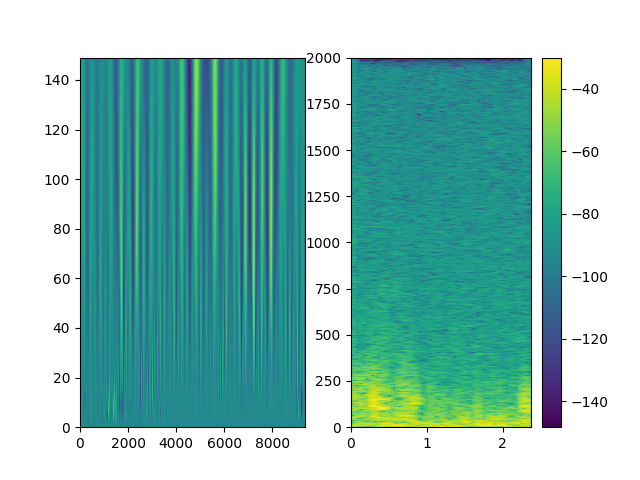

In [32]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.pcolormesh(coefs)

plt.subplot(1,2,2)
plt.pcolormesh(t,f,20*np.log10(abs(S)))
plt.colorbar()
plt.show()

In [29]:
print(S.shape)

(513, 62)


In [116]:
coefs.shape
print(coefs.mean(axis=1).shape)

(149,)


In [130]:
X_cwt_mean = np.zeros((len(X_segments), 149))
X_cwt_max = np.zeros((len(X_segments), 149))
for num, segm in enumerate(X_segments):
    print(f'Segmento {num + 1}')
    coeffs, _ = pywt.cwt(segm, scales=np.arange(1,150), wavelet='mexh')
    X_cwt_mean[num] = coeffs.mean(axis=1)
    X_cwt_max[num] = coeffs.max(axis=1)

Segmento 1
Segmento 2
Segmento 3
Segmento 4
Segmento 5
Segmento 6
Segmento 7
Segmento 8
Segmento 9
Segmento 10
Segmento 11
Segmento 12
Segmento 13
Segmento 14
Segmento 15
Segmento 16
Segmento 17
Segmento 18
Segmento 19
Segmento 20
Segmento 21
Segmento 22
Segmento 23
Segmento 24
Segmento 25
Segmento 26
Segmento 27
Segmento 28
Segmento 29
Segmento 30
Segmento 31
Segmento 32
Segmento 33
Segmento 34
Segmento 35
Segmento 36
Segmento 37
Segmento 38
Segmento 39
Segmento 40
Segmento 41
Segmento 42
Segmento 43
Segmento 44
Segmento 45
Segmento 46
Segmento 47
Segmento 48
Segmento 49
Segmento 50
Segmento 51
Segmento 52
Segmento 53
Segmento 54
Segmento 55
Segmento 56
Segmento 57
Segmento 58
Segmento 59
Segmento 60
Segmento 61
Segmento 62
Segmento 63
Segmento 64
Segmento 65
Segmento 66
Segmento 67
Segmento 68
Segmento 69
Segmento 70
Segmento 71
Segmento 72
Segmento 73
Segmento 74
Segmento 75
Segmento 76
Segmento 77
Segmento 78
Segmento 79
Segmento 80
Segmento 81
Segmento 82
Segmento 83
Segmento 84
S

Segmento 1250
Segmento 1251
Segmento 1252
Segmento 1253
Segmento 1254
Segmento 1255
Segmento 1256
Segmento 1257
Segmento 1258
Segmento 1259
Segmento 1260
Segmento 1261
Segmento 1262
Segmento 1263
Segmento 1264
Segmento 1265
Segmento 1266
Segmento 1267
Segmento 1268
Segmento 1269
Segmento 1270
Segmento 1271
Segmento 1272
Segmento 1273
Segmento 1274
Segmento 1275
Segmento 1276
Segmento 1277
Segmento 1278
Segmento 1279
Segmento 1280
Segmento 1281
Segmento 1282
Segmento 1283
Segmento 1284
Segmento 1285
Segmento 1286
Segmento 1287
Segmento 1288
Segmento 1289
Segmento 1290
Segmento 1291
Segmento 1292
Segmento 1293
Segmento 1294
Segmento 1295
Segmento 1296
Segmento 1297
Segmento 1298
Segmento 1299
Segmento 1300
Segmento 1301
Segmento 1302
Segmento 1303
Segmento 1304
Segmento 1305
Segmento 1306
Segmento 1307
Segmento 1308
Segmento 1309
Segmento 1310
Segmento 1311
Segmento 1312
Segmento 1313
Segmento 1314
Segmento 1315
Segmento 1316
Segmento 1317
Segmento 1318
Segmento 1319
Segmento 1320
Segmen

Segmento 2420
Segmento 2421
Segmento 2422
Segmento 2423
Segmento 2424
Segmento 2425
Segmento 2426
Segmento 2427
Segmento 2428
Segmento 2429
Segmento 2430
Segmento 2431
Segmento 2432
Segmento 2433
Segmento 2434
Segmento 2435
Segmento 2436
Segmento 2437
Segmento 2438
Segmento 2439
Segmento 2440
Segmento 2441
Segmento 2442
Segmento 2443
Segmento 2444
Segmento 2445
Segmento 2446
Segmento 2447
Segmento 2448
Segmento 2449
Segmento 2450
Segmento 2451
Segmento 2452
Segmento 2453
Segmento 2454
Segmento 2455
Segmento 2456
Segmento 2457
Segmento 2458
Segmento 2459
Segmento 2460
Segmento 2461
Segmento 2462
Segmento 2463
Segmento 2464
Segmento 2465
Segmento 2466
Segmento 2467
Segmento 2468
Segmento 2469
Segmento 2470
Segmento 2471
Segmento 2472
Segmento 2473
Segmento 2474
Segmento 2475
Segmento 2476
Segmento 2477
Segmento 2478
Segmento 2479
Segmento 2480
Segmento 2481
Segmento 2482
Segmento 2483
Segmento 2484
Segmento 2485
Segmento 2486
Segmento 2487
Segmento 2488
Segmento 2489
Segmento 2490
Segmen

Segmento 3590
Segmento 3591
Segmento 3592
Segmento 3593
Segmento 3594
Segmento 3595
Segmento 3596
Segmento 3597
Segmento 3598
Segmento 3599
Segmento 3600
Segmento 3601
Segmento 3602
Segmento 3603
Segmento 3604
Segmento 3605
Segmento 3606
Segmento 3607
Segmento 3608
Segmento 3609
Segmento 3610
Segmento 3611
Segmento 3612
Segmento 3613
Segmento 3614
Segmento 3615
Segmento 3616
Segmento 3617
Segmento 3618
Segmento 3619
Segmento 3620
Segmento 3621
Segmento 3622
Segmento 3623
Segmento 3624
Segmento 3625
Segmento 3626
Segmento 3627
Segmento 3628
Segmento 3629
Segmento 3630
Segmento 3631
Segmento 3632
Segmento 3633
Segmento 3634
Segmento 3635
Segmento 3636
Segmento 3637
Segmento 3638
Segmento 3639
Segmento 3640
Segmento 3641
Segmento 3642
Segmento 3643
Segmento 3644
Segmento 3645
Segmento 3646
Segmento 3647
Segmento 3648
Segmento 3649
Segmento 3650
Segmento 3651
Segmento 3652
Segmento 3653
Segmento 3654
Segmento 3655
Segmento 3656
Segmento 3657
Segmento 3658
Segmento 3659
Segmento 3660
Segmen

Segmento 4760
Segmento 4761
Segmento 4762
Segmento 4763
Segmento 4764
Segmento 4765
Segmento 4766
Segmento 4767
Segmento 4768
Segmento 4769
Segmento 4770
Segmento 4771
Segmento 4772
Segmento 4773
Segmento 4774
Segmento 4775
Segmento 4776
Segmento 4777
Segmento 4778
Segmento 4779
Segmento 4780
Segmento 4781
Segmento 4782
Segmento 4783
Segmento 4784
Segmento 4785
Segmento 4786
Segmento 4787
Segmento 4788
Segmento 4789
Segmento 4790
Segmento 4791
Segmento 4792
Segmento 4793
Segmento 4794
Segmento 4795
Segmento 4796
Segmento 4797
Segmento 4798
Segmento 4799
Segmento 4800
Segmento 4801
Segmento 4802
Segmento 4803
Segmento 4804
Segmento 4805
Segmento 4806
Segmento 4807
Segmento 4808
Segmento 4809
Segmento 4810
Segmento 4811
Segmento 4812
Segmento 4813
Segmento 4814
Segmento 4815
Segmento 4816
Segmento 4817
Segmento 4818
Segmento 4819
Segmento 4820
Segmento 4821
Segmento 4822
Segmento 4823
Segmento 4824
Segmento 4825
Segmento 4826
Segmento 4827
Segmento 4828
Segmento 4829
Segmento 4830
Segmen

Segmento 5930
Segmento 5931
Segmento 5932
Segmento 5933
Segmento 5934
Segmento 5935
Segmento 5936
Segmento 5937
Segmento 5938
Segmento 5939
Segmento 5940
Segmento 5941
Segmento 5942
Segmento 5943
Segmento 5944
Segmento 5945
Segmento 5946
Segmento 5947
Segmento 5948
Segmento 5949
Segmento 5950
Segmento 5951
Segmento 5952
Segmento 5953
Segmento 5954
Segmento 5955
Segmento 5956
Segmento 5957
Segmento 5958
Segmento 5959
Segmento 5960
Segmento 5961
Segmento 5962
Segmento 5963
Segmento 5964
Segmento 5965
Segmento 5966
Segmento 5967
Segmento 5968
Segmento 5969
Segmento 5970
Segmento 5971
Segmento 5972
Segmento 5973
Segmento 5974
Segmento 5975
Segmento 5976
Segmento 5977
Segmento 5978
Segmento 5979


In [131]:
np.savez('_temp_files/X_cwt_mean.npz', X_cwt_mean=X_cwt_mean)
np.savez('_temp_files/X_cwt_max.npz' , X_cwt_max =X_cwt_max)

In [133]:
X_cwt_mean

array([[-1.08461739e-04, -3.25177505e-04, -5.95722685e-04, ...,
        -1.80072556e-02, -1.91307568e-02, -2.02907825e-02],
       [-2.55158044e-05, -7.77372721e-05, -1.44384243e-04, ...,
        -2.56051471e-02, -2.60578117e-02, -2.65004348e-02],
       [-4.32176331e-05, -1.29739529e-04, -2.37023497e-04, ...,
         2.00320342e-02,  2.01488398e-02,  2.02573423e-02],
       ...,
       [ 6.60687565e-06,  2.05168537e-05,  3.94280318e-05, ...,
        -4.62790391e-02, -4.69237694e-02, -4.75767445e-02],
       [ 3.82848537e-05,  1.15987388e-04,  2.15049342e-04, ...,
         9.40259609e-04,  9.45691372e-04,  9.45247692e-04],
       [ 7.83227493e-05,  2.41973293e-04,  4.49202726e-04, ...,
         1.46734939e-01,  1.46718114e-01,  1.46585356e-01]])

In [138]:
class_params = {'classifier': 'knn', 'k_neigh': 3}
class_params = {'classifier': 'svm', 'kernel': 'poly'}

# Diseño de los clasificadores y resultados
# confmat_wheeze_mean, accuracy_wheeze_mean = \
#         crossval_results(X_cwt_mean, Y_wheeze, 
#                          experiment_type='ML', 
#                          clean_params=clean_params, 
#                          sel_params=sel_params, 
#                          class_params=class_params)

# confmat_crackl_mean, accuracy_crackl_mean = \
#         crossval_results(X_cwt_mean, Y_crackl, 
#                          experiment_type='ML', 
#                          clean_params=clean_params, 
#                          sel_params=sel_params, 
#                          class_params=class_params)

confmat_wheeze_max, accuracy_wheeze_max = \
        crossval_results(X_cwt_max, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_max, accuracy_crackl_max = \
        crossval_results(X_cwt_max, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 184 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 213 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 208 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 216 features/s]


Clean: number of features reduced from 149 to 7.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 278 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 225 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 226 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 226 features/s]


Clean: number of features reduced from 149 to 7.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 262 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 220 features/s]


Accuracy 10-fold CV: 0.791383917193361 +- 0.07926845389459643
Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 219 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 239 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 221 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 222 features/s]


Clean: number of features reduced from 149 to 7.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 270 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 223 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 221 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 219 features/s]


Clean: number of features reduced from 149 to 7.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 228 features/s]


Clean: number of features reduced from 149 to 8.








Selecting Features: 100%|█████████████████████████████████████████████████████| 5.00/5.00 [00:00<00:00, 212 features/s]


Accuracy 10-fold CV: 0.6257979445346538 +- 0.13356181676032533


In [124]:
%matplotlib notebook


(5979, 149)

# Redes neuronales CNN - FIT GENERATOR

In [72]:
cnn_params = {'optimizer': 'Adam', 'loss': 'categorical_crossentropy',
              'batch_size': 5, 'epochs': 10, 'verbose': 0, 
              'metrics': ['accuracy'],
              'out_layer': 'softmax'}

index_test = 10
kfold = 10
# Definición de los pacientes de testeo 
test_patients = patient_groups[index_test]

# Y entrenamiento
train_patients = list()
for i in range(1, kfold + 1):
    if i != index_test:
        train_patients.extend(patient_groups[i])

# Definición de las entradas de entrenamiento y testeo
train_indexes = list()
test_indexes = list()

for i in train_patients:
    train_indexes.extend(patient_register[str(i)])

for i in test_patients:
    test_indexes.extend(patient_register[str(i)])
    
XY_train = ((X_segments[i], Y_wheeze[i]) for i in range(len(X_segments)) if i in train_indexes)
X_train  = [X_segments[i] for i in range(len(X_segments)) if i in train_indexes]
Y_train  = Y_wheeze[train_indexes]
X_test  = [X_segments[i] for i in range(len(X_segments)) if i in test_indexes]
Y_test  = Y_wheeze[test_indexes]

In [73]:
model = CNN_network_2(input_shape=(None, 1), padding_value=0, 
                    out_layer=cnn_params['out_layer'])
model.compile(optimizer=cnn_params['optimizer'], loss=cnn_params['loss'],
              metrics=cnn_params['metrics'])

In [74]:
model.summary()

Model: "Red_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
Conv_cnn_1_0 (Conv1D)        (None, None, 100)         10100     
_________________________________________________________________
BatchNorm_cnn_1_0 (BatchNorm (None, None, 100)         400       
_________________________________________________________________
Activation_cnn_1_0 (Activati (None, None, 100)         0         
_________________________________________________________________
Conv_cnn_1_1 (Conv1D)        (None, None, 100)         1000100   
_________________________________________________________________
BatchNorm_cnn_1_1 (BatchNorm (None, None, 100)         400       
_________________________________________________________________
Activation_cnn_1_1 (Activati (None, None, 100)         0   

In [75]:
# Pasando a One-Hot
Y_train1H = np.array([Y_train, np.ones(Y_train.shape[0]) - Y_train]).T
print(Y_train.shape)
print(Y_train1H.shape)

(5379,)
(5379, 2)


In [37]:
X_train[0].shape

(2395,)

In [81]:
def generator(inputs, labels):
    i = 0
    while True:
        inputs_batch = np.expand_dims([inputs[i%len(inputs)]], axis=-1)
        labels_batch = np.array([labels[i%len(inputs)]])
        yield inputs_batch, labels_batch
        i+=1

        
for i in range(len(X_train)):
    print(i)
    x = np.expand_dims([X_train[i]], axis=-1)
    y = np.array([Y_train1H[i]])
#     print(x.shape)
#     print(y.shape)
    history = model.fit(x, y, verbose=1)
    
# history = model.fit(generator(X_train, Y_train1H), epochs=cnn_params['epochs'], verbose=1)

Epoch 1/10
      2/Unknown - 0s 54ms/step - loss: 0.2725 - accuracy: 1.00 - 0s 116ms/step - loss: 0.2724 - accuracy: 1.0000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0580s vs `on_train_batch_end` time: 0.1202s). Check your callbacks.


    169/Unknown - 0s 126ms/step - loss: 0.2723 - accuracy: 1.000 - 1s 136ms/step - loss: 0.2721 - accuracy: 1.000 - 1s 139ms/step - loss: 0.2720 - accuracy: 1.000 - 1s 142ms/step - loss: 0.2719 - accuracy: 1.000 - 1s 145ms/step - loss: 0.2717 - accuracy: 1.000 - 1s 147ms/step - loss: 0.2716 - accuracy: 1.000 - 1s 147ms/step - loss: 0.2715 - accuracy: 1.000 - 1s 149ms/step - loss: 0.2713 - accuracy: 1.000 - 2s 150ms/step - loss: 0.2712 - accuracy: 1.000 - 2s 149ms/step - loss: 0.2711 - accuracy: 1.000 - 2s 147ms/step - loss: 0.2709 - accuracy: 1.000 - 2s 149ms/step - loss: 0.2708 - accuracy: 1.000 - 2s 151ms/step - loss: 0.2707 - accuracy: 1.000 - 2s 152ms/step - loss: 0.2705 - accuracy: 1.000 - 3s 152ms/step - loss: 0.2704 - accuracy: 1.000 - 3s 153ms/step - loss: 0.2703 - accuracy: 1.000 - 3s 154ms/step - loss: 0.2701 - accuracy: 1.000 - 3s 154ms/step - loss: 0.2700 - accuracy: 1.000 - 3s 155ms/step - loss: 0.2699 - accuracy: 1.000 - 3s 156ms/step - loss: 0.2697 - accuracy: 1.000 - 4s

    664/Unknown - 97s 193ms/step - loss: 0.5327 - accuracy: 0.77 - 98s 193ms/step - loss: 0.5322 - accuracy: 0.77 - 98s 193ms/step - loss: 0.5317 - accuracy: 0.77 - 98s 193ms/step - loss: 0.5311 - accuracy: 0.77 - 98s 193ms/step - loss: 0.5306 - accuracy: 0.77 - 98s 193ms/step - loss: 0.5301 - accuracy: 0.78 - 98s 193ms/step - loss: 0.5296 - accuracy: 0.78 - 99s 193ms/step - loss: 0.5291 - accuracy: 0.78 - 99s 193ms/step - loss: 0.5285 - accuracy: 0.78 - 99s 193ms/step - loss: 0.5280 - accuracy: 0.78 - 99s 193ms/step - loss: 0.5275 - accuracy: 0.78 - 99s 192ms/step - loss: 0.5270 - accuracy: 0.78 - 99s 192ms/step - loss: 0.5265 - accuracy: 0.78 - 100s 193ms/step - loss: 0.5260 - accuracy: 0.783 - 100s 193ms/step - loss: 0.5255 - accuracy: 0.783 - 100s 192ms/step - loss: 0.5250 - accuracy: 0.784 - 100s 192ms/step - loss: 0.5245 - accuracy: 0.784 - 100s 192ms/step - loss: 0.5240 - accuracy: 0.785 - 100s 192ms/step - loss: 0.5235 - accuracy: 0.785 - 100s 192ms/step - loss: 0.5230 - accura

    825/Unknown - 128s 193ms/step - loss: 0.4677 - accuracy: 0.828 - 128s 193ms/step - loss: 0.4673 - accuracy: 0.828 - 128s 193ms/step - loss: 0.4670 - accuracy: 0.829 - 129s 193ms/step - loss: 0.4666 - accuracy: 0.829 - 129s 193ms/step - loss: 0.4662 - accuracy: 0.829 - 129s 193ms/step - loss: 0.4659 - accuracy: 0.829 - 129s 193ms/step - loss: 0.4655 - accuracy: 0.830 - 130s 193ms/step - loss: 0.4652 - accuracy: 0.830 - 130s 193ms/step - loss: 0.4648 - accuracy: 0.830 - 130s 193ms/step - loss: 0.4645 - accuracy: 0.830 - 130s 193ms/step - loss: 0.4641 - accuracy: 0.831 - 131s 193ms/step - loss: 0.4638 - accuracy: 0.831 - 131s 193ms/step - loss: 0.4634 - accuracy: 0.831 - 131s 193ms/step - loss: 0.4631 - accuracy: 0.831 - 131s 193ms/step - loss: 0.4628 - accuracy: 0.832 - 131s 193ms/step - loss: 0.4624 - accuracy: 0.832 - 131s 193ms/step - loss: 0.4621 - accuracy: 0.832 - 132s 193ms/step - loss: 0.4617 - accuracy: 0.832 - 132s 193ms/step - loss: 0.4614 - accuracy: 0.833 - 132s 193ms/st

    986/Unknown - 159s 192ms/step - loss: 0.5466 - accuracy: 0.766 - 159s 192ms/step - loss: 0.5462 - accuracy: 0.766 - 159s 192ms/step - loss: 0.5459 - accuracy: 0.766 - 159s 192ms/step - loss: 0.5456 - accuracy: 0.767 - 159s 192ms/step - loss: 0.5453 - accuracy: 0.767 - 159s 192ms/step - loss: 0.5449 - accuracy: 0.767 - 160s 192ms/step - loss: 0.5446 - accuracy: 0.768 - 160s 192ms/step - loss: 0.5443 - accuracy: 0.768 - 160s 192ms/step - loss: 0.5440 - accuracy: 0.768 - 160s 192ms/step - loss: 0.5437 - accuracy: 0.768 - 160s 192ms/step - loss: 0.5433 - accuracy: 0.769 - 161s 192ms/step - loss: 0.5430 - accuracy: 0.769 - 161s 192ms/step - loss: 0.5427 - accuracy: 0.769 - 161s 192ms/step - loss: 0.5424 - accuracy: 0.770 - 161s 192ms/step - loss: 0.5421 - accuracy: 0.770 - 161s 192ms/step - loss: 0.5417 - accuracy: 0.770 - 161s 192ms/step - loss: 0.5414 - accuracy: 0.770 - 162s 192ms/step - loss: 0.5411 - accuracy: 0.771 - 162s 192ms/step - loss: 0.5408 - accuracy: 0.771 - 162s 192ms/st

   1147/Unknown - 193s 196ms/step - loss: 0.5020 - accuracy: 0.802 - 193s 196ms/step - loss: 0.5017 - accuracy: 0.802 - 194s 196ms/step - loss: 0.5015 - accuracy: 0.802 - 194s 196ms/step - loss: 0.5012 - accuracy: 0.803 - 194s 196ms/step - loss: 0.5009 - accuracy: 0.803 - 194s 196ms/step - loss: 0.5007 - accuracy: 0.803 - 194s 196ms/step - loss: 0.5004 - accuracy: 0.803 - 195s 196ms/step - loss: 0.5001 - accuracy: 0.803 - 195s 196ms/step - loss: 0.4999 - accuracy: 0.804 - 195s 196ms/step - loss: 0.4996 - accuracy: 0.804 - 195s 196ms/step - loss: 0.4993 - accuracy: 0.804 - 195s 196ms/step - loss: 0.4991 - accuracy: 0.804 - 196s 196ms/step - loss: 0.4988 - accuracy: 0.804 - 196s 196ms/step - loss: 0.4986 - accuracy: 0.805 - 196s 196ms/step - loss: 0.4983 - accuracy: 0.805 - 196s 196ms/step - loss: 0.4980 - accuracy: 0.805 - 196s 196ms/step - loss: 0.4991 - accuracy: 0.804 - 197s 196ms/step - loss: 0.4988 - accuracy: 0.804 - 197s 196ms/step - loss: 0.4999 - accuracy: 0.804 - 197s 196ms/st

   1308/Unknown - 222s 193ms/step - loss: 0.4816 - accuracy: 0.817 - 222s 193ms/step - loss: 0.4813 - accuracy: 0.817 - 222s 193ms/step - loss: 0.4811 - accuracy: 0.817 - 222s 193ms/step - loss: 0.4809 - accuracy: 0.817 - 223s 193ms/step - loss: 0.4806 - accuracy: 0.817 - 223s 193ms/step - loss: 0.4804 - accuracy: 0.817 - 223s 193ms/step - loss: 0.4802 - accuracy: 0.818 - 223s 193ms/step - loss: 0.4800 - accuracy: 0.818 - 223s 193ms/step - loss: 0.4797 - accuracy: 0.818 - 223s 193ms/step - loss: 0.4795 - accuracy: 0.818 - 223s 193ms/step - loss: 0.4793 - accuracy: 0.818 - 224s 193ms/step - loss: 0.4791 - accuracy: 0.818 - 224s 193ms/step - loss: 0.4788 - accuracy: 0.819 - 224s 193ms/step - loss: 0.4786 - accuracy: 0.819 - 224s 193ms/step - loss: 0.4784 - accuracy: 0.819 - 224s 193ms/step - loss: 0.4782 - accuracy: 0.819 - 225s 193ms/step - loss: 0.4780 - accuracy: 0.819 - 225s 193ms/step - loss: 0.4777 - accuracy: 0.819 - 225s 193ms/step - loss: 0.4775 - accuracy: 0.819 - 225s 193ms/st

   1469/Unknown - 254s 194ms/step - loss: 0.4559 - accuracy: 0.834 - 254s 194ms/step - loss: 0.4557 - accuracy: 0.834 - 255s 194ms/step - loss: 0.4555 - accuracy: 0.834 - 255s 194ms/step - loss: 0.4553 - accuracy: 0.834 - 255s 194ms/step - loss: 0.4551 - accuracy: 0.834 - 255s 194ms/step - loss: 0.4549 - accuracy: 0.834 - 255s 194ms/step - loss: 0.4547 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4545 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4543 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4541 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4539 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4537 - accuracy: 0.835 - 256s 194ms/step - loss: 0.4535 - accuracy: 0.835 - 257s 194ms/step - loss: 0.4534 - accuracy: 0.835 - 257s 194ms/step - loss: 0.4532 - accuracy: 0.836 - 257s 194ms/step - loss: 0.4530 - accuracy: 0.836 - 257s 194ms/step - loss: 0.4528 - accuracy: 0.836 - 257s 194ms/step - loss: 0.4526 - accuracy: 0.836 - 258s 194ms/step - loss: 0.4524 - accuracy: 0.836 - 258s 194ms/st

   1630/Unknown - 287s 195ms/step - loss: 0.4559 - accuracy: 0.834 - 287s 195ms/step - loss: 0.4557 - accuracy: 0.834 - 287s 195ms/step - loss: 0.4555 - accuracy: 0.834 - 288s 195ms/step - loss: 0.4553 - accuracy: 0.834 - 288s 195ms/step - loss: 0.4552 - accuracy: 0.834 - 288s 195ms/step - loss: 0.4550 - accuracy: 0.834 - 288s 195ms/step - loss: 0.4548 - accuracy: 0.834 - 288s 195ms/step - loss: 0.4546 - accuracy: 0.834 - 289s 195ms/step - loss: 0.4545 - accuracy: 0.834 - 289s 195ms/step - loss: 0.4543 - accuracy: 0.835 - 289s 195ms/step - loss: 0.4541 - accuracy: 0.835 - 289s 195ms/step - loss: 0.4539 - accuracy: 0.835 - 289s 195ms/step - loss: 0.4537 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4536 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4534 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4532 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4531 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4529 - accuracy: 0.835 - 290s 195ms/step - loss: 0.4527 - accuracy: 0.836 - 291s 195ms/st

   1791/Unknown - 317s 194ms/step - loss: 0.4679 - accuracy: 0.825 - 317s 194ms/step - loss: 0.4678 - accuracy: 0.826 - 317s 194ms/step - loss: 0.4676 - accuracy: 0.826 - 317s 194ms/step - loss: 0.4675 - accuracy: 0.826 - 317s 194ms/step - loss: 0.4673 - accuracy: 0.826 - 317s 194ms/step - loss: 0.4671 - accuracy: 0.826 - 318s 194ms/step - loss: 0.4670 - accuracy: 0.826 - 318s 194ms/step - loss: 0.4668 - accuracy: 0.826 - 318s 194ms/step - loss: 0.4667 - accuracy: 0.826 - 318s 194ms/step - loss: 0.4665 - accuracy: 0.826 - 318s 194ms/step - loss: 0.4663 - accuracy: 0.826 - 319s 194ms/step - loss: 0.4662 - accuracy: 0.827 - 319s 194ms/step - loss: 0.4660 - accuracy: 0.827 - 319s 194ms/step - loss: 0.4659 - accuracy: 0.827 - 319s 194ms/step - loss: 0.4657 - accuracy: 0.827 - 319s 194ms/step - loss: 0.4655 - accuracy: 0.827 - 320s 194ms/step - loss: 0.4654 - accuracy: 0.827 - 320s 194ms/step - loss: 0.4652 - accuracy: 0.827 - 320s 194ms/step - loss: 0.4651 - accuracy: 0.827 - 320s 194ms/st

   1952/Unknown - 353s 197ms/step - loss: 0.4450 - accuracy: 0.840 - 353s 197ms/step - loss: 0.4448 - accuracy: 0.840 - 354s 197ms/step - loss: 0.4447 - accuracy: 0.840 - 354s 197ms/step - loss: 0.4445 - accuracy: 0.840 - 354s 197ms/step - loss: 0.4444 - accuracy: 0.840 - 354s 197ms/step - loss: 0.4442 - accuracy: 0.840 - 354s 197ms/step - loss: 0.4441 - accuracy: 0.840 - 355s 197ms/step - loss: 0.4439 - accuracy: 0.841 - 355s 197ms/step - loss: 0.4438 - accuracy: 0.841 - 355s 197ms/step - loss: 0.4437 - accuracy: 0.841 - 355s 197ms/step - loss: 0.4435 - accuracy: 0.841 - 355s 197ms/step - loss: 0.4434 - accuracy: 0.841 - 355s 197ms/step - loss: 0.4432 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4431 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4429 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4428 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4426 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4425 - accuracy: 0.841 - 356s 197ms/step - loss: 0.4423 - accuracy: 0.842 - 357s 197ms/st

   2113/Unknown - 386s 198ms/step - loss: 0.4424 - accuracy: 0.841 - 386s 198ms/step - loss: 0.4422 - accuracy: 0.841 - 386s 198ms/step - loss: 0.4421 - accuracy: 0.841 - 386s 198ms/step - loss: 0.4419 - accuracy: 0.842 - 387s 198ms/step - loss: 0.4418 - accuracy: 0.842 - 387s 198ms/step - loss: 0.4417 - accuracy: 0.842 - 387s 197ms/step - loss: 0.4415 - accuracy: 0.842 - 387s 197ms/step - loss: 0.4414 - accuracy: 0.842 - 387s 197ms/step - loss: 0.4413 - accuracy: 0.842 - 387s 197ms/step - loss: 0.4420 - accuracy: 0.842 - 387s 197ms/step - loss: 0.4427 - accuracy: 0.841 - 387s 197ms/step - loss: 0.4434 - accuracy: 0.841 - 387s 197ms/step - loss: 0.4441 - accuracy: 0.840 - 388s 197ms/step - loss: 0.4439 - accuracy: 0.840 - 388s 197ms/step - loss: 0.4438 - accuracy: 0.840 - 388s 197ms/step - loss: 0.4437 - accuracy: 0.841 - 388s 197ms/step - loss: 0.4435 - accuracy: 0.841 - 388s 197ms/step - loss: 0.4434 - accuracy: 0.841 - 388s 197ms/step - loss: 0.4433 - accuracy: 0.841 - 388s 197ms/st

   2274/Unknown - 421s 199ms/step - loss: 0.4619 - accuracy: 0.829 - 422s 199ms/step - loss: 0.4618 - accuracy: 0.829 - 422s 199ms/step - loss: 0.4617 - accuracy: 0.829 - 422s 199ms/step - loss: 0.4615 - accuracy: 0.829 - 422s 199ms/step - loss: 0.4614 - accuracy: 0.829 - 423s 199ms/step - loss: 0.4613 - accuracy: 0.829 - 423s 199ms/step - loss: 0.4619 - accuracy: 0.829 - 423s 199ms/step - loss: 0.4625 - accuracy: 0.828 - 423s 200ms/step - loss: 0.4631 - accuracy: 0.828 - 424s 200ms/step - loss: 0.4636 - accuracy: 0.828 - 424s 200ms/step - loss: 0.4635 - accuracy: 0.828 - 424s 200ms/step - loss: 0.4641 - accuracy: 0.827 - 424s 200ms/step - loss: 0.4640 - accuracy: 0.827 - 424s 200ms/step - loss: 0.4639 - accuracy: 0.827 - 425s 200ms/step - loss: 0.4637 - accuracy: 0.828 - 425s 200ms/step - loss: 0.4636 - accuracy: 0.828 - 425s 200ms/step - loss: 0.4635 - accuracy: 0.828 - 425s 200ms/step - loss: 0.4634 - accuracy: 0.828 - 426s 200ms/step - loss: 0.4632 - accuracy: 0.828 - 426s 200ms/st

   2435/Unknown - 452s 199ms/step - loss: 0.4640 - accuracy: 0.827 - 452s 199ms/step - loss: 0.4639 - accuracy: 0.827 - 452s 199ms/step - loss: 0.4638 - accuracy: 0.827 - 452s 199ms/step - loss: 0.4637 - accuracy: 0.827 - 452s 199ms/step - loss: 0.4636 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4634 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4633 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4632 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4631 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4630 - accuracy: 0.828 - 453s 198ms/step - loss: 0.4629 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4628 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4626 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4625 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4624 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4623 - accuracy: 0.828 - 454s 198ms/step - loss: 0.4622 - accuracy: 0.828 - 455s 198ms/step - loss: 0.4621 - accuracy: 0.829 - 455s 198ms/step - loss: 0.4619 - accuracy: 0.829 - 455s 198ms/st

   2596/Unknown - 483s 198ms/step - loss: 0.4485 - accuracy: 0.837 - 483s 198ms/step - loss: 0.4484 - accuracy: 0.837 - 483s 198ms/step - loss: 0.4483 - accuracy: 0.837 - 483s 198ms/step - loss: 0.4482 - accuracy: 0.837 - 483s 198ms/step - loss: 0.4481 - accuracy: 0.837 - 483s 198ms/step - loss: 0.4480 - accuracy: 0.837 - 484s 198ms/step - loss: 0.4479 - accuracy: 0.837 - 484s 198ms/step - loss: 0.4478 - accuracy: 0.837 - 484s 198ms/step - loss: 0.4476 - accuracy: 0.838 - 484s 198ms/step - loss: 0.4475 - accuracy: 0.838 - 484s 198ms/step - loss: 0.4474 - accuracy: 0.838 - 485s 198ms/step - loss: 0.4473 - accuracy: 0.838 - 485s 198ms/step - loss: 0.4472 - accuracy: 0.838 - 485s 198ms/step - loss: 0.4471 - accuracy: 0.838 - 485s 198ms/step - loss: 0.4470 - accuracy: 0.838 - 485s 198ms/step - loss: 0.4469 - accuracy: 0.838 - 486s 198ms/step - loss: 0.4468 - accuracy: 0.838 - 486s 198ms/step - loss: 0.4467 - accuracy: 0.838 - 486s 198ms/step - loss: 0.4465 - accuracy: 0.838 - 486s 198ms/st

   2757/Unknown - 512s 197ms/step - loss: 0.4319 - accuracy: 0.847 - 512s 197ms/step - loss: 0.4317 - accuracy: 0.847 - 512s 197ms/step - loss: 0.4316 - accuracy: 0.847 - 512s 197ms/step - loss: 0.4315 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4314 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4313 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4312 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4311 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4310 - accuracy: 0.847 - 513s 197ms/step - loss: 0.4309 - accuracy: 0.847 - 514s 197ms/step - loss: 0.4308 - accuracy: 0.847 - 514s 197ms/step - loss: 0.4307 - accuracy: 0.847 - 514s 197ms/step - loss: 0.4306 - accuracy: 0.847 - 514s 197ms/step - loss: 0.4305 - accuracy: 0.847 - 514s 197ms/step - loss: 0.4304 - accuracy: 0.848 - 515s 197ms/step - loss: 0.4303 - accuracy: 0.848 - 515s 197ms/step - loss: 0.4302 - accuracy: 0.848 - 515s 197ms/step - loss: 0.4301 - accuracy: 0.848 - 515s 197ms/step - loss: 0.4300 - accuracy: 0.848 - 515s 197ms/st

   2918/Unknown - 547s 198ms/step - loss: 0.4653 - accuracy: 0.826 - 547s 198ms/step - loss: 0.4657 - accuracy: 0.826 - 547s 198ms/step - loss: 0.4661 - accuracy: 0.826 - 547s 198ms/step - loss: 0.4666 - accuracy: 0.825 - 548s 198ms/step - loss: 0.4670 - accuracy: 0.825 - 548s 198ms/step - loss: 0.4669 - accuracy: 0.825 - 548s 198ms/step - loss: 0.4668 - accuracy: 0.825 - 548s 198ms/step - loss: 0.4667 - accuracy: 0.825 - 548s 198ms/step - loss: 0.4667 - accuracy: 0.825 - 549s 198ms/step - loss: 0.4666 - accuracy: 0.825 - 549s 198ms/step - loss: 0.4665 - accuracy: 0.825 - 549s 198ms/step - loss: 0.4664 - accuracy: 0.825 - 549s 198ms/step - loss: 0.4668 - accuracy: 0.825 - 549s 198ms/step - loss: 0.4667 - accuracy: 0.825 - 550s 198ms/step - loss: 0.4672 - accuracy: 0.825 - 550s 198ms/step - loss: 0.4676 - accuracy: 0.825 - 550s 198ms/step - loss: 0.4680 - accuracy: 0.824 - 550s 198ms/step - loss: 0.4685 - accuracy: 0.824 - 550s 198ms/step - loss: 0.4684 - accuracy: 0.824 - 551s 198ms/st

   3079/Unknown - 593s 203ms/step - loss: 0.4933 - accuracy: 0.806 - 594s 203ms/step - loss: 0.4932 - accuracy: 0.806 - 594s 203ms/step - loss: 0.4931 - accuracy: 0.806 - 594s 203ms/step - loss: 0.4930 - accuracy: 0.806 - 594s 203ms/step - loss: 0.4929 - accuracy: 0.806 - 595s 203ms/step - loss: 0.4929 - accuracy: 0.806 - 595s 203ms/step - loss: 0.4928 - accuracy: 0.806 - 595s 203ms/step - loss: 0.4927 - accuracy: 0.806 - 595s 203ms/step - loss: 0.4926 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4925 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4925 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4928 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4927 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4926 - accuracy: 0.806 - 596s 203ms/step - loss: 0.4926 - accuracy: 0.806 - 597s 203ms/step - loss: 0.4925 - accuracy: 0.806 - 597s 203ms/step - loss: 0.4924 - accuracy: 0.806 - 597s 203ms/step - loss: 0.4923 - accuracy: 0.806 - 597s 203ms/step - loss: 0.4922 - accuracy: 0.806 - 597s 203ms/st

   3240/Unknown - 625s 203ms/step - loss: 0.4997 - accuracy: 0.801 - 625s 203ms/step - loss: 0.5000 - accuracy: 0.800 - 625s 203ms/step - loss: 0.5003 - accuracy: 0.800 - 626s 203ms/step - loss: 0.5006 - accuracy: 0.800 - 626s 203ms/step - loss: 0.5009 - accuracy: 0.799 - 626s 203ms/step - loss: 0.5012 - accuracy: 0.799 - 626s 203ms/step - loss: 0.5015 - accuracy: 0.799 - 626s 203ms/step - loss: 0.5018 - accuracy: 0.799 - 626s 203ms/step - loss: 0.5021 - accuracy: 0.798 - 626s 203ms/step - loss: 0.5024 - accuracy: 0.798 - 626s 203ms/step - loss: 0.5027 - accuracy: 0.798 - 627s 203ms/step - loss: 0.5030 - accuracy: 0.798 - 627s 203ms/step - loss: 0.5033 - accuracy: 0.797 - 627s 203ms/step - loss: 0.5036 - accuracy: 0.797 - 627s 203ms/step - loss: 0.5039 - accuracy: 0.797 - 627s 203ms/step - loss: 0.5042 - accuracy: 0.797 - 627s 203ms/step - loss: 0.5042 - accuracy: 0.797 - 627s 203ms/step - loss: 0.5045 - accuracy: 0.796 - 628s 203ms/step - loss: 0.5047 - accuracy: 0.796 - 628s 203ms/st

   3401/Unknown - 660s 204ms/step - loss: 0.5099 - accuracy: 0.792 - 660s 204ms/step - loss: 0.5098 - accuracy: 0.792 - 660s 204ms/step - loss: 0.5101 - accuracy: 0.792 - 661s 204ms/step - loss: 0.5100 - accuracy: 0.792 - 661s 204ms/step - loss: 0.5100 - accuracy: 0.792 - 661s 204ms/step - loss: 0.5099 - accuracy: 0.792 - 661s 204ms/step - loss: 0.5098 - accuracy: 0.792 - 661s 204ms/step - loss: 0.5098 - accuracy: 0.792 - 662s 204ms/step - loss: 0.5097 - accuracy: 0.792 - 662s 204ms/step - loss: 0.5096 - accuracy: 0.792 - 662s 204ms/step - loss: 0.5096 - accuracy: 0.792 - 662s 204ms/step - loss: 0.5095 - accuracy: 0.792 - 662s 204ms/step - loss: 0.5094 - accuracy: 0.792 - 663s 204ms/step - loss: 0.5094 - accuracy: 0.792 - 663s 204ms/step - loss: 0.5093 - accuracy: 0.792 - 663s 204ms/step - loss: 0.5092 - accuracy: 0.793 - 663s 204ms/step - loss: 0.5092 - accuracy: 0.793 - 663s 204ms/step - loss: 0.5091 - accuracy: 0.793 - 664s 204ms/step - loss: 0.5090 - accuracy: 0.793 - 664s 204ms/st

   3562/Unknown - 694s 204ms/step - loss: 0.5009 - accuracy: 0.800 - 695s 204ms/step - loss: 0.5008 - accuracy: 0.800 - 695s 204ms/step - loss: 0.5007 - accuracy: 0.800 - 695s 204ms/step - loss: 0.5007 - accuracy: 0.800 - 695s 204ms/step - loss: 0.5009 - accuracy: 0.800 - 696s 204ms/step - loss: 0.5012 - accuracy: 0.800 - 696s 204ms/step - loss: 0.5015 - accuracy: 0.799 - 696s 204ms/step - loss: 0.5018 - accuracy: 0.799 - 696s 204ms/step - loss: 0.5021 - accuracy: 0.799 - 696s 204ms/step - loss: 0.5024 - accuracy: 0.799 - 696s 204ms/step - loss: 0.5027 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5030 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5029 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5028 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5031 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5034 - accuracy: 0.798 - 697s 204ms/step - loss: 0.5037 - accuracy: 0.798 - 698s 204ms/step - loss: 0.5039 - accuracy: 0.797 - 698s 204ms/step - loss: 0.5042 - accuracy: 0.797 - 698s 204ms/st

   3723/Unknown - 737s 207ms/step - loss: 0.5253 - accuracy: 0.778 - 737s 207ms/step - loss: 0.5253 - accuracy: 0.778 - 737s 207ms/step - loss: 0.5252 - accuracy: 0.778 - 738s 207ms/step - loss: 0.5251 - accuracy: 0.778 - 738s 207ms/step - loss: 0.5251 - accuracy: 0.778 - 738s 207ms/step - loss: 0.5253 - accuracy: 0.778 - 738s 207ms/step - loss: 0.5255 - accuracy: 0.778 - 739s 207ms/step - loss: 0.5257 - accuracy: 0.777 - 739s 207ms/step - loss: 0.5257 - accuracy: 0.777 - 739s 207ms/step - loss: 0.5256 - accuracy: 0.778 - 739s 207ms/step - loss: 0.5255 - accuracy: 0.778 - 740s 207ms/step - loss: 0.5255 - accuracy: 0.778 - 740s 207ms/step - loss: 0.5257 - accuracy: 0.777 - 740s 207ms/step - loss: 0.5259 - accuracy: 0.777 - 740s 207ms/step - loss: 0.5261 - accuracy: 0.777 - 741s 207ms/step - loss: 0.5263 - accuracy: 0.777 - 741s 207ms/step - loss: 0.5263 - accuracy: 0.777 - 741s 207ms/step - loss: 0.5262 - accuracy: 0.777 - 741s 207ms/step - loss: 0.5262 - accuracy: 0.777 - 742s 207ms/st

   3884/Unknown - 777s 209ms/step - loss: 0.5273 - accuracy: 0.776 - 778s 209ms/step - loss: 0.5272 - accuracy: 0.776 - 778s 209ms/step - loss: 0.5272 - accuracy: 0.777 - 778s 209ms/step - loss: 0.5271 - accuracy: 0.777 - 778s 209ms/step - loss: 0.5273 - accuracy: 0.776 - 778s 209ms/step - loss: 0.5273 - accuracy: 0.776 - 778s 209ms/step - loss: 0.5272 - accuracy: 0.776 - 778s 209ms/step - loss: 0.5274 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5274 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5273 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5273 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5275 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5274 - accuracy: 0.776 - 779s 209ms/step - loss: 0.5274 - accuracy: 0.776 - 780s 209ms/step - loss: 0.5276 - accuracy: 0.776 - 780s 209ms/step - loss: 0.5275 - accuracy: 0.776 - 780s 209ms/step - loss: 0.5275 - accuracy: 0.776 - 780s 209ms/step - loss: 0.5274 - accuracy: 0.776 - 780s 208ms/step - loss: 0.5273 - accuracy: 0.776 - 780s 208ms/st

   4045/Unknown - 807s 208ms/step - loss: 0.5229 - accuracy: 0.781 - 807s 208ms/step - loss: 0.5228 - accuracy: 0.781 - 808s 208ms/step - loss: 0.5228 - accuracy: 0.781 - 808s 208ms/step - loss: 0.5227 - accuracy: 0.781 - 808s 208ms/step - loss: 0.5226 - accuracy: 0.781 - 808s 208ms/step - loss: 0.5226 - accuracy: 0.782 - 808s 208ms/step - loss: 0.5225 - accuracy: 0.782 - 809s 208ms/step - loss: 0.5225 - accuracy: 0.782 - 809s 208ms/step - loss: 0.5224 - accuracy: 0.782 - 809s 208ms/step - loss: 0.5223 - accuracy: 0.782 - 809s 208ms/step - loss: 0.5223 - accuracy: 0.782 - 809s 208ms/step - loss: 0.5222 - accuracy: 0.782 - 810s 208ms/step - loss: 0.5222 - accuracy: 0.782 - 810s 208ms/step - loss: 0.5221 - accuracy: 0.782 - 810s 208ms/step - loss: 0.5221 - accuracy: 0.782 - 810s 208ms/step - loss: 0.5220 - accuracy: 0.782 - 811s 208ms/step - loss: 0.5219 - accuracy: 0.782 - 811s 208ms/step - loss: 0.5219 - accuracy: 0.782 - 811s 208ms/step - loss: 0.5218 - accuracy: 0.782 - 811s 208ms/st

   4206/Unknown - 843s 208ms/step - loss: 0.5155 - accuracy: 0.788 - 843s 208ms/step - loss: 0.5155 - accuracy: 0.788 - 844s 208ms/step - loss: 0.5154 - accuracy: 0.788 - 844s 208ms/step - loss: 0.5153 - accuracy: 0.788 - 844s 208ms/step - loss: 0.5153 - accuracy: 0.788 - 845s 208ms/step - loss: 0.5152 - accuracy: 0.788 - 845s 208ms/step - loss: 0.5151 - accuracy: 0.788 - 845s 208ms/step - loss: 0.5151 - accuracy: 0.788 - 845s 208ms/step - loss: 0.5153 - accuracy: 0.788 - 846s 209ms/step - loss: 0.5155 - accuracy: 0.788 - 846s 209ms/step - loss: 0.5158 - accuracy: 0.788 - 846s 209ms/step - loss: 0.5160 - accuracy: 0.788 - 846s 209ms/step - loss: 0.5162 - accuracy: 0.787 - 847s 209ms/step - loss: 0.5165 - accuracy: 0.787 - 847s 209ms/step - loss: 0.5167 - accuracy: 0.787 - 847s 209ms/step - loss: 0.5169 - accuracy: 0.787 - 847s 209ms/step - loss: 0.5172 - accuracy: 0.787 - 848s 209ms/step - loss: 0.5174 - accuracy: 0.786 - 848s 209ms/step - loss: 0.5176 - accuracy: 0.786 - 848s 209ms/st

   4367/Unknown - 875s 208ms/step - loss: 0.5244 - accuracy: 0.780 - 875s 208ms/step - loss: 0.5243 - accuracy: 0.780 - 875s 208ms/step - loss: 0.5243 - accuracy: 0.780 - 876s 208ms/step - loss: 0.5245 - accuracy: 0.780 - 876s 208ms/step - loss: 0.5247 - accuracy: 0.780 - 876s 208ms/step - loss: 0.5249 - accuracy: 0.780 - 876s 208ms/step - loss: 0.5251 - accuracy: 0.780 - 877s 208ms/step - loss: 0.5253 - accuracy: 0.780 - 877s 208ms/step - loss: 0.5252 - accuracy: 0.780 - 877s 208ms/step - loss: 0.5252 - accuracy: 0.780 - 877s 208ms/step - loss: 0.5254 - accuracy: 0.779 - 877s 208ms/step - loss: 0.5253 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5253 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5252 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5252 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5251 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5251 - accuracy: 0.780 - 878s 208ms/step - loss: 0.5250 - accuracy: 0.780 - 879s 208ms/step - loss: 0.5250 - accuracy: 0.780 - 879s 208ms/st

   4528/Unknown - 904s 207ms/step - loss: 0.5225 - accuracy: 0.782 - 904s 207ms/step - loss: 0.5224 - accuracy: 0.782 - 904s 207ms/step - loss: 0.5224 - accuracy: 0.782 - 904s 207ms/step - loss: 0.5223 - accuracy: 0.782 - 905s 207ms/step - loss: 0.5223 - accuracy: 0.782 - 905s 207ms/step - loss: 0.5222 - accuracy: 0.783 - 905s 207ms/step - loss: 0.5221 - accuracy: 0.783 - 905s 207ms/step - loss: 0.5221 - accuracy: 0.783 - 905s 207ms/step - loss: 0.5220 - accuracy: 0.783 - 905s 207ms/step - loss: 0.5220 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5219 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5219 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5218 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5218 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5217 - accuracy: 0.783 - 906s 207ms/step - loss: 0.5216 - accuracy: 0.783 - 907s 207ms/step - loss: 0.5216 - accuracy: 0.783 - 907s 207ms/step - loss: 0.5215 - accuracy: 0.783 - 907s 207ms/step - loss: 0.5215 - accuracy: 0.783 - 907s 207ms/st

   4689/Unknown - 936s 207ms/step - loss: 0.5131 - accuracy: 0.790 - 936s 207ms/step - loss: 0.5131 - accuracy: 0.790 - 936s 207ms/step - loss: 0.5130 - accuracy: 0.790 - 937s 207ms/step - loss: 0.5129 - accuracy: 0.790 - 937s 207ms/step - loss: 0.5129 - accuracy: 0.790 - 937s 207ms/step - loss: 0.5128 - accuracy: 0.790 - 937s 207ms/step - loss: 0.5128 - accuracy: 0.790 - 937s 207ms/step - loss: 0.5130 - accuracy: 0.790 - 938s 207ms/step - loss: 0.5132 - accuracy: 0.790 - 938s 207ms/step - loss: 0.5134 - accuracy: 0.790 - 938s 207ms/step - loss: 0.5137 - accuracy: 0.790 - 938s 207ms/step - loss: 0.5139 - accuracy: 0.789 - 939s 207ms/step - loss: 0.5141 - accuracy: 0.789 - 939s 207ms/step - loss: 0.5144 - accuracy: 0.789 - 939s 207ms/step - loss: 0.5143 - accuracy: 0.789 - 939s 207ms/step - loss: 0.5145 - accuracy: 0.789 - 939s 207ms/step - loss: 0.5147 - accuracy: 0.789 - 940s 207ms/step - loss: 0.5150 - accuracy: 0.789 - 940s 207ms/step - loss: 0.5152 - accuracy: 0.788 - 940s 207ms/st

   4850/Unknown - 977s 208ms/step - loss: 0.5169 - accuracy: 0.787 - 977s 208ms/step - loss: 0.5169 - accuracy: 0.787 - 978s 208ms/step - loss: 0.5168 - accuracy: 0.787 - 978s 208ms/step - loss: 0.5168 - accuracy: 0.787 - 978s 208ms/step - loss: 0.5167 - accuracy: 0.787 - 978s 208ms/step - loss: 0.5167 - accuracy: 0.787 - 978s 208ms/step - loss: 0.5166 - accuracy: 0.787 - 979s 208ms/step - loss: 0.5165 - accuracy: 0.787 - 979s 208ms/step - loss: 0.5165 - accuracy: 0.788 - 979s 208ms/step - loss: 0.5164 - accuracy: 0.788 - 979s 208ms/step - loss: 0.5164 - accuracy: 0.788 - 979s 208ms/step - loss: 0.5163 - accuracy: 0.788 - 979s 208ms/step - loss: 0.5163 - accuracy: 0.788 - 979s 208ms/step - loss: 0.5162 - accuracy: 0.788 - 980s 208ms/step - loss: 0.5161 - accuracy: 0.788 - 980s 208ms/step - loss: 0.5161 - accuracy: 0.788 - 980s 208ms/step - loss: 0.5160 - accuracy: 0.788 - 980s 208ms/step - loss: 0.5160 - accuracy: 0.788 - 980s 208ms/step - loss: 0.5159 - accuracy: 0.788 - 981s 208ms/st

   5011/Unknown - 1007s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1007s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1008s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1008s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1008s 208ms/step - loss: 0.5181 - accuracy: 0.78 - 1008s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1008s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1009s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1009s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1009s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1009s 208ms/step - loss: 0.5177 - accuracy: 0.78 - 1010s 208ms/step - loss: 0.5177 - accuracy: 0.78 - 1010s 208ms/step - loss: 0.5176 - accuracy: 0.78 - 1010s 208ms/step - loss: 0.5176 - accuracy: 0.78 - 1010s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1010s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1011s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1011s 208ms/step - loss: 0.5173 - accuracy: 0.78 - 1011s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1011s 208ms/s

   5172/Unknown - 1043s 208ms/step - loss: 0.5280 - accuracy: 0.77 - 1043s 208ms/step - loss: 0.5279 - accuracy: 0.77 - 1043s 208ms/step - loss: 0.5279 - accuracy: 0.77 - 1043s 208ms/step - loss: 0.5281 - accuracy: 0.77 - 1043s 208ms/step - loss: 0.5282 - accuracy: 0.77 - 1043s 208ms/step - loss: 0.5284 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5286 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5287 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5287 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5289 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5290 - accuracy: 0.77 - 1044s 208ms/step - loss: 0.5292 - accuracy: 0.77 - 1045s 208ms/step - loss: 0.5294 - accuracy: 0.77 - 1045s 208ms/step - loss: 0.5295 - accuracy: 0.77 - 1045s 208ms/step - loss: 0.5297 - accuracy: 0.77 - 1045s 208ms/step - loss: 0.5297 - accuracy: 0.77 - 1046s 208ms/step - loss: 0.5298 - accuracy: 0.77 - 1046s 208ms/step - loss: 0.5300 - accuracy: 0.77 - 1046s 208ms/step - loss: 0.5302 - accuracy: 0.77 - 1046s 208ms/s

   5333/Unknown - 1083s 209ms/step - loss: 0.5254 - accuracy: 0.78 - 1083s 209ms/step - loss: 0.5254 - accuracy: 0.78 - 1084s 209ms/step - loss: 0.5253 - accuracy: 0.78 - 1084s 209ms/step - loss: 0.5253 - accuracy: 0.78 - 1084s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 1085s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 1085s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 1085s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 1085s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 1086s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1086s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1086s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 1086s 209ms/step - loss: 0.5253 - accuracy: 0.78 - 1087s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1087s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 1087s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 1088s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1088s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 1088s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 1088s 210ms/s

   5494/Unknown - 1125s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 1125s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 1125s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 1125s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5271 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5271 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5270 - accuracy: 0.77 - 1126s 211ms/step - loss: 0.5270 - accuracy: 0.77 - 1127s 211ms/step - loss: 0.5270 - accuracy: 0.77 - 1127s 211ms/step - loss: 0.5269 - accuracy: 0.77 - 1127s 211ms/step - loss: 0.5269 - accuracy: 0.77 - 1127s 211ms/step - loss: 0.5268 - accuracy: 0.77 - 1127s 211ms/step - loss: 0.5268 - accuracy: 0.78 - 1127s 211ms/step - loss: 0.5267 - accuracy: 0.78 - 1127s 211ms/step - loss: 0.5267 - accuracy: 0.78 - 1128s 211ms/step - loss: 0.5266 - accuracy: 0.78 - 1128s 211ms/s

   5655/Unknown - 1152s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 1152s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 1152s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 1152s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 1153s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 1153s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 1153s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 1153s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 1153s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 1154s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 1154s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 1154s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 1154s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 1154s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1155s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 1155s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 1155s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 1155s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 1155s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 1156s 210ms/s

   5816/Unknown - 1183s 209ms/step - loss: 0.5227 - accuracy: 0.78 - 1183s 209ms/step - loss: 0.5226 - accuracy: 0.78 - 1183s 209ms/step - loss: 0.5226 - accuracy: 0.78 - 1183s 209ms/step - loss: 0.5225 - accuracy: 0.78 - 1183s 209ms/step - loss: 0.5225 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5224 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5224 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5223 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5223 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5222 - accuracy: 0.78 - 1184s 209ms/step - loss: 0.5224 - accuracy: 0.78 - 1185s 209ms/step - loss: 0.5226 - accuracy: 0.78 - 1185s 209ms/step - loss: 0.5228 - accuracy: 0.78 - 1185s 209ms/step - loss: 0.5229 - accuracy: 0.78 - 1185s 209ms/step - loss: 0.5231 - accuracy: 0.78 - 1185s 209ms/step - loss: 0.5231 - accuracy: 0.78 - 1186s 209ms/step - loss: 0.5230 - accuracy: 0.78 - 1186s 209ms/step - loss: 0.5230 - accuracy: 0.78 - 1186s 209ms/step - loss: 0.5232 - accuracy: 0.78 - 1186s 209ms/s

   5977/Unknown - 1217s 209ms/step - loss: 0.5288 - accuracy: 0.77 - 1217s 209ms/step - loss: 0.5288 - accuracy: 0.77 - 1218s 209ms/step - loss: 0.5287 - accuracy: 0.77 - 1218s 209ms/step - loss: 0.5287 - accuracy: 0.77 - 1218s 209ms/step - loss: 0.5287 - accuracy: 0.77 - 1218s 209ms/step - loss: 0.5286 - accuracy: 0.77 - 1219s 209ms/step - loss: 0.5286 - accuracy: 0.77 - 1219s 209ms/step - loss: 0.5285 - accuracy: 0.77 - 1219s 209ms/step - loss: 0.5285 - accuracy: 0.77 - 1219s 209ms/step - loss: 0.5284 - accuracy: 0.77 - 1220s 209ms/step - loss: 0.5284 - accuracy: 0.77 - 1220s 209ms/step - loss: 0.5284 - accuracy: 0.77 - 1220s 209ms/step - loss: 0.5283 - accuracy: 0.77 - 1220s 209ms/step - loss: 0.5283 - accuracy: 0.77 - 1220s 209ms/step - loss: 0.5282 - accuracy: 0.77 - 1221s 209ms/step - loss: 0.5282 - accuracy: 0.77 - 1221s 209ms/step - loss: 0.5281 - accuracy: 0.77 - 1221s 209ms/step - loss: 0.5281 - accuracy: 0.77 - 1221s 209ms/step - loss: 0.5281 - accuracy: 0.77 - 1221s 209ms/s

   6138/Unknown - 1247s 209ms/step - loss: 0.5220 - accuracy: 0.78 - 1247s 209ms/step - loss: 0.5220 - accuracy: 0.78 - 1247s 209ms/step - loss: 0.5219 - accuracy: 0.78 - 1248s 209ms/step - loss: 0.5219 - accuracy: 0.78 - 1248s 209ms/step - loss: 0.5218 - accuracy: 0.78 - 1248s 209ms/step - loss: 0.5218 - accuracy: 0.78 - 1248s 209ms/step - loss: 0.5217 - accuracy: 0.78 - 1249s 209ms/step - loss: 0.5217 - accuracy: 0.78 - 1249s 209ms/step - loss: 0.5216 - accuracy: 0.78 - 1249s 209ms/step - loss: 0.5216 - accuracy: 0.78 - 1249s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 1249s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 1250s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 1250s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 1250s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 1250s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 1250s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 1251s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 1251s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 1251s 209ms/s

   6299/Unknown - 1281s 209ms/step - loss: 0.5249 - accuracy: 0.78 - 1281s 209ms/step - loss: 0.5248 - accuracy: 0.78 - 1282s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 1282s 209ms/step - loss: 0.5249 - accuracy: 0.78 - 1282s 209ms/step - loss: 0.5249 - accuracy: 0.78 - 1282s 209ms/step - loss: 0.5248 - accuracy: 0.78 - 1283s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 1283s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 1283s 209ms/step - loss: 0.5253 - accuracy: 0.78 - 1284s 209ms/step - loss: 0.5255 - accuracy: 0.78 - 1284s 209ms/step - loss: 0.5256 - accuracy: 0.78 - 1284s 209ms/step - loss: 0.5258 - accuracy: 0.78 - 1284s 209ms/step - loss: 0.5260 - accuracy: 0.78 - 1285s 209ms/step - loss: 0.5261 - accuracy: 0.78 - 1285s 209ms/step - loss: 0.5263 - accuracy: 0.78 - 1285s 209ms/step - loss: 0.5264 - accuracy: 0.78 - 1285s 209ms/step - loss: 0.5266 - accuracy: 0.78 - 1285s 209ms/step - loss: 0.5265 - accuracy: 0.78 - 1286s 209ms/step - loss: 0.5267 - accuracy: 0.78 - 1286s 209ms/s

   6460/Unknown - 1312s 208ms/step - loss: 0.5241 - accuracy: 0.78 - 1313s 208ms/step - loss: 0.5241 - accuracy: 0.78 - 1313s 208ms/step - loss: 0.5241 - accuracy: 0.78 - 1313s 208ms/step - loss: 0.5240 - accuracy: 0.78 - 1313s 208ms/step - loss: 0.5240 - accuracy: 0.78 - 1313s 208ms/step - loss: 0.5239 - accuracy: 0.78 - 1314s 208ms/step - loss: 0.5239 - accuracy: 0.78 - 1314s 208ms/step - loss: 0.5238 - accuracy: 0.78 - 1314s 208ms/step - loss: 0.5238 - accuracy: 0.78 - 1314s 208ms/step - loss: 0.5238 - accuracy: 0.78 - 1315s 208ms/step - loss: 0.5237 - accuracy: 0.78 - 1315s 208ms/step - loss: 0.5237 - accuracy: 0.78 - 1315s 208ms/step - loss: 0.5236 - accuracy: 0.78 - 1315s 208ms/step - loss: 0.5236 - accuracy: 0.78 - 1316s 208ms/step - loss: 0.5235 - accuracy: 0.78 - 1316s 208ms/step - loss: 0.5235 - accuracy: 0.78 - 1316s 208ms/step - loss: 0.5234 - accuracy: 0.78 - 1316s 208ms/step - loss: 0.5234 - accuracy: 0.78 - 1316s 208ms/step - loss: 0.5234 - accuracy: 0.78 - 1317s 208ms/s

   6621/Unknown - 1344s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1344s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1344s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1345s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1346s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1346s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1346s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1346s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1346s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1347s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1347s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1347s 208ms/step - loss: 0.5179 - accuracy: 0.78 - 1347s 208ms/step - loss: 0.5178 - accuracy: 0.78 - 1347s 208ms/step - loss: 0.5180 - accuracy: 0.78 - 1348s 208ms/s

   6782/Unknown - 1375s 208ms/step - loss: 0.5145 - accuracy: 0.78 - 1375s 208ms/step - loss: 0.5144 - accuracy: 0.78 - 1376s 208ms/step - loss: 0.5144 - accuracy: 0.78 - 1376s 208ms/step - loss: 0.5143 - accuracy: 0.78 - 1376s 208ms/step - loss: 0.5143 - accuracy: 0.78 - 1376s 208ms/step - loss: 0.5142 - accuracy: 0.78 - 1376s 208ms/step - loss: 0.5142 - accuracy: 0.78 - 1377s 208ms/step - loss: 0.5141 - accuracy: 0.78 - 1377s 208ms/step - loss: 0.5141 - accuracy: 0.78 - 1377s 208ms/step - loss: 0.5141 - accuracy: 0.78 - 1377s 208ms/step - loss: 0.5140 - accuracy: 0.79 - 1378s 208ms/step - loss: 0.5140 - accuracy: 0.79 - 1378s 208ms/step - loss: 0.5139 - accuracy: 0.79 - 1378s 208ms/step - loss: 0.5139 - accuracy: 0.79 - 1378s 208ms/step - loss: 0.5138 - accuracy: 0.79 - 1378s 208ms/step - loss: 0.5138 - accuracy: 0.79 - 1379s 208ms/step - loss: 0.5140 - accuracy: 0.79 - 1379s 208ms/step - loss: 0.5139 - accuracy: 0.79 - 1379s 208ms/step - loss: 0.5139 - accuracy: 0.79 - 1379s 208ms/s

   6943/Unknown - 1406s 207ms/step - loss: 0.5133 - accuracy: 0.79 - 1406s 207ms/step - loss: 0.5133 - accuracy: 0.79 - 1406s 207ms/step - loss: 0.5132 - accuracy: 0.79 - 1407s 207ms/step - loss: 0.5132 - accuracy: 0.79 - 1407s 207ms/step - loss: 0.5131 - accuracy: 0.79 - 1407s 207ms/step - loss: 0.5131 - accuracy: 0.79 - 1407s 207ms/step - loss: 0.5130 - accuracy: 0.79 - 1407s 207ms/step - loss: 0.5130 - accuracy: 0.79 - 1408s 207ms/step - loss: 0.5129 - accuracy: 0.79 - 1408s 207ms/step - loss: 0.5129 - accuracy: 0.79 - 1408s 207ms/step - loss: 0.5129 - accuracy: 0.79 - 1408s 207ms/step - loss: 0.5128 - accuracy: 0.79 - 1408s 207ms/step - loss: 0.5128 - accuracy: 0.79 - 1409s 207ms/step - loss: 0.5127 - accuracy: 0.79 - 1409s 207ms/step - loss: 0.5127 - accuracy: 0.79 - 1409s 207ms/step - loss: 0.5126 - accuracy: 0.79 - 1409s 207ms/step - loss: 0.5126 - accuracy: 0.79 - 1409s 207ms/step - loss: 0.5125 - accuracy: 0.79 - 1410s 207ms/step - loss: 0.5125 - accuracy: 0.79 - 1410s 207ms/s

   7104/Unknown - 1439s 207ms/step - loss: 0.5147 - accuracy: 0.78 - 1439s 207ms/step - loss: 0.5147 - accuracy: 0.78 - 1439s 207ms/step - loss: 0.5146 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5146 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5146 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5145 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5145 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5144 - accuracy: 0.78 - 1440s 207ms/step - loss: 0.5144 - accuracy: 0.78 - 1441s 207ms/step - loss: 0.5143 - accuracy: 0.78 - 1441s 207ms/step - loss: 0.5143 - accuracy: 0.78 - 1441s 207ms/step - loss: 0.5143 - accuracy: 0.78 - 1441s 207ms/step - loss: 0.5142 - accuracy: 0.79 - 1441s 207ms/step - loss: 0.5142 - accuracy: 0.79 - 1442s 207ms/step - loss: 0.5141 - accuracy: 0.79 - 1442s 207ms/step - loss: 0.5141 - accuracy: 0.79 - 1442s 207ms/step - loss: 0.5140 - accuracy: 0.79 - 1442s 207ms/step - loss: 0.5140 - accuracy: 0.79 - 1442s 207ms/step - loss: 0.5140 - accuracy: 0.79 - 1442s 207ms/s

   7265/Unknown - 1470s 207ms/step - loss: 0.5079 - accuracy: 0.79 - 1471s 207ms/step - loss: 0.5078 - accuracy: 0.79 - 1471s 207ms/step - loss: 0.5078 - accuracy: 0.79 - 1471s 207ms/step - loss: 0.5077 - accuracy: 0.79 - 1472s 207ms/step - loss: 0.5077 - accuracy: 0.79 - 1472s 207ms/step - loss: 0.5076 - accuracy: 0.79 - 1472s 207ms/step - loss: 0.5076 - accuracy: 0.79 - 1472s 207ms/step - loss: 0.5076 - accuracy: 0.79 - 1473s 207ms/step - loss: 0.5075 - accuracy: 0.79 - 1473s 207ms/step - loss: 0.5075 - accuracy: 0.79 - 1473s 207ms/step - loss: 0.5074 - accuracy: 0.79 - 1473s 207ms/step - loss: 0.5074 - accuracy: 0.79 - 1474s 207ms/step - loss: 0.5073 - accuracy: 0.79 - 1474s 207ms/step - loss: 0.5073 - accuracy: 0.79 - 1474s 207ms/step - loss: 0.5072 - accuracy: 0.79 - 1474s 207ms/step - loss: 0.5072 - accuracy: 0.79 - 1475s 207ms/step - loss: 0.5071 - accuracy: 0.79 - 1475s 207ms/step - loss: 0.5071 - accuracy: 0.79 - 1475s 207ms/step - loss: 0.5071 - accuracy: 0.79 - 1475s 207ms/s

   7426/Unknown - 1510s 208ms/step - loss: 0.5015 - accuracy: 0.79 - 1510s 208ms/step - loss: 0.5014 - accuracy: 0.79 - 1511s 208ms/step - loss: 0.5014 - accuracy: 0.79 - 1511s 208ms/step - loss: 0.5013 - accuracy: 0.79 - 1511s 208ms/step - loss: 0.5013 - accuracy: 0.79 - 1511s 208ms/step - loss: 0.5012 - accuracy: 0.79 - 1512s 208ms/step - loss: 0.5012 - accuracy: 0.79 - 1512s 208ms/step - loss: 0.5012 - accuracy: 0.79 - 1512s 208ms/step - loss: 0.5011 - accuracy: 0.79 - 1512s 208ms/step - loss: 0.5011 - accuracy: 0.79 - 1513s 208ms/step - loss: 0.5010 - accuracy: 0.79 - 1513s 208ms/step - loss: 0.5010 - accuracy: 0.79 - 1513s 208ms/step - loss: 0.5009 - accuracy: 0.79 - 1514s 208ms/step - loss: 0.5009 - accuracy: 0.79 - 1514s 208ms/step - loss: 0.5011 - accuracy: 0.79 - 1514s 208ms/step - loss: 0.5013 - accuracy: 0.79 - 1514s 208ms/step - loss: 0.5014 - accuracy: 0.79 - 1514s 208ms/step - loss: 0.5016 - accuracy: 0.79 - 1515s 208ms/step - loss: 0.5018 - accuracy: 0.79 - 1515s 208ms/s

   7587/Unknown - 1540s 207ms/step - loss: 0.5044 - accuracy: 0.79 - 1540s 207ms/step - loss: 0.5044 - accuracy: 0.79 - 1541s 207ms/step - loss: 0.5044 - accuracy: 0.79 - 1541s 207ms/step - loss: 0.5043 - accuracy: 0.79 - 1541s 207ms/step - loss: 0.5043 - accuracy: 0.79 - 1541s 207ms/step - loss: 0.5042 - accuracy: 0.79 - 1542s 207ms/step - loss: 0.5042 - accuracy: 0.79 - 1542s 207ms/step - loss: 0.5041 - accuracy: 0.79 - 1542s 207ms/step - loss: 0.5041 - accuracy: 0.79 - 1542s 207ms/step - loss: 0.5043 - accuracy: 0.79 - 1542s 207ms/step - loss: 0.5042 - accuracy: 0.79 - 1543s 207ms/step - loss: 0.5042 - accuracy: 0.79 - 1543s 207ms/step - loss: 0.5044 - accuracy: 0.79 - 1543s 207ms/step - loss: 0.5045 - accuracy: 0.79 - 1543s 207ms/step - loss: 0.5047 - accuracy: 0.79 - 1544s 207ms/step - loss: 0.5047 - accuracy: 0.79 - 1544s 207ms/step - loss: 0.5046 - accuracy: 0.79 - 1544s 207ms/step - loss: 0.5048 - accuracy: 0.79 - 1544s 207ms/step - loss: 0.5047 - accuracy: 0.79 - 1545s 207ms/s

   7748/Unknown - 1572s 207ms/step - loss: 0.5094 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5094 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5093 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5093 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5093 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5092 - accuracy: 0.79 - 1573s 207ms/step - loss: 0.5092 - accuracy: 0.79 - 1574s 207ms/step - loss: 0.5091 - accuracy: 0.79 - 1574s 207ms/step - loss: 0.5091 - accuracy: 0.79 - 1574s 207ms/step - loss: 0.5091 - accuracy: 0.79 - 1574s 207ms/step - loss: 0.5090 - accuracy: 0.79 - 1574s 207ms/step - loss: 0.5090 - accuracy: 0.79 - 1575s 207ms/step - loss: 0.5089 - accuracy: 0.79 - 1575s 207ms/step - loss: 0.5091 - accuracy: 0.79 - 1575s 207ms/step - loss: 0.5091 - accuracy: 0.79 - 1575s 207ms/step - loss: 0.5090 - accuracy: 0.79 - 1576s 207ms/step - loss: 0.5090 - accuracy: 0.79 - 1576s 207ms/step - loss: 0.5089 - accuracy: 0.79 - 1576s 207ms/step - loss: 0.5089 - accuracy: 0.79 - 1576s 207ms/s

   7909/Unknown - 1606s 207ms/step - loss: 0.5038 - accuracy: 0.79 - 1606s 207ms/step - loss: 0.5037 - accuracy: 0.79 - 1606s 207ms/step - loss: 0.5037 - accuracy: 0.79 - 1606s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1606s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1607s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1607s 207ms/step - loss: 0.5035 - accuracy: 0.79 - 1607s 207ms/step - loss: 0.5035 - accuracy: 0.79 - 1607s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1607s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1608s 207ms/step - loss: 0.5036 - accuracy: 0.79 - 1608s 207ms/step - loss: 0.5035 - accuracy: 0.79 - 1608s 207ms/step - loss: 0.5035 - accuracy: 0.79 - 1608s 207ms/step - loss: 0.5034 - accuracy: 0.79 - 1608s 207ms/step - loss: 0.5034 - accuracy: 0.79 - 1609s 207ms/step - loss: 0.5034 - accuracy: 0.79 - 1609s 207ms/step - loss: 0.5033 - accuracy: 0.79 - 1609s 207ms/step - loss: 0.5033 - accuracy: 0.79 - 1609s 207ms/step - loss: 0.5032 - accuracy: 0.79 - 1609s 207ms/s

   8070/Unknown - 1636s 207ms/step - loss: 0.4973 - accuracy: 0.80 - 1636s 207ms/step - loss: 0.4973 - accuracy: 0.80 - 1636s 207ms/step - loss: 0.4972 - accuracy: 0.80 - 1636s 207ms/step - loss: 0.4972 - accuracy: 0.80 - 1636s 207ms/step - loss: 0.4972 - accuracy: 0.80 - 1636s 207ms/step - loss: 0.4971 - accuracy: 0.80 - 1637s 207ms/step - loss: 0.4971 - accuracy: 0.80 - 1637s 207ms/step - loss: 0.4970 - accuracy: 0.80 - 1637s 207ms/step - loss: 0.4970 - accuracy: 0.80 - 1637s 207ms/step - loss: 0.4969 - accuracy: 0.80 - 1637s 207ms/step - loss: 0.4969 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4969 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4968 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4968 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4967 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4967 - accuracy: 0.80 - 1638s 207ms/step - loss: 0.4966 - accuracy: 0.80 - 1639s 207ms/step - loss: 0.4966 - accuracy: 0.80 - 1639s 207ms/step - loss: 0.4966 - accuracy: 0.80 - 1639s 207ms/s

   8231/Unknown - 1665s 206ms/step - loss: 0.4971 - accuracy: 0.80 - 1665s 206ms/step - loss: 0.4973 - accuracy: 0.80 - 1665s 206ms/step - loss: 0.4975 - accuracy: 0.80 - 1666s 206ms/step - loss: 0.4976 - accuracy: 0.80 - 1666s 206ms/step - loss: 0.4978 - accuracy: 0.80 - 1666s 206ms/step - loss: 0.4980 - accuracy: 0.80 - 1667s 206ms/step - loss: 0.4982 - accuracy: 0.80 - 1667s 206ms/step - loss: 0.4983 - accuracy: 0.80 - 1667s 206ms/step - loss: 0.4985 - accuracy: 0.80 - 1667s 206ms/step - loss: 0.4987 - accuracy: 0.80 - 1668s 206ms/step - loss: 0.4988 - accuracy: 0.80 - 1668s 206ms/step - loss: 0.4990 - accuracy: 0.80 - 1668s 206ms/step - loss: 0.4992 - accuracy: 0.80 - 1669s 206ms/step - loss: 0.4991 - accuracy: 0.80 - 1669s 206ms/step - loss: 0.4991 - accuracy: 0.80 - 1669s 206ms/step - loss: 0.4990 - accuracy: 0.80 - 1669s 206ms/step - loss: 0.4990 - accuracy: 0.80 - 1670s 206ms/step - loss: 0.4990 - accuracy: 0.80 - 1670s 206ms/step - loss: 0.4989 - accuracy: 0.80 - 1670s 206ms/s

   8392/Unknown - 1712s 208ms/step - loss: 0.5115 - accuracy: 0.79 - 1712s 208ms/step - loss: 0.5114 - accuracy: 0.79 - 1712s 208ms/step - loss: 0.5114 - accuracy: 0.79 - 1712s 208ms/step - loss: 0.5114 - accuracy: 0.79 - 1713s 208ms/step - loss: 0.5113 - accuracy: 0.79 - 1713s 208ms/step - loss: 0.5113 - accuracy: 0.79 - 1713s 208ms/step - loss: 0.5113 - accuracy: 0.79 - 1713s 208ms/step - loss: 0.5112 - accuracy: 0.79 - 1714s 208ms/step - loss: 0.5112 - accuracy: 0.79 - 1714s 208ms/step - loss: 0.5113 - accuracy: 0.79 - 1714s 208ms/step - loss: 0.5115 - accuracy: 0.79 - 1715s 208ms/step - loss: 0.5116 - accuracy: 0.79 - 1715s 208ms/step - loss: 0.5117 - accuracy: 0.79 - 1715s 208ms/step - loss: 0.5117 - accuracy: 0.79 - 1715s 208ms/step - loss: 0.5116 - accuracy: 0.79 - 1716s 208ms/step - loss: 0.5116 - accuracy: 0.79 - 1716s 208ms/step - loss: 0.5116 - accuracy: 0.79 - 1716s 208ms/step - loss: 0.5115 - accuracy: 0.79 - 1717s 208ms/step - loss: 0.5115 - accuracy: 0.79 - 1717s 208ms/s

   8553/Unknown - 1749s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1749s 208ms/step - loss: 0.5120 - accuracy: 0.79 - 1749s 208ms/step - loss: 0.5120 - accuracy: 0.79 - 1749s 208ms/step - loss: 0.5120 - accuracy: 0.79 - 1750s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1750s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1750s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1750s 208ms/step - loss: 0.5118 - accuracy: 0.79 - 1750s 208ms/step - loss: 0.5118 - accuracy: 0.79 - 1751s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1751s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1751s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1751s 208ms/step - loss: 0.5118 - accuracy: 0.79 - 1751s 208ms/step - loss: 0.5118 - accuracy: 0.79 - 1752s 208ms/step - loss: 0.5119 - accuracy: 0.79 - 1752s 208ms/step - loss: 0.5120 - accuracy: 0.79 - 1752s 208ms/step - loss: 0.5122 - accuracy: 0.79 - 1752s 208ms/step - loss: 0.5123 - accuracy: 0.79 - 1752s 208ms/step - loss: 0.5123 - accuracy: 0.79 - 1752s 208ms/s

   8714/Unknown - 1781s 208ms/step - loss: 0.5209 - accuracy: 0.78 - 1781s 208ms/step - loss: 0.5209 - accuracy: 0.78 - 1781s 208ms/step - loss: 0.5208 - accuracy: 0.78 - 1782s 208ms/step - loss: 0.5208 - accuracy: 0.78 - 1782s 208ms/step - loss: 0.5208 - accuracy: 0.78 - 1782s 208ms/step - loss: 0.5208 - accuracy: 0.78 - 1782s 208ms/step - loss: 0.5207 - accuracy: 0.78 - 1783s 208ms/step - loss: 0.5207 - accuracy: 0.78 - 1783s 208ms/step - loss: 0.5207 - accuracy: 0.78 - 1783s 208ms/step - loss: 0.5207 - accuracy: 0.78 - 1783s 208ms/step - loss: 0.5206 - accuracy: 0.78 - 1784s 208ms/step - loss: 0.5206 - accuracy: 0.78 - 1784s 208ms/step - loss: 0.5206 - accuracy: 0.78 - 1784s 208ms/step - loss: 0.5206 - accuracy: 0.78 - 1784s 208ms/step - loss: 0.5205 - accuracy: 0.78 - 1785s 208ms/step - loss: 0.5205 - accuracy: 0.78 - 1785s 208ms/step - loss: 0.5205 - accuracy: 0.78 - 1785s 208ms/step - loss: 0.5205 - accuracy: 0.78 - 1785s 208ms/step - loss: 0.5204 - accuracy: 0.78 - 1785s 208ms/s

   8875/Unknown - 1816s 208ms/step - loss: 0.5177 - accuracy: 0.78 - 1817s 208ms/step - loss: 0.5176 - accuracy: 0.78 - 1817s 208ms/step - loss: 0.5176 - accuracy: 0.78 - 1817s 208ms/step - loss: 0.5176 - accuracy: 0.78 - 1817s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1818s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1818s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1818s 208ms/step - loss: 0.5175 - accuracy: 0.78 - 1818s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1818s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1819s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1819s 208ms/step - loss: 0.5174 - accuracy: 0.78 - 1819s 208ms/step - loss: 0.5173 - accuracy: 0.78 - 1819s 208ms/step - loss: 0.5173 - accuracy: 0.78 - 1820s 208ms/step - loss: 0.5173 - accuracy: 0.78 - 1820s 208ms/step - loss: 0.5172 - accuracy: 0.78 - 1820s 208ms/step - loss: 0.5172 - accuracy: 0.78 - 1820s 208ms/step - loss: 0.5172 - accuracy: 0.78 - 1820s 208ms/step - loss: 0.5172 - accuracy: 0.78 - 1821s 208ms/s

   9036/Unknown - 1855s 209ms/step - loss: 0.5229 - accuracy: 0.78 - 1855s 209ms/step - loss: 0.5230 - accuracy: 0.78 - 1855s 209ms/step - loss: 0.5231 - accuracy: 0.78 - 1856s 209ms/step - loss: 0.5232 - accuracy: 0.78 - 1856s 209ms/step - loss: 0.5233 - accuracy: 0.78 - 1856s 209ms/step - loss: 0.5233 - accuracy: 0.78 - 1856s 209ms/step - loss: 0.5233 - accuracy: 0.78 - 1857s 209ms/step - loss: 0.5233 - accuracy: 0.78 - 1857s 209ms/step - loss: 0.5234 - accuracy: 0.78 - 1857s 209ms/step - loss: 0.5235 - accuracy: 0.78 - 1858s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1858s 209ms/step - loss: 0.5237 - accuracy: 0.78 - 1858s 209ms/step - loss: 0.5237 - accuracy: 0.78 - 1859s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1859s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1859s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1860s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1860s 209ms/step - loss: 0.5236 - accuracy: 0.78 - 1860s 209ms/step - loss: 0.5235 - accuracy: 0.78 - 1860s 209ms/s

   9197/Unknown - 1897s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1897s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1898s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 1898s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 1898s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 1898s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 1899s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1899s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 1899s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1900s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1900s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1900s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1901s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 1901s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 1901s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 1902s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 1902s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 1902s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 1902s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 1903s 210ms/s

   9358/Unknown - 1932s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 1933s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1933s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1933s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1933s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1933s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1934s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1934s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1934s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1934s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 1934s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1935s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1935s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1935s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 1935s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1935s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1936s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1936s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1936s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 1936s 210ms/s

   9519/Unknown - 1965s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 1965s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 1966s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 1967s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 1968s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 1968s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 1968s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 1968s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 1968s 210ms/s

   9680/Unknown - 2000s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 2000s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 2000s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2001s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 2002s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 2003s 210ms/s

   9841/Unknown - 2028s 209ms/step - loss: 0.5253 - accuracy: 0.78 - 2028s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 2028s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5252 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2029s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2030s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 2030s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2030s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2030s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2030s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2031s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 2031s 209ms/step - loss: 0.5250 - accuracy: 0.78 - 2031s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2031s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2031s 209ms/step - loss: 0.5251 - accuracy: 0.78 - 2032s 209ms/s

  10002/Unknown - 2058s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2058s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2058s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2058s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2059s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2059s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2059s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2059s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2059s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2060s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2060s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2060s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2060s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2061s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2061s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2061s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2061s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2061s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2062s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2062s 209ms/s

  10163/Unknown - 2098s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2098s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2099s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2099s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2099s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2100s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2100s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2100s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2101s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2101s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2101s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2102s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2102s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2102s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2103s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2103s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2103s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2103s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2104s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2104s 210ms/s

  10324/Unknown - 2130s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 2130s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 2130s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 2130s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 2131s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 2131s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 2131s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 2131s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 2131s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2132s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2133s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2133s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2133s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2133s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2133s 210ms/s

  10485/Unknown - 2165s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 2166s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 2166s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2166s 210ms/step - loss: 0.5265 - accuracy: 0.77 - 2166s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2167s 210ms/step - loss: 0.5267 - accuracy: 0.77 - 2167s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2167s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2168s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2168s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2168s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2168s 210ms/step - loss: 0.5265 - accuracy: 0.77 - 2169s 210ms/step - loss: 0.5265 - accuracy: 0.77 - 2169s 210ms/step - loss: 0.5265 - accuracy: 0.77 - 2169s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2170s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2170s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2170s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2170s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2171s 210ms/s

  10646/Unknown - 2201s 210ms/step - loss: 0.5268 - accuracy: 0.77 - 2202s 210ms/step - loss: 0.5268 - accuracy: 0.77 - 2202s 210ms/step - loss: 0.5268 - accuracy: 0.77 - 2202s 210ms/step - loss: 0.5268 - accuracy: 0.77 - 2202s 210ms/step - loss: 0.5268 - accuracy: 0.77 - 2203s 210ms/step - loss: 0.5267 - accuracy: 0.77 - 2203s 210ms/step - loss: 0.5267 - accuracy: 0.77 - 2203s 210ms/step - loss: 0.5267 - accuracy: 0.77 - 2204s 210ms/step - loss: 0.5267 - accuracy: 0.77 - 2204s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2204s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2204s 210ms/step - loss: 0.5266 - accuracy: 0.77 - 2205s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 2205s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2205s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2205s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2206s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2206s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2206s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2206s 210ms/s

  10807/Unknown - 2247s 211ms/step - loss: 0.5275 - accuracy: 0.77 - 2247s 211ms/step - loss: 0.5275 - accuracy: 0.77 - 2247s 211ms/step - loss: 0.5275 - accuracy: 0.77 - 2247s 211ms/step - loss: 0.5275 - accuracy: 0.77 - 2248s 211ms/step - loss: 0.5274 - accuracy: 0.77 - 2248s 211ms/step - loss: 0.5274 - accuracy: 0.77 - 2248s 211ms/step - loss: 0.5274 - accuracy: 0.77 - 2248s 211ms/step - loss: 0.5274 - accuracy: 0.77 - 2249s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 2249s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 2249s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 2249s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 2249s 211ms/step - loss: 0.5273 - accuracy: 0.77 - 2250s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 2250s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 2250s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 2250s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 2251s 211ms/step - loss: 0.5271 - accuracy: 0.77 - 2251s 211ms/step - loss: 0.5272 - accuracy: 0.77 - 2251s 211ms/s

  10968/Unknown - 2277s 211ms/step - loss: 0.5247 - accuracy: 0.78 - 2277s 211ms/step - loss: 0.5248 - accuracy: 0.78 - 2277s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 2277s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 2277s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 2278s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 2279s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 2280s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 2280s 211ms/s

  11129/Unknown - 2306s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2306s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2307s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2307s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 2307s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2307s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2307s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2308s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 2309s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2309s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2309s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2309s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 2309s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2310s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 2310s 210ms/s

  11290/Unknown - 2335s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 2335s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2336s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 2337s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2337s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 2337s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2337s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 2337s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 2338s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 2338s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2338s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 2339s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2339s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 2339s 210ms/s

  11451/Unknown - 2372s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 2372s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 2373s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 2373s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 2373s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 2373s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 2374s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 2374s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 2374s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 2374s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 2375s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 2375s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 2375s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 2375s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 2375s 210ms/s

  11612/Unknown - 2403s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 2404s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 2404s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 2404s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 2404s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 2404s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 2405s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 2406s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 2407s 210ms/s

  11773/Unknown - 2434s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2434s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2434s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2434s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2434s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 2435s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 2435s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 2435s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 2435s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 2435s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2436s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2436s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2436s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2436s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 2437s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 2437s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 2437s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 2437s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 2437s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 2438s 210ms/s

  11934/Unknown - 2469s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2469s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2469s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 2469s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2469s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2470s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 2471s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 2472s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 2472s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 2472s 210ms/s

  12095/Unknown - 2496s 209ms/step - loss: 0.5203 - accuracy: 0.78 - 2497s 209ms/step - loss: 0.5202 - accuracy: 0.78 - 2497s 209ms/step - loss: 0.5202 - accuracy: 0.78 - 2497s 209ms/step - loss: 0.5202 - accuracy: 0.78 - 2497s 209ms/step - loss: 0.5202 - accuracy: 0.78 - 2497s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 2498s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 2498s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 2498s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 2498s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 2499s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 2499s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 2499s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 2499s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 2500s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 2500s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 2500s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 2501s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 2501s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 2501s 209ms/s

  12256/Unknown - 2529s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2530s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2531s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2531s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2531s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2531s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2531s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2532s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2532s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2532s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2532s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2533s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2533s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2533s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2533s 209ms/s

  12417/Unknown - 2562s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5164 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5166 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2563s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2564s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2564s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2564s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2564s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2565s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2565s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 2565s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 2565s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 2565s 209ms/step - loss: 0.5173 - accuracy: 0.78 - 2566s 209ms/step - loss: 0.5174 - accuracy: 0.78 - 2566s 209ms/step - loss: 0.5174 - accuracy: 0.78 - 2566s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 2566s 209ms/s

  12578/Unknown - 2593s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2593s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2593s 209ms/step - loss: 0.5169 - accuracy: 0.78 - 2594s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2594s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2594s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2594s 209ms/step - loss: 0.5168 - accuracy: 0.78 - 2595s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2595s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2595s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2596s 209ms/step - loss: 0.5167 - accuracy: 0.78 - 2596s 209ms/step - loss: 0.5166 - accuracy: 0.78 - 2596s 209ms/step - loss: 0.5166 - accuracy: 0.78 - 2596s 209ms/step - loss: 0.5166 - accuracy: 0.78 - 2597s 209ms/step - loss: 0.5166 - accuracy: 0.78 - 2597s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2597s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2597s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2598s 209ms/step - loss: 0.5165 - accuracy: 0.78 - 2598s 209ms/s

  12739/Unknown - 2628s 209ms/step - loss: 0.5130 - accuracy: 0.79 - 2629s 209ms/step - loss: 0.5129 - accuracy: 0.79 - 2629s 209ms/step - loss: 0.5129 - accuracy: 0.79 - 2629s 209ms/step - loss: 0.5129 - accuracy: 0.79 - 2629s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 2629s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 2630s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 2630s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 2630s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 2630s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 2630s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 2631s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 2631s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 2631s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 2631s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 2631s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2632s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2632s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2632s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2632s 209ms/s

  12900/Unknown - 2660s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2660s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2660s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2660s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2661s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2661s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2661s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2661s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2662s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2662s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2662s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2662s 209ms/step - loss: 0.5120 - accuracy: 0.79 - 2662s 209ms/step - loss: 0.5121 - accuracy: 0.79 - 2663s 209ms/step - loss: 0.5122 - accuracy: 0.79 - 2663s 209ms/step - loss: 0.5124 - accuracy: 0.79 - 2663s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2664s 209ms/step - loss: 0.5124 - accuracy: 0.79 - 2664s 209ms/step - loss: 0.5124 - accuracy: 0.79 - 2664s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 2664s 209ms/s

  13061/Unknown - 2698s 209ms/step - loss: 0.5150 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5153 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2698s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2699s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5159 - accuracy: 0.78 - 2700s 209ms/step - loss: 0.5159 - accuracy: 0.78 - 2700s 209ms/s

  13222/Unknown - 2727s 209ms/step - loss: 0.5138 - accuracy: 0.78 - 2727s 209ms/step - loss: 0.5138 - accuracy: 0.78 - 2727s 209ms/step - loss: 0.5138 - accuracy: 0.78 - 2727s 209ms/step - loss: 0.5137 - accuracy: 0.78 - 2727s 209ms/step - loss: 0.5137 - accuracy: 0.78 - 2727s 209ms/step - loss: 0.5137 - accuracy: 0.78 - 2728s 209ms/step - loss: 0.5137 - accuracy: 0.78 - 2728s 209ms/step - loss: 0.5136 - accuracy: 0.78 - 2728s 209ms/step - loss: 0.5136 - accuracy: 0.78 - 2728s 209ms/step - loss: 0.5136 - accuracy: 0.78 - 2728s 209ms/step - loss: 0.5136 - accuracy: 0.78 - 2729s 209ms/step - loss: 0.5135 - accuracy: 0.78 - 2729s 209ms/step - loss: 0.5135 - accuracy: 0.79 - 2729s 209ms/step - loss: 0.5135 - accuracy: 0.79 - 2729s 209ms/step - loss: 0.5135 - accuracy: 0.79 - 2729s 209ms/step - loss: 0.5134 - accuracy: 0.79 - 2729s 209ms/step - loss: 0.5134 - accuracy: 0.79 - 2730s 209ms/step - loss: 0.5134 - accuracy: 0.79 - 2730s 209ms/step - loss: 0.5134 - accuracy: 0.79 - 2730s 209ms/s

  13383/Unknown - 2758s 209ms/step - loss: 0.5103 - accuracy: 0.79 - 2758s 209ms/step - loss: 0.5103 - accuracy: 0.79 - 2758s 209ms/step - loss: 0.5102 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5102 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5102 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5102 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5101 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5101 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5101 - accuracy: 0.79 - 2759s 209ms/step - loss: 0.5101 - accuracy: 0.79 - 2760s 209ms/step - loss: 0.5100 - accuracy: 0.79 - 2760s 209ms/step - loss: 0.5100 - accuracy: 0.79 - 2760s 209ms/step - loss: 0.5100 - accuracy: 0.79 - 2760s 209ms/step - loss: 0.5100 - accuracy: 0.79 - 2760s 209ms/step - loss: 0.5099 - accuracy: 0.79 - 2761s 209ms/step - loss: 0.5099 - accuracy: 0.79 - 2761s 209ms/step - loss: 0.5099 - accuracy: 0.79 - 2761s 209ms/step - loss: 0.5099 - accuracy: 0.79 - 2761s 209ms/step - loss: 0.5098 - accuracy: 0.79 - 2761s 209ms/s

  13544/Unknown - 2787s 208ms/step - loss: 0.5063 - accuracy: 0.79 - 2787s 208ms/step - loss: 0.5062 - accuracy: 0.79 - 2787s 208ms/step - loss: 0.5062 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5062 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5062 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5061 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5061 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5061 - accuracy: 0.79 - 2788s 208ms/step - loss: 0.5061 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5060 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5060 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5060 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5060 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5059 - accuracy: 0.79 - 2789s 208ms/step - loss: 0.5059 - accuracy: 0.79 - 2790s 208ms/step - loss: 0.5059 - accuracy: 0.79 - 2790s 208ms/step - loss: 0.5058 - accuracy: 0.79 - 2790s 208ms/step - loss: 0.5058 - accuracy: 0.79 - 2790s 208ms/step - loss: 0.5058 - accuracy: 0.79 - 2790s 208ms/s

  13705/Unknown - 2822s 208ms/step - loss: 0.5144 - accuracy: 0.78 - 2822s 208ms/step - loss: 0.5144 - accuracy: 0.78 - 2823s 208ms/step - loss: 0.5145 - accuracy: 0.78 - 2823s 208ms/step - loss: 0.5146 - accuracy: 0.78 - 2824s 208ms/step - loss: 0.5147 - accuracy: 0.78 - 2824s 208ms/step - loss: 0.5148 - accuracy: 0.78 - 2824s 208ms/step - loss: 0.5148 - accuracy: 0.78 - 2825s 208ms/step - loss: 0.5148 - accuracy: 0.78 - 2825s 208ms/step - loss: 0.5149 - accuracy: 0.78 - 2826s 208ms/step - loss: 0.5150 - accuracy: 0.78 - 2826s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 2826s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 2827s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 2828s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 2828s 209ms/step - loss: 0.5153 - accuracy: 0.78 - 2828s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2829s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2829s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 2830s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 2830s 209ms/s

  13866/Unknown - 2869s 209ms/step - loss: 0.5179 - accuracy: 0.78 - 2869s 209ms/step - loss: 0.5179 - accuracy: 0.78 - 2870s 209ms/step - loss: 0.5179 - accuracy: 0.78 - 2870s 209ms/step - loss: 0.5179 - accuracy: 0.78 - 2870s 209ms/step - loss: 0.5179 - accuracy: 0.78 - 2870s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 2870s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 2871s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 2871s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 2871s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 2871s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 2872s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 2872s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 2872s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 2872s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 2872s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 2873s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 2873s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 2873s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 2874s 209ms/s

  14027/Unknown - 2899s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2899s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2900s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2900s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2900s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2900s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2901s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2901s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2901s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2901s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2901s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2902s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2902s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2902s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2902s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2903s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2903s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2903s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2903s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2903s 209ms/s

  14188/Unknown - 2935s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2936s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2936s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2936s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2936s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2937s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2937s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2937s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2937s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2937s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2938s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2938s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2938s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2938s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2938s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2939s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2939s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2939s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2939s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2939s 209ms/s

  14349/Unknown - 2970s 209ms/step - loss: 0.5209 - accuracy: 0.78 - 2970s 209ms/step - loss: 0.5209 - accuracy: 0.78 - 2970s 209ms/step - loss: 0.5210 - accuracy: 0.78 - 2971s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2971s 209ms/step - loss: 0.5211 - accuracy: 0.78 - 2971s 209ms/step - loss: 0.5212 - accuracy: 0.78 - 2971s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2972s 209ms/step - loss: 0.5213 - accuracy: 0.78 - 2972s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2972s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2972s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2973s 209ms/step - loss: 0.5214 - accuracy: 0.78 - 2973s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2973s 209ms/step - loss: 0.5215 - accuracy: 0.78 - 2974s 209ms/step - loss: 0.5216 - accuracy: 0.78 - 2974s 209ms/step - loss: 0.5217 - accuracy: 0.78 - 2974s 209ms/step - loss: 0.5217 - accuracy: 0.78 - 2974s 209ms/step - loss: 0.5217 - accuracy: 0.78 - 2975s 209ms/step - loss: 0.5218 - accuracy: 0.78 - 2975s 209ms/s

  14510/Unknown - 3014s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3014s 210ms/step - loss: 0.5257 - accuracy: 0.77 - 3014s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3014s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3015s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3015s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3015s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3015s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3016s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3016s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3016s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3016s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3017s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3017s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3017s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3017s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 3018s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 3018s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 3018s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 3018s 210ms/s

  14671/Unknown - 3051s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3051s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3051s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3051s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3052s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 3053s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3054s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3054s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3054s 210ms/s

  14832/Unknown - 3083s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3083s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3083s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3084s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3084s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3084s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3085s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3085s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3085s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3085s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3085s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3086s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3086s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3086s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3086s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3087s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3087s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3087s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3088s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3088s 210ms/s

  14993/Unknown - 3120s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3121s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3121s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3121s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3121s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3121s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3122s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3122s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3122s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3122s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3123s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3123s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3123s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3123s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3124s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3124s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3124s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3124s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3125s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3125s 210ms/s

  15154/Unknown - 3150s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 3150s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 3150s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 3150s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3150s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3151s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3152s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3153s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 3153s 210ms/s

  15315/Unknown - 3177s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3177s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3177s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3177s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3178s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3179s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3180s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3180s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3180s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3180s 210ms/s

  15476/Unknown - 3210s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 3210s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 3210s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 3211s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3211s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3211s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 3212s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3212s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3212s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3212s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3213s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3213s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3213s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3213s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3214s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3214s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3214s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3215s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3215s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3215s 210ms/s

  15637/Unknown - 3250s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3250s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3251s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3251s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 3251s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 3251s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 3251s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3252s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3253s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3253s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3253s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 3253s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 3253s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 3254s 210ms/s

  15798/Unknown - 3282s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3282s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3282s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3282s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 3282s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 3283s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3283s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3283s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3283s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3284s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3284s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3284s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3284s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3284s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3285s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 3285s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 3285s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3285s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 3285s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 3286s 210ms/s

  15959/Unknown - 3315s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3315s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5272 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3316s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3317s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3317s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3317s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3317s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3318s 210ms/step - loss: 0.5271 - accuracy: 0.77 - 3318s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3318s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3318s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3318s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3319s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3319s 210ms/step - loss: 0.5270 - accuracy: 0.77 - 3319s 210ms/s

  16120/Unknown - 3359s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3359s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3359s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3360s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 3360s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 3360s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 3360s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 3361s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 3361s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 3361s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 3361s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 3362s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 3362s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3362s 211ms/step - loss: 0.5266 - accuracy: 0.77 - 3363s 211ms/step - loss: 0.5267 - accuracy: 0.77 - 3363s 211ms/step - loss: 0.5267 - accuracy: 0.77 - 3363s 211ms/step - loss: 0.5268 - accuracy: 0.77 - 3364s 211ms/step - loss: 0.5269 - accuracy: 0.77 - 3364s 211ms/step - loss: 0.5269 - accuracy: 0.77 - 3364s 211ms/s

  16281/Unknown - 3397s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 3397s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3398s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3399s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3400s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3400s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3400s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 3400s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 3400s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 3400s 211ms/s

  16442/Unknown - 3425s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 3425s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 3425s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 3426s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3426s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3426s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3426s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3426s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3427s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3427s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3427s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3427s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3427s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3428s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 3429s 210ms/s

  16603/Unknown - 3456s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3456s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3456s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3456s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 3456s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3456s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3457s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3457s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3457s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3457s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 3457s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3458s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3458s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3458s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3458s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3458s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 3459s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3459s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3459s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3459s 210ms/s

  16764/Unknown - 3491s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3491s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3492s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3492s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3492s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3492s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3492s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 3493s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3493s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3493s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3493s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3493s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3494s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 3494s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3494s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3494s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3495s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3495s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3495s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 3495s 210ms/s

  16925/Unknown - 3521s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3521s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 3522s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3522s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3522s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3522s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3523s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3523s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 3523s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3523s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3523s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3524s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3524s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3524s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 3524s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3524s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3525s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3525s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3525s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 3525s 210ms/s

  17086/Unknown - 3555s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 3555s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5267 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5267 - accuracy: 0.78 - 3556s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/step - loss: 0.5266 - accuracy: 0.78 - 3557s 210ms/s

  17247/Unknown - 3586s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3587s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3587s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3587s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3587s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 3587s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3588s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3588s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3588s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3588s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3589s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 3589s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3589s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3589s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3589s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3590s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3590s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 3590s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3590s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 3591s 210ms/s

  17408/Unknown - 3617s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3617s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3617s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3617s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3617s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3618s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3619s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3619s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3619s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3619s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3619s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3620s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3620s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3620s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 3620s 210ms/s

  17569/Unknown - 3649s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 3649s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 3649s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 3649s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 3649s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 3650s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 3650s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 3650s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3650s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3651s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3652s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3652s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3652s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 3652s 210ms/s

  17730/Unknown - 3679s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 3679s 209ms/step - loss: 0.5201 - accuracy: 0.78 - 3680s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3680s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3680s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3680s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3681s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3681s 209ms/step - loss: 0.5200 - accuracy: 0.78 - 3681s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 3681s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 3682s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 3682s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 3682s 209ms/step - loss: 0.5199 - accuracy: 0.78 - 3683s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3683s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3683s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3683s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3684s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3684s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3684s 209ms/s

  17891/Unknown - 3711s 209ms/step - loss: 0.5206 - accuracy: 0.78 - 3711s 209ms/step - loss: 0.5206 - accuracy: 0.78 - 3711s 209ms/step - loss: 0.5206 - accuracy: 0.78 - 3711s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5205 - accuracy: 0.78 - 3712s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3713s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3713s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3713s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3713s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3713s 209ms/step - loss: 0.5204 - accuracy: 0.78 - 3714s 209ms/step - loss: 0.5203 - accuracy: 0.78 - 3714s 209ms/step - loss: 0.5203 - accuracy: 0.78 - 3714s 209ms/step - loss: 0.5203 - accuracy: 0.78 - 3714s 209ms/step - loss: 0.5203 - accuracy: 0.78 - 3714s 209ms/s

  18052/Unknown - 3745s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 3745s 209ms/step - loss: 0.5178 - accuracy: 0.78 - 3745s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 3746s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 3746s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 3746s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 3747s 209ms/step - loss: 0.5177 - accuracy: 0.78 - 3747s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3747s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3747s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3748s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3748s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3748s 209ms/step - loss: 0.5176 - accuracy: 0.78 - 3748s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 3749s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 3749s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 3749s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 3749s 209ms/step - loss: 0.5175 - accuracy: 0.78 - 3750s 209ms/step - loss: 0.5174 - accuracy: 0.78 - 3750s 209ms/s

  18213/Unknown - 3783s 210ms/step - loss: 0.5158 - accuracy: 0.78 - 3783s 210ms/step - loss: 0.5158 - accuracy: 0.78 - 3783s 210ms/step - loss: 0.5158 - accuracy: 0.78 - 3783s 210ms/step - loss: 0.5158 - accuracy: 0.78 - 3783s 210ms/step - loss: 0.5158 - accuracy: 0.78 - 3783s 210ms/step - loss: 0.5157 - accuracy: 0.78 - 3783s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3783s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5159 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3784s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3785s 209ms/step - loss: 0.5159 - accuracy: 0.78 - 3785s 209ms/step - loss: 0.5160 - accuracy: 0.78 - 3785s 209ms/step - loss: 0.5161 - accuracy: 0.78 - 3785s 209ms/s

  18374/Unknown - 3813s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3813s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 3814s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3814s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3814s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3814s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3815s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3815s 209ms/step - loss: 0.5170 - accuracy: 0.78 - 3815s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 3815s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3816s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3816s 209ms/step - loss: 0.5171 - accuracy: 0.78 - 3816s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3816s 209ms/step - loss: 0.5173 - accuracy: 0.78 - 3817s 209ms/step - loss: 0.5173 - accuracy: 0.78 - 3817s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3817s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3817s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3818s 209ms/step - loss: 0.5172 - accuracy: 0.78 - 3818s 209ms/s

  18535/Unknown - 3844s 209ms/step - loss: 0.5183 - accuracy: 0.78 - 3844s 209ms/step - loss: 0.5183 - accuracy: 0.78 - 3845s 209ms/step - loss: 0.5182 - accuracy: 0.78 - 3845s 209ms/step - loss: 0.5182 - accuracy: 0.78 - 3845s 209ms/step - loss: 0.5182 - accuracy: 0.78 - 3845s 209ms/step - loss: 0.5182 - accuracy: 0.78 - 3845s 209ms/step - loss: 0.5182 - accuracy: 0.78 - 3846s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3846s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3846s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3846s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3846s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3847s 209ms/step - loss: 0.5181 - accuracy: 0.78 - 3847s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3847s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3847s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3848s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3848s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3848s 209ms/step - loss: 0.5180 - accuracy: 0.78 - 3848s 209ms/s

  18696/Unknown - 3877s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3877s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3877s 209ms/step - loss: 0.5158 - accuracy: 0.78 - 3877s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3877s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3878s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3878s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3878s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3878s 209ms/step - loss: 0.5157 - accuracy: 0.78 - 3878s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5156 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3879s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3880s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3880s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3880s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3880s 209ms/s

  18857/Unknown - 3906s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3906s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3906s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3907s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3907s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3907s 209ms/step - loss: 0.5128 - accuracy: 0.79 - 3907s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 3907s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5127 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 3908s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 3909s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 3909s 209ms/step - loss: 0.5126 - accuracy: 0.79 - 3909s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 3909s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 3909s 209ms/step - loss: 0.5125 - accuracy: 0.79 - 3909s 209ms/s

  19018/Unknown - 3938s 209ms/step - loss: 0.5145 - accuracy: 0.78 - 3938s 209ms/step - loss: 0.5146 - accuracy: 0.78 - 3938s 209ms/step - loss: 0.5146 - accuracy: 0.78 - 3939s 209ms/step - loss: 0.5147 - accuracy: 0.78 - 3939s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 3939s 209ms/step - loss: 0.5149 - accuracy: 0.78 - 3940s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 3940s 209ms/step - loss: 0.5149 - accuracy: 0.78 - 3940s 209ms/step - loss: 0.5149 - accuracy: 0.78 - 3941s 209ms/step - loss: 0.5150 - accuracy: 0.78 - 3941s 209ms/step - loss: 0.5150 - accuracy: 0.78 - 3941s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 3942s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 3942s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 3942s 209ms/step - loss: 0.5153 - accuracy: 0.78 - 3943s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 3943s 209ms/step - loss: 0.5154 - accuracy: 0.78 - 3943s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3944s 209ms/step - loss: 0.5155 - accuracy: 0.78 - 3944s 209ms/s

  19179/Unknown - 3984s 209ms/step - loss: 0.5197 - accuracy: 0.78 - 3985s 209ms/step - loss: 0.5198 - accuracy: 0.78 - 3985s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 3985s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 3986s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 3986s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 3986s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 3986s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 3987s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 3987s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 3987s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 3987s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 3988s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 3988s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 3988s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 3988s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 3989s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 3989s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3989s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 3989s 210ms/s

  19340/Unknown - 4018s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 4019s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 4019s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 4019s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 4019s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 4020s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 4020s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 4020s 210ms/step - loss: 0.5199 - accuracy: 0.78 - 4020s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 4020s 210ms/step - loss: 0.5200 - accuracy: 0.78 - 4021s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4021s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4021s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4021s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4021s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4022s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4022s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4022s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4022s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 4022s 210ms/s

  19501/Unknown - 4052s 209ms/step - loss: 0.5230 - accuracy: 0.78 - 4052s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4052s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4053s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4053s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4053s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4053s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4054s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4054s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4054s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4054s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4055s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4055s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4055s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4055s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4055s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4056s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4056s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4056s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4056s 210ms/s

  19662/Unknown - 4086s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 4087s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4087s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4087s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4087s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4087s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4088s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4088s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4088s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4088s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4088s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4089s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4089s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4089s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4089s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4089s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4090s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4090s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4090s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4090s 210ms/s

  19823/Unknown - 4127s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4127s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4127s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4128s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4128s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4128s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4129s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4129s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4129s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4130s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4130s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4130s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4130s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4131s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4131s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4131s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4132s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4132s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4132s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4132s 210ms/s

  19984/Unknown - 4174s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 4174s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4174s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4175s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4175s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4176s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4176s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4176s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4177s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4177s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4177s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4178s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4178s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4178s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4179s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4179s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4179s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4180s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4180s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4180s 211ms/s

  20145/Unknown - 4208s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 4208s 211ms/step - loss: 0.5252 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4209s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4210s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4211s 211ms/s

  20306/Unknown - 4240s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4241s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4241s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4241s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4241s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4242s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4242s 211ms/step - loss: 0.5234 - accuracy: 0.78 - 4242s 211ms/step - loss: 0.5234 - accuracy: 0.78 - 4242s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4243s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4243s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4243s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4244s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4244s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4244s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4244s 211ms/step - loss: 0.5233 - accuracy: 0.78 - 4245s 211ms/step - loss: 0.5232 - accuracy: 0.78 - 4245s 211ms/step - loss: 0.5232 - accuracy: 0.78 - 4245s 211ms/step - loss: 0.5232 - accuracy: 0.78 - 4245s 211ms/s

  20467/Unknown - 4273s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4274s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4274s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4274s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4275s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4275s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4275s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4275s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4275s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4276s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4276s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4276s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4276s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4276s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4277s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4277s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4277s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4277s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4277s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4278s 210ms/s

  20628/Unknown - 4303s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4303s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4303s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4303s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4303s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4304s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 4304s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4304s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4304s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4304s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4305s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4305s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4305s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4305s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 4305s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4306s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4306s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4306s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4306s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 4306s 210ms/s

  20789/Unknown - 4333s 210ms/step - loss: 0.5231 - accuracy: 0.78 - 4333s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4333s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4334s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4334s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4334s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4334s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4335s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4335s 210ms/step - loss: 0.5230 - accuracy: 0.78 - 4335s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4335s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4336s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4336s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4336s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4336s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4336s 210ms/step - loss: 0.5229 - accuracy: 0.78 - 4337s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4337s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4337s 210ms/step - loss: 0.5228 - accuracy: 0.78 - 4337s 210ms/s

  20950/Unknown - 4376s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4376s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4376s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4376s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4377s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4377s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4377s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4377s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4377s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4378s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4378s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4378s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4378s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4379s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 4379s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4379s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4379s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4379s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4380s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4380s 210ms/s

  21111/Unknown - 4405s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4405s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4405s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4405s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4405s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4406s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4406s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4406s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4406s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4407s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4407s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4407s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4407s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4408s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 4408s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4408s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4408s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4409s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4409s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 4409s 210ms/s

  21272/Unknown - 4442s 210ms/step - loss: 0.5257 - accuracy: 0.78 - 4442s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4442s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4442s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4443s 210ms/step - loss: 0.5256 - accuracy: 0.78 - 4444s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4444s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4444s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4444s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4444s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4445s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4445s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4445s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4445s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 4445s 210ms/s

  21433/Unknown - 4479s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4479s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4479s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4479s 211ms/step - loss: 0.5257 - accuracy: 0.78 - 4480s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4480s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4480s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4481s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4481s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4481s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4481s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4481s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4482s 211ms/step - loss: 0.5256 - accuracy: 0.78 - 4482s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4482s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4483s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4483s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4483s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4483s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 4484s 211ms/s

  21594/Unknown - 4523s 211ms/step - loss: 0.5261 - accuracy: 0.78 - 4523s 211ms/step - loss: 0.5261 - accuracy: 0.78 - 4523s 211ms/step - loss: 0.5261 - accuracy: 0.78 - 4523s 211ms/step - loss: 0.5261 - accuracy: 0.78 - 4524s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4524s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4524s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4524s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4524s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4525s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4525s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4525s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4525s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4525s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4526s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4526s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4526s 211ms/step - loss: 0.5260 - accuracy: 0.78 - 4526s 211ms/step - loss: 0.5259 - accuracy: 0.78 - 4527s 211ms/step - loss: 0.5259 - accuracy: 0.78 - 4527s 211ms/s

  21755/Unknown - 4552s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4552s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 4552s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4552s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4552s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4552s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4553s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 4554s 211ms/step - loss: 0.5248 - accuracy: 0.78 - 4555s 211ms/s

  21916/Unknown - 4582s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 4582s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4582s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4582s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4582s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4583s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4583s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4583s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4583s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 4583s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4584s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4584s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4584s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4584s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4584s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4585s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4585s 211ms/step - loss: 0.5241 - accuracy: 0.78 - 4585s 211ms/step - loss: 0.5240 - accuracy: 0.78 - 4585s 211ms/step - loss: 0.5240 - accuracy: 0.78 - 4585s 211ms/s

  22077/Unknown - 4612s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 4612s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 4613s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 4613s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 4613s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 4614s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 4614s 210ms/step - loss: 0.5263 - accuracy: 0.78 - 4614s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4614s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4615s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4615s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4615s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 4615s 210ms/step - loss: 0.5265 - accuracy: 0.78 - 4616s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4616s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4616s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4617s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4617s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4617s 210ms/step - loss: 0.5264 - accuracy: 0.78 - 4617s 210ms/s

  22238/Unknown - 4647s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4647s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4648s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4648s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 4648s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4648s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4649s 211ms/step - loss: 0.5246 - accuracy: 0.78 - 4649s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4649s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4649s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 211ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 211ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 211ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4650s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4651s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4651s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4651s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4651s 210ms/s

  22399/Unknown - 4678s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 4678s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 4678s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 4679s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 4679s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 4679s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 4679s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 4679s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 4680s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 4680s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 4680s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 4681s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 4681s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 4681s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 4681s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 4682s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4682s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4682s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 4682s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 4682s 210ms/s

  22560/Unknown - 4709s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 4709s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4710s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4710s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4710s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4710s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4711s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4711s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4711s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4711s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 4712s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4712s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4712s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4712s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4713s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4713s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4713s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4713s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 4714s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 4714s 210ms/s

  22721/Unknown - 4743s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4743s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4744s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4745s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4745s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4745s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4745s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4745s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4746s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 4747s 210ms/s

  22882/Unknown - 4773s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 4773s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 4774s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 4774s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 4774s 210ms/step - loss: 0.5222 - accuracy: 0.78 - 4774s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4774s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4775s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4775s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4775s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4775s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4775s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4776s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 4776s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 4776s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4776s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 4776s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 4777s 210ms/step - loss: 0.5224 - accuracy: 0.78 - 4777s 210ms/step - loss: 0.5223 - accuracy: 0.78 - 4777s 210ms/s

  23043/Unknown - 4804s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 4805s 210ms/step - loss: 0.5209 - accuracy: 0.78 - 4805s 210ms/step - loss: 0.5209 - accuracy: 0.78 - 4805s 210ms/step - loss: 0.5209 - accuracy: 0.78 - 4805s 210ms/step - loss: 0.5209 - accuracy: 0.78 - 4805s 210ms/step - loss: 0.5210 - accuracy: 0.78 - 4806s 210ms/step - loss: 0.5211 - accuracy: 0.78 - 4806s 210ms/step - loss: 0.5211 - accuracy: 0.78 - 4806s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4806s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4806s 210ms/step - loss: 0.5212 - accuracy: 0.78 - 4807s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4807s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4807s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4807s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4807s 210ms/step - loss: 0.5213 - accuracy: 0.78 - 4808s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4808s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4808s 210ms/step - loss: 0.5214 - accuracy: 0.78 - 4808s 210ms/s

  23204/Unknown - 4837s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 4837s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 4838s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 4838s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 4838s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 4838s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 4838s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 4839s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 4839s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4839s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4839s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4839s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 4840s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 4841s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 4841s 210ms/s

  23365/Unknown - 4869s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 4869s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 4870s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4871s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4872s 210ms/s

  23526/Unknown - 4904s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4905s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 4905s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 4905s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4905s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4906s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4906s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4906s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4906s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4907s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 4907s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4907s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4908s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4908s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4908s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4909s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4909s 210ms/step - loss: 0.5182 - accuracy: 0.78 - 4909s 210ms/step - loss: 0.5181 - accuracy: 0.78 - 4909s 210ms/step - loss: 0.5181 - accuracy: 0.78 - 4910s 210ms/s

  23687/Unknown - 4936s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 4936s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 4936s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 4936s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4937s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4937s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4937s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4937s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4937s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4938s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 4938s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4938s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4938s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4939s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4939s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4939s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4939s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4940s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4940s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 4940s 210ms/s

  23848/Unknown - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4971s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 4972s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4973s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 4974s 210ms/s

  24009/Unknown - 5001s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 5001s 210ms/step - loss: 0.5186 - accuracy: 0.78 - 5001s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5001s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5002s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5002s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5002s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5002s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5002s 210ms/step - loss: 0.5185 - accuracy: 0.78 - 5003s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5003s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5003s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5003s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5004s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5004s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5004s 210ms/step - loss: 0.5184 - accuracy: 0.78 - 5004s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 5005s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 5005s 210ms/step - loss: 0.5183 - accuracy: 0.78 - 5005s 210ms/s

  24170/Unknown - 5032s 210ms/step - loss: 0.5166 - accuracy: 0.78 - 5032s 210ms/step - loss: 0.5166 - accuracy: 0.78 - 5032s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5032s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5165 - accuracy: 0.78 - 5033s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5034s 210ms/step - loss: 0.5164 - accuracy: 0.78 - 5035s 210ms/step - loss: 0.5163 - accuracy: 0.78 - 5035s 210ms/step - loss: 0.5163 - accuracy: 0.78 - 5035s 210ms/step - loss: 0.5163 - accuracy: 0.78 - 5035s 210ms/s

  24331/Unknown - 5060s 209ms/step - loss: 0.5147 - accuracy: 0.78 - 5060s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 5060s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5147 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5147 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5148 - accuracy: 0.78 - 5061s 209ms/step - loss: 0.5149 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5150 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5150 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 5062s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 5063s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 5063s 209ms/step - loss: 0.5151 - accuracy: 0.78 - 5063s 209ms/step - loss: 0.5152 - accuracy: 0.78 - 5063s 209ms/step - loss: 0.5153 - accuracy: 0.78 - 5063s 209ms/s

  24492/Unknown - 5102s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 5102s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 5103s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 5103s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 5103s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 5104s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 5104s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 5104s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 5105s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 5105s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5105s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5105s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5106s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5106s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5107s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5107s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5107s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5108s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5108s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5108s 210ms/s

  24653/Unknown - 5144s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5144s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5144s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5145s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5145s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5145s 210ms/step - loss: 0.5208 - accuracy: 0.78 - 5145s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5145s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5146s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5147s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 5147s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5147s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5147s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5147s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 5148s 210ms/s

  24814/Unknown - 5174s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 5174s 210ms/step - loss: 0.5232 - accuracy: 0.78 - 5175s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5175s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5175s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5175s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5176s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5176s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5176s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5176s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5177s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5177s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5177s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5177s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5177s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5178s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5178s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5178s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5178s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5179s 210ms/s

  24975/Unknown - 5210s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 5210s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 5210s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 5210s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 5211s 210ms/step - loss: 0.5227 - accuracy: 0.78 - 5211s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5211s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5211s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5212s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5212s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5212s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5212s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5212s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5213s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5213s 210ms/step - loss: 0.5226 - accuracy: 0.78 - 5213s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 5213s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 5214s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 5214s 210ms/step - loss: 0.5225 - accuracy: 0.78 - 5214s 210ms/s

  25136/Unknown - 5246s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5246s 210ms/step - loss: 0.5236 - accuracy: 0.78 - 5247s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5247s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5247s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5247s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5248s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5248s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5248s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5248s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5249s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5249s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5249s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5250s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5250s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5250s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5250s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5251s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5251s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5251s 210ms/s

  25297/Unknown - 5289s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5289s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5290s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5290s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5290s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5290s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5290s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5291s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5291s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5291s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5291s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5292s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5292s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5292s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5292s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5293s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5293s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5293s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5293s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5293s 210ms/s

  25458/Unknown - 5325s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5325s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5325s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 5326s 210ms/step - loss: 0.5255 - accuracy: 0.78 - 5326s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5326s 210ms/step - loss: 0.5254 - accuracy: 0.78 - 5326s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5327s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 5327s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 5327s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5328s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5328s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5328s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 5328s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 5329s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5329s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5329s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5329s 211ms/step - loss: 0.5255 - accuracy: 0.78 - 5330s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5330s 211ms/s

  25619/Unknown - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5360s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5361s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5361s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5361s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5361s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 211ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5362s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5363s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5363s 210ms/s

  25780/Unknown - 5396s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5396s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5243 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5397s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5245 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5245 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5245 - accuracy: 0.78 - 5398s 211ms/step - loss: 0.5244 - accuracy: 0.78 - 5399s 211ms/s

  25941/Unknown - 5423s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5423s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5423s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5424s 210ms/step - loss: 0.5252 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5425s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5426s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5426s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5426s 210ms/step - loss: 0.5251 - accuracy: 0.78 - 5426s 210ms/s

  26102/Unknown - 5451s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5451s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5451s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5451s 210ms/step - loss: 0.5242 - accuracy: 0.78 - 5451s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5452s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5241 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5453s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5454s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5454s 210ms/s

  26263/Unknown - 5487s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5488s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5488s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5489s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5489s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5489s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5490s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5490s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5491s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5491s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5491s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5492s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5492s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5492s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5493s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5493s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5493s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5493s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5494s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5494s 210ms/s

  26424/Unknown - 5524s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5524s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5240 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5525s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5526s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5527s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5527s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5527s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5527s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5527s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5527s 210ms/s

  26585/Unknown - 5557s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5557s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5558s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5558s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5558s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5558s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5559s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5559s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5559s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5559s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5560s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5560s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5560s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5560s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5561s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5561s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 5561s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 5561s 210ms/step - loss: 0.5249 - accuracy: 0.78 - 5561s 210ms/step - loss: 0.5250 - accuracy: 0.78 - 5562s 210ms/s

  26746/Unknown - 5592s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 5592s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 5592s 210ms/step - loss: 0.5262 - accuracy: 0.78 - 5593s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5593s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5593s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5593s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5594s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5594s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5594s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5595s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5595s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5595s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5596s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5596s 210ms/step - loss: 0.5261 - accuracy: 0.78 - 5596s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 5596s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 5597s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 5597s 210ms/step - loss: 0.5260 - accuracy: 0.78 - 5597s 210ms/s

  26907/Unknown - 5638s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5638s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5638s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5638s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5638s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5639s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5639s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5639s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5639s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5639s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5640s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5640s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5640s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5640s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5641s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5641s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5641s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5642s 211ms/step - loss: 0.5262 - accuracy: 0.78 - 5642s 211ms/step - loss: 0.5263 - accuracy: 0.78 - 5642s 211ms/s

  27068/Unknown - 5671s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5671s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5251 - accuracy: 0.78 - 5672s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5673s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5674s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5674s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5674s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5674s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5674s 211ms/s

  27229/Unknown - 5700s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5700s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5700s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5701s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5701s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5701s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5701s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5701s 211ms/step - loss: 0.5250 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5702s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5703s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5703s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5703s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5703s 211ms/step - loss: 0.5249 - accuracy: 0.78 - 5703s 211ms/step - loss: 0.5248 - accuracy: 0.78 - 5704s 211ms/s

  27390/Unknown - 5730s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5730s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5730s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5731s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5732s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5732s 210ms/step - loss: 0.5246 - accuracy: 0.78 - 5732s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5732s 210ms/step - loss: 0.5247 - accuracy: 0.78 - 5732s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/step - loss: 0.5248 - accuracy: 0.78 - 5733s 210ms/s

  27551/Unknown - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5767s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5254 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 5768s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 211ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 210ms/step - loss: 0.5253 - accuracy: 0.78 - 5769s 210ms/s

  27712/Unknown - 5797s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5239 - accuracy: 0.78 - 5798s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5799s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5800s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5800s 210ms/step - loss: 0.5238 - accuracy: 0.78 - 5800s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5800s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5801s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5801s 210ms/step - loss: 0.5237 - accuracy: 0.78 - 5801s 210ms/s

  27873/Unknown - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5829s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5259 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5830s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5831s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5831s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5831s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5831s 210ms/step - loss: 0.5258 - accuracy: 0.78 - 5831s 210ms/s

  28034/Unknown - 5863s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5863s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5863s 210ms/step - loss: 0.5245 - accuracy: 0.78 - 5863s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5863s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5864s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5864s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5864s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5864s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5864s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5865s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5865s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5865s 210ms/step - loss: 0.5244 - accuracy: 0.78 - 5865s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5865s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5866s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5866s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5866s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5866s 210ms/step - loss: 0.5243 - accuracy: 0.78 - 5866s 210ms/s

  28195/Unknown - 5892s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5892s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5892s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5892s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5235 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5893s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5234 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5894s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5895s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5895s 210ms/step - loss: 0.5233 - accuracy: 0.78 - 5895s 210ms/s

  28356/Unknown - 5924s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 5924s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5925s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5926s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5927s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5927s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5927s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5927s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5927s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5928s 210ms/s

  28517/Unknown - 5956s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 5957s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 5957s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 5957s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 5958s 210ms/step - loss: 0.5217 - accuracy: 0.78 - 5958s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5958s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5958s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5958s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5216 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5959s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5960s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5960s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5960s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5960s 210ms/step - loss: 0.5215 - accuracy: 0.78 - 5960s 210ms/s

  28678/Unknown - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5987s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5220 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5988s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5219 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 5989s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 5990s 210ms/step - loss: 0.5218 - accuracy: 0.78 - 5990s 210ms/s

  28839/Unknown - 6023s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6023s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6023s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6024s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6024s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6024s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5202 - accuracy: 0.78 - 6025s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6026s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6027s 210ms/step - loss: 0.5201 - accuracy: 0.78 - 6027s 210ms/s

  29000/Unknown - 6057s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6057s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6057s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6057s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6057s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6058s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6059s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6059s 210ms/s

  29161/Unknown - 6091s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6092s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 6092s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6092s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6092s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6093s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6093s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6093s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6093s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6094s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6094s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6094s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6094s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6095s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6095s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6095s 210ms/step - loss: 0.5206 - accuracy: 0.78 - 6095s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 6096s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 6096s 210ms/step - loss: 0.5207 - accuracy: 0.78 - 6096s 210ms/s

  29322/Unknown - 6122s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6123s 210ms/step - loss: 0.5205 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6124s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5204 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 6125s 210ms/step - loss: 0.5203 - accuracy: 0.78 - 6126s 210ms/s

  29483/Unknown - 6153s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6153s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6154s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6154s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6154s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6154s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6154s 210ms/step - loss: 0.5189 - accuracy: 0.78 - 6155s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6155s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6155s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6155s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6155s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5188 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 6156s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 6157s 210ms/step - loss: 0.5187 - accuracy: 0.78 - 6157s 210ms/s

  29644/Unknown - 6183s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6183s 210ms/step - loss: 0.5171 - accuracy: 0.78 - 6183s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6183s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6184s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6184s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6184s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6184s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6184s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5170 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6185s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6186s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6186s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6186s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6186s 210ms/step - loss: 0.5169 - accuracy: 0.78 - 6186s 210ms/s

  29805/Unknown - 6218s 210ms/step - loss: 0.5194 - accuracy: 0.78 - 6218s 210ms/step - loss: 0.5194 - accuracy: 0.78 - 6219s 210ms/step - loss: 0.5194 - accuracy: 0.78 - 6219s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6219s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6219s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6219s 210ms/step - loss: 0.5195 - accuracy: 0.78 - 6220s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6220s 210ms/step - loss: 0.5196 - accuracy: 0.78 - 6220s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6220s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6220s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6221s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 6221s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 6221s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 6221s 210ms/step - loss: 0.5198 - accuracy: 0.78 - 6221s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6222s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6222s 210ms/step - loss: 0.5197 - accuracy: 0.78 - 6222s 210ms/s

  29807/Unknown - 6265s 210ms/step - loss: 0.5221 - accuracy: 0.78 - 6265s 210ms/step - loss: 0.5221 - accuracy: 0.7836

KeyboardInterrupt: 

In [82]:
ypred = list()
for i in range(len(X_test)):
    yhat = model.predict(np.expand_dims(X_test[i], axis=0))
    ypred.append(np.argmax(yhat))

In [80]:
print(confusion_matrix(ypred, Y_test))
print(accuracy_score(ypred, Y_test))

[[106  12]
 [424  58]]
0.2733333333333333


In [34]:
len(X_segments)

5979